In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import describe, skew, kurtosis
!pip install imblearn
from sklearn.decomposition import PCA
# from boostaroota import BoostARoota
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import catboost as cat_
from sklearn.metrics import accuracy_score
# import lightgbm as lgb
import xgboost as xgb
import random
%matplotlib inline
import torch
import os

In [2]:
def seed_everything(seed, pytorch_init=True):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    if pytorch_init is True:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

In [3]:
data = pd.read_csv("../data/generate/children_under5.csv")

In [4]:
data.head()

V024     Region V025     Type of place of residence V101     Region   
0           Benue                               Urban           Benue  \
1           Benue                               Urban           Benue   
2           Benue                               Urban           Benue   
3           Benue                               Urban           Benue   
4           Benue                               Urban           Benue   

  V102     Type of place of residence V106     Highest educational level   
0                               Urban                          Secondary  \
1                               Urban                            Primary   
2                               Urban                            Primary   
3                               Urban                             Higher   
4                               Urban                          Secondary   

   V107     Highest year of education V113     Source of drinking water   
0                                 NaN                    Protected well  \
1                                 NaN                    Protected well   
2                                 NaN                    Protected well   
3                                 NaN                    Protected well   
4                                 NaN                    Protected well   

  V130     Religion V131     Ethnicity   
0          Catholic                Tiv  \
1          Catholic                Tiv   
2          Catholic                Tiv   
3          Catholic                Tiv   
4          Catholic                Tiv   

   V136     Number of household members (listed)  ...   
0                                           14.0  ...  \
1                                           14.0  ...   
2                                            6.0  ...   
3                                            6.0  ...   
4                                            9.0  ...   

   M14      Number of antenatal visits during pregnancy   
0                                                NaN     \
1                                                6.0      
2                                No antenatal visits      
3                                                NaN      
4                                No antenatal visits      

  M49A     During pregnancy took: SPfansidar for malaria   
0                                                NaN      \
1                                                Yes       
2                                                 No       
3                                                NaN       
4                                                 No       

  ML1      Number of times took fansidar during pregnancy   
0                                                NaN       \
1                                                4.0        
2                                                NaN        
3                                                NaN        
4                                                NaN        

  ML0      Type of mosquito bed net(s) child slept under last night   
0                                             No net                 \
1                                             No net                  
2                                             No net                  
3                                             No net                  
4                                             No net                  

  SLGA     Local government area   
0                          371.0  \
1                          371.0   
2                          371.0   
3                          371.0   
4                          371.0   

  B19      Current age of child in months (months since birth for dead children)   
0                                               44.0                              \
1                                               18.0                               
2                                                5.0                            

In [5]:
elements = [
    'V024     Region',
    'V025     Type of place of residence',
    'V130     Religion',
    # 'V131     Ethnicity',
    # 'V136     Number of household members (listed)',
    'V137     Number of children 5 and under in household (de jure)',
    'V149     Educational attainment',
    'V151     Sex of household head',
    # 'V155     Literacy',
    'V190     Wealth index combined',
    # 'V190A    Wealth index for urbanrural',
    'ML101    Type of mosquito bed net(s) slept under last night',
    # 'V459     Have mosquito bed net for sleeping (from household questionnaire)',
    'BORD     Birth order number',
    # 'SLGA     Local government area',
    'HML32$01 Final result of malaria from blood smear test'
]

In [6]:
data = data[elements]

In [7]:
# target = 'HML32$01 Final result of malaria from blood smear test'
column_rename = {
    'V024     Region': 'V024',
    'V025     Type of place of residence': 'V025',
    'V130     Religion': 'V130',
    # 'V131     Ethnicity': 'V131',
    # 'V136     Number of household members (listed)': 'V136',
    'V137     Number of children 5 and under in household (de jure)': 'V137',
    'V149     Educational attainment': 'V149',
    'V151     Sex of household head': 'V151',
    # 'V155     Literacy': 'V155',
    'V190     Wealth index combined': 'V190',
    # 'V190A    Wealth index for urbanrural': 'V190A',
    'ML101    Type of mosquito bed net(s) slept under last night': 'ML101',
    # 'V459     Have mosquito bed net for sleeping (from household questionnaire)': 'V459',
    'BORD     Birth order number': 'BORD',
    # 'SLGA     Local government area': 'SLGA',
    'HML32$01 Final result of malaria from blood smear test': 'HML32$01'
}
target = 'HML32$01'
data.rename(columns= column_rename, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10465 entries, 0 to 10464
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V024      10465 non-null  object 
 1   V025      10465 non-null  object 
 2   V130      10465 non-null  object 
 3   V137      10465 non-null  float64
 4   V149      10465 non-null  object 
 5   V151      10465 non-null  object 
 6   V190      10465 non-null  object 
 7   ML101     10465 non-null  object 
 8   BORD      10465 non-null  float64
 9   HML32$01  10465 non-null  object 
dtypes: float64(2), object(8)
memory usage: 817.7+ KB


In [9]:
data.head()

V024   V025      V130  V137                  V149  V151    V190   
0  Benue  Urban  Catholic   3.0  Incomplete secondary  Male  Richer  \
1  Benue  Urban  Catholic   3.0      Complete primary  Male  Richer   
2  Benue  Urban  Catholic   1.0      Complete primary  Male  Richer   
3  Benue  Urban  Catholic   1.0                Higher  Male  Middle   
4  Benue  Urban  Catholic   2.0    Complete secondary  Male  Middle   

               ML101  BORD  HML32$01  
0             No net   2.0  Negative  
1             No net   4.0  Negative  
2             No net   2.0  Negative  
3  Only treated nets   6.0  Negative  
4             No net   7.0  Positive

In [10]:
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10465 entries, 0 to 10464
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V024      10465 non-null  int64  
 1   V025      10465 non-null  int64  
 2   V130      10465 non-null  int64  
 3   V137      10465 non-null  float64
 4   V149      10465 non-null  int64  
 5   V151      10465 non-null  int64  
 6   V190      10465 non-null  int64  
 7   ML101     10465 non-null  int64  
 8   BORD      10465 non-null  float64
 9   HML32$01  10465 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 817.7 KB


In [12]:
data = data.fillna(data.mean())
data.isnull().sum()

V024        0
V025        0
V130        0
V137        0
V149        0
V151        0
V190        0
ML101       0
BORD        0
HML32$01    0
dtype: int64

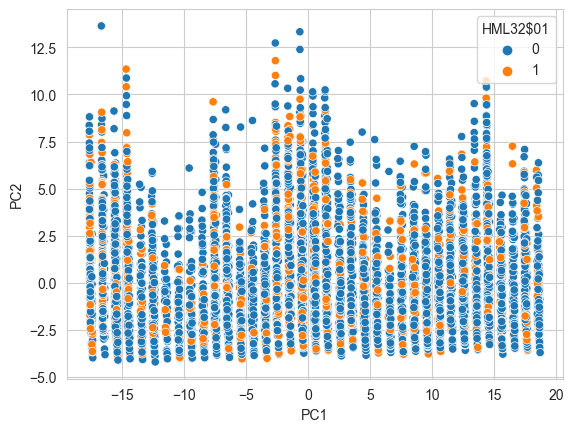

In [13]:
X = data.drop([target], axis=1)
y = data[target]

# Instantiate a PCA object and fit it to the data
pca = PCA(n_components=2)
pca.fit(X)

# Transform the data into 2D using the PCA object
X_2d = pca.transform(X)

# Plot the transformed data
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y)

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [14]:
new_data =data.__deepcopy__()
Y_data = new_data.pop(target)
X_data = new_data

Class Labels Index([0, 1], dtype='int64', name='HML32$01')
Class Counts [8242 2223]
Class Percentage [78.75776398 21.24223602]


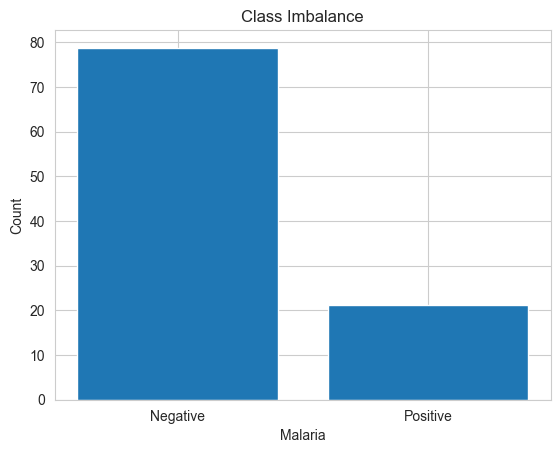

In [38]:
target_counts = Y_data.value_counts()

# Calculate the class distribution
class_labels = target_counts.index
class_counts = target_counts.values
total_samples = len(new_data)

# Calculate the percentage of each class
class_percentages = (class_counts / total_samples) * 100
print('Class Labels', class_labels)
print('Class Counts', class_counts)
print('Class Percentage', class_percentages)

# Plotting the class distribution
plt.bar(['Negative', 'Positive'], class_percentages)
plt.xlabel('Malaria')
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.show()

<Axes: >

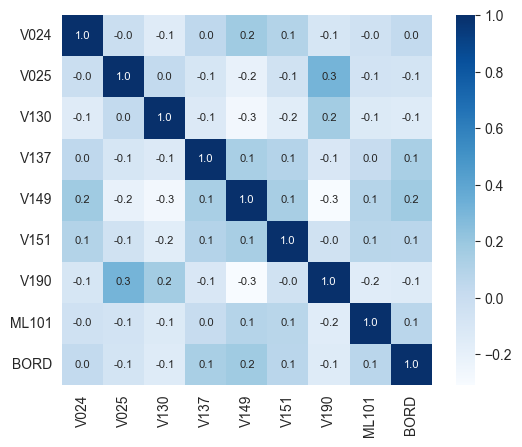

In [16]:
correlation=new_data.corr()
sns.heatmap(correlation,cbar=True,square=True,fmt='.1f',annot=True,annot_kws={'size':8},cmap="Blues")


In [17]:
def undersampling():
    # Perform undersampling
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    return undersampler.fit_resample(X_data, Y_data)


def oversampling():
    # Perform oversampling
    oversampler = RandomOverSampler(sampling_strategy='minority')
    return oversampler.fit_resample(X_data, Y_data)


def smote():
    # Perform SMOTE
    smote_sampler = SMOTE(sampling_strategy='minority')
    return smote_sampler.fit_resample(X_data, Y_data)


classifier = LogisticRegression()
results = {}
for algorithm in [undersampling, oversampling, smote]:
    X, Y = algorithm()
    classifier.fit(X, Y)
    predicted_labels = classifier.predict(X_data)
    accuracy = accuracy_score(Y_data, predicted_labels)
    results[algorithm.__name__] = accuracy

# Determine the best algorithm based on the accuracy
best_algorithm = max(results, key=results.get)

# Print the results and the best algorithm
print("Sampling Algorithm Results:")
for algorithm, accuracy in results.items():
    print(f"{algorithm}: {accuracy}")
print("\nBest Algorithm:")
print(best_algorithm)

Sampling Algorithm Results:
undersampling: 0.52651696129957
oversampling: 0.5225991399904444
smote: 0.49622551361681794

Best Algorithm:
undersampling


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
# Assume X_train and y_train are your training data
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Example threshold values to test

best_threshold = None
best_score = 0

for threshold in thresholds:
    sel = VarianceThreshold(threshold=threshold)
    X_train_selected = sel.fit_transform(X_data)
    # Assume RandomForestClassifier as your model, modify it based on your problem
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, X_train_selected, Y_data, cv=5, scoring='accuracy')
    avg_score = scores.mean()
    print(f"Threshold: {threshold}, Average Cross-Validation Score: {avg_score}")
    if avg_score > best_score:
        best_score = avg_score
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best Cross-Validation Score: {best_score}")

Threshold: 0, Average Cross-Validation Score: 0.5860487338748209
Threshold: 0.1, Average Cross-Validation Score: 0.5976110845676063
Threshold: 0.2, Average Cross-Validation Score: 0.5949354992833255
Threshold: 0.3, Average Cross-Validation Score: 0.5805064500716675
Threshold: 0.4, Average Cross-Validation Score: 0.5809842331581462
Threshold: 0.5, Average Cross-Validation Score: 0.5812709030100335
Threshold: 0.6, Average Cross-Validation Score: 0.5827998088867654
Threshold: 0.7, Average Cross-Validation Score: 0.5807931199235548
Threshold: 0.8, Average Cross-Validation Score: 0.5780219780219781
Threshold: 0.9, Average Cross-Validation Score: 0.5827042522694696
Threshold: 1, Average Cross-Validation Score: 0.5822264691829909
Best Threshold: 0.1, Best Cross-Validation Score: 0.5976110845676063


In [19]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X_data)
sum(sel.get_support())
print(
    len([
        x for x in X_data.columns
        if x not in X_data.columns[sel.get_support()]
    ]))

importance=[x for x in X_data.columns if x not in X_data.columns[sel.get_support()]]
if len(importance) == 0 or importance == 0:
    importance = elements
    print(importance)

0
['V024     Region', 'V025     Type of place of residence', 'V130     Religion', 'V137     Number of children 5 and under in household (de jure)', 'V149     Educational attainment', 'V151     Sex of household head', 'V190     Wealth index combined', 'ML101    Type of mosquito bed net(s) slept under last night', 'BORD     Birth order number', 'HML32$01 Final result of malaria from blood smear test']


In [20]:
# class func():
#     def __init__(self, train, label, test, model, model_type, random_state):
#         self.train, self.label, self.test = train, label, test
#         self.model, self.model_type = model, model_type
#         self.random_state = random_state
# 
#         assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'log', 'rad'), 'Incorrect model_type'
# 
#     def __call__(self, plot=True):
#         return self.fit(plot)
# 
#     def fit(self, plot):
#         def log_fit(X_train, X_test, y_train, y_test):
#             self.model.fit(X_train, y_train)
#             x_test_predict = self.model.predict_proba(X_test)[:, 1]
#             x_train_predict = self.model.predict_proba(X_train)[:, 1]
#             self.val_p[test_index] = x_test_predict
#             self.test_p += self.model.predict_proba(self.test)[:, 1]
#             return x_test_predict, x_train_predict
#         
#         def rad_fit(X_train, X_test, y_train, y_test):
#             self.model.fit(X_train, y_train)
#             x_test_predict = self.model.predict_proba(X_test)[:, 1]
#             x_train_predict = self.model.predict_proba(X_train)[:, 1]
#             self.val_p[test_index] = x_test_predict
#             self.test_p += self.model.predict_proba(self.test)[:, 1]
#             return x_test_predict, x_train_predict
# 
#         def catboost_fit(X_train, X_test, y_train, y_test):
#             self.model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500,
#                            verbose=50, use_best_model=True)
#             x_test_predict = self.model.predict_proba(X_test)[:, 1]
#             x_train_predict = self.model.predict_proba(X_train)[:, 1]
#             self.val_p[test_index] = x_test_predict
#             self.test_p += self.model.predict_proba(self.test)[:, 1]
#             return x_test_predict, x_train_predict
# 
#         def xgboost_fit(X_train, X_test, y_train, y_test):
#             self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
#                            eval_set=[(X_test, y_test)], verbose=True)
#             x_test_predict = self.model.predict_proba(X_test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
#                              1]
#             x_train_predict = self.model.predict_proba(X_train, ntree_limit=self.model.get_booster().best_ntree_limit)[
#                               :, 1]
#             self.val_p[test_index] = x_test_predict
#             self.test_p += self.model.predict_proba(self.test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
#                            1]
#             return x_test_predict, x_train_predict
# 
#         def lgbm_fit(X_train, X_test, y_train, y_test):
#             self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
#                            eval_set=[(X_test, y_test)], verbose=True)
#             x_test_predict = self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
#             x_train_predict = self.model.predict_proba(X_train, num_iteration=self.model.best_iteration_)[:, 1]
#             self.val_p[test_index] = x_test_predict
#             self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:, 1]
#             return x_test_predict, x_train_predict
# 
#         self.val_p = np.zeros(self.train.shape[0])
#         mean_val = []
#         mean_train = []
#         self.test_p = np.zeros(self.test.shape[0])
#         splits = 5
#         kf = StratifiedKFold(n_splits=splits)
#         for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
#             X_train, X_test = self.train.iloc[train_index], self.train.iloc[test_index]
#             y_train, y_test = self.label.iloc[train_index], self.label.iloc[test_index]
# 
#             print(f"================================Fold{fold_count + 1}====================================")
#             if self.model_type == 'catboost':
#                 x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
#             elif self.model_type == 'xgboost':
#                 x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
#             elif self.model_type == 'rad':
#                 x_test_predict, x_train_predict = rad_fit(X_train, X_test, y_train, y_test)
#             elif self.model_type == 'log':
#                 x_test_predict, x_train_predict = log_fit(X_train, X_test, y_train, y_test)
#             elif self.model_type == 'lgbm':
#                 x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
#             print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
#             print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
#             mean_val.append(roc_auc_score(y_train, x_train_predict))
#             mean_train.append(roc_auc_score(y_train, x_train_predict))
# 
#         if plot and self.model_type != 'log':
#             feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_, self.train.columns)),
#                                     columns=['Value', 'Feature'])
#             plt.figure(figsize=(30, 25))
#             sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False),  color='blue')
#             plt.ylabel('Feature Importance Score')
#             plt.show()
#         print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
#         return self.val_p, self.test_p / splits, self.model

In [53]:
import matplotlib.patches as patches
from scipy import interp
class func():
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state

        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'log', 'rad'), 'Incorrect model_type'

    def __call__(self, plot=True):
        return self.fit(plot)

    def fit(self, plot):
        def log_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict
        
        def rad_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500,
                           verbose=50, use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                             1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit=self.model.get_booster().best_ntree_limit)[
                              :, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                           1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration=self.model.best_iteration_)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:, 1]
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits=splits)
        
        # Plot arrows
        fig1 = plt.figure(figsize=[12, 12])
        ax1 = fig1.add_subplot(111, aspect='equal')
        # ax1.add_patch(
        #     patches.Arrow(0.45, 0.5, -0.25, 0.25, width=0.3, color='green', alpha=0.5)
        # )
        # ax1.add_patch(
        #     patches.Arrow(0.5, 0.45, 0.25, -0.25, width=0.3, color='red', alpha=0.5)
        # )

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        i = 1
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train, X_test = self.train.iloc[train_index], self.train.iloc[test_index]
            y_train, y_test = self.label.iloc[train_index], self.label.iloc[test_index]

            print(f"================================Fold{fold_count + 1}====================================")
            if self.model_type == 'catboost':
                x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost':
                x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'rad':
                x_test_predict, x_train_predict = rad_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'log':
                x_test_predict, x_train_predict = log_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm':
                x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_train, x_train_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))
            # Plot ROC curve
            fpr, tpr, _ = roc_curve(y_test, x_test_predict)
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
            i = i + 1
            
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
        plt.legend(loc="lower right")
        # plt.text(0.32, 0.7, 'More accurate area', fontsize=12)
        # plt.text(0.63, 0.4, 'Less accurate area', fontsize=12)
        plt.show()
        
        if plot and self.model_type != 'log':
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_, self.train.columns)),
                                    columns=['Value', 'Feature'])
            plt.figure(figsize=(30, 25))
            # sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.barh(feat_imp['Feature'], feat_imp['Value'])
            plt.xlabel('Feature Importance Score',fontsize=40)
            plt.ylabel('Features',fontsize=40)
            plt.title('Feature Importance',fontsize=40)
            plt.tick_params(axis='both', labelsize=40)
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p / splits, self.model

In [22]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import layers
# import keras_tuner

In [23]:
 xgboost = xgb.XGBClassifier(objectsve='binary:logistic',
                            eta=0.99,
                            max_depth=6,
                            n_estimators=5000,
                            reg_lambda=500,
                            scoring='f1',
                            sub_sample=0.8,
                            colsample_bytree=0.8)
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='TotalF1', reg_lambda=370)
clf_rad = RandomForestClassifier()
def run_predictions(X_train, y_train, X_test):
    # classifier with cross validation and feature selection
    func_ = func(X_train, y_train, X_test, classifier, 'log', 1000)
    val_p, test_p, model = func_()
    func_ = func(X_train, y_train, X_test, catboost, 'catboost', 1000)
    val_p1, test_p1, model1 = func_()
    func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
    val_p2, test_p2, model2 = func_()
    func_ = func(X_train, y_train, X_test, clf_rad, 'rad', 1000)
    val_p3, test_p3, model3 = func_()
    return model, model1, model2, model3

In [24]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix,auc,roc_curve


def evaluate_model(y_true, y_pred, average='binary'):
    """
    Function to evaluate a machine learning model's performance using common evaluation metrics and the classification report.

    Parameters:
        y_true (array-like): The true labels of the data.
        y_pred (array-like): The predicted labels of the data.
        average (str, optional): The type of averaging to use for multi-class classification.
                                 Can be 'binary', 'micro', 'macro', or 'weighted'. Default is 'binary'.
                                 Ignored for binary classification problems.

    Returns:
        dict: A dictionary containing the evaluation metrics and the centered classification report.
    """

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('Unique instance ', np.unique(y_true, return_counts=True), np.unique(y_pred, return_counts=True))
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # print('Confusion matrix', tn, fp, fn, tp)
    # print(confusion_matrix(y_true, y_pred))
    # precision = tp/(tp+fp)
    # recall = tp/(tp+fn)
    # f1 = 2*precision*recall/(precision+recall)
    # # Calculate classification report
    aa  = classification_report(y_true, y_pred, output_dict=True)
    print(aa)
    report = classification_report(y_true, y_pred)
    print('Accuracy', accuracy)
    print('Precision', precision)
    print('Recall', recall)
    print('F1 Score', f1)
    print('Classification Report')
    print(report)

    # Create dictionary of evaluation metrics and centered classification report
    metrics = {'accuracy': accuracy,
               'precision': precision,
               'recall': recall,
               'f1': f1}
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Class 0', 'Class 1']
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    print('Metrics for the  Evaluation is',metrics)
    return metrics

In [26]:
def eveluate_model_results(model1,model2, model, model3, nn_result, y_test, X_test):
    catboost_result = evaluate_model(y_test, model1.predict(X_test))
    xgboost_result = evaluate_model(y_test, model2.predict(X_test))
    logistic_regression_result = evaluate_model(y_test, model.predict(X_test))
    rad_regression_result = evaluate_model(y_test, model3.predict(X_test))
    print(
        {
          "catboost_result": catboost_result,
            "xgb":xgboost_result,
            "log":logistic_regression_result,
            "neural": nn_result,
            "radom_forest": rad_regression_result
        }
    )
    accuracy_list = [catboost_result['accuracy'], xgboost_result['accuracy'], logistic_regression_result['accuracy'], rad_regression_result['accuracy'],nn_result['accuracy']]
    precision_list = [catboost_result['precision'], xgboost_result['precision'], logistic_regression_result['precision'],rad_regression_result['accuracy'], nn_result['precision']]
    recall_list = [catboost_result['recall'], xgboost_result['recall'], logistic_regression_result['recall'],rad_regression_result['accuracy'], nn_result['recall']]
    f1_list = [catboost_result['f1'], xgboost_result['f1'], logistic_regression_result['f1'], rad_regression_result['accuracy'], nn_result['f1']]
    
    # Calculate percentages for accuracy list
    total_accuracy = sum(accuracy_list)
    accuracy_percentages = [round((accuracy / total_accuracy) * 100, 2) for accuracy in accuracy_list]
    
    # Calculate percentages for precision list
    total_precision = sum(precision_list)
    precision_percentages = [round((precision / total_precision) * 100, 2) for precision in precision_list]
    
    # Calculate percentages for recall list
    total_recall = sum(recall_list)
    recall_percentages = [round((recall / total_recall) * 100, 2) for recall in recall_list]
    
    # Calculate percentages for f1 list
    total_f1 = sum(f1_list)
    f1_percentages = [round((f1 / total_f1) * 100, 2) for f1 in f1_list]
    
    # Set colors for the bars
    colors = ['#FFC107', '#FF5722', '#4CAF50']
    
    # Plot for accuracy list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest', 'Neural Network'], accuracy_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of different models')
    
    # Add percentage labels to the bars
    for i, accuracy in enumerate(accuracy_list):
        plt.text(i, accuracy + 0.5, f"{accuracy_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for precision list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network'], precision_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Precision')
    plt.title('Precision of different models')
    
    # Add percentage labels to the bars
    for i, precision in enumerate(precision_list):
        plt.text(i, precision + 0.01, f"{precision_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for recall list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network'], recall_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Recall')
    plt.title('Recall of different models')
    
    # Add percentage labels to the bars
    for i, recall in enumerate(recall_list):
        plt.text(i, recall + 0.01, f"{recall_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for f1 list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network'], f1_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('F1 Score of different models')
    
    # Add percentage labels to the bars
    for i, f1 in enumerate(f1_list):
        plt.text(i, f1 + 0.01, f"{f1_percentages[i]}%", ha='center')
    
    plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42,stratify=Y_data)

================================Fold1====================================
[11:33:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.56269
[1]	validation_0-auc:0.55767
[2]	validation_0-auc:0.56695
[3]	validation_0-auc:0.56584
[4]	validation_0-auc:0.56829
[5]	validation_0-auc:0.56259
[6]	validation_0-auc:0.56378
[7]	validation_0-auc:0.56354
[8]	validation_0-auc:0.56027
[9]	validation_0-auc:0.55637
[10]	validation_0-auc:0.55875
[11]	validation_0-auc:0.55862
[12]	validation_0-auc:0.56055
[13]	validation_0-auc:0.56200
[14]	validation_0-auc:0.55873
[15]	validation_0-auc:0.55643
[16]	validation_0-auc:0.55662
[17]	validation_0-auc:0.55748
[18]	validation_0-auc:0.55732
[19]	validation_0-auc:0.55483
[20]	validation_0-auc:0.55468
[21]	validation_0-auc:0.55286
[22]	validation_0-auc:0.55509
[23]	validation_0-auc:0.55624
[24]	vali

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf

[25]	validation_0-auc:0.60737
[26]	validation_0-auc:0.60787
[27]	validation_0-auc:0.60987
[28]	validation_0-auc:0.61073
[29]	validation_0-auc:0.60980
[30]	validation_0-auc:0.61003
[31]	validation_0-auc:0.61093
[32]	validation_0-auc:0.60999
[33]	validation_0-auc:0.60978
[34]	validation_0-auc:0.61025
[35]	validation_0-auc:0.61078
[36]	validation_0-auc:0.61007
[37]	validation_0-auc:0.60937
[38]	validation_0-auc:0.60832
[39]	validation_0-auc:0.60832
[40]	validation_0-auc:0.60887
[41]	validation_0-auc:0.60919
[42]	validation_0-auc:0.60868
[43]	validation_0-auc:0.61050
[44]	validation_0-auc:0.60997
[45]	validation_0-auc:0.60952
[46]	validation_0-auc:0.60958
[47]	validation_0-auc:0.60924
[48]	validation_0-auc:0.60869
[49]	validation_0-auc:0.60798
[50]	validation_0-auc:0.60847
[51]	validation_0-auc:0.60962
[52]	validation_0-auc:0.60845
[53]	validation_0-auc:0.60866
[54]	validation_0-auc:0.60849
[55]	validation_0-auc:0.60849
[56]	validation_0-auc:0.60874
[57]	validation_0-auc:0.60995
[58]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/937659421.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

[28]	validation_0-auc:0.62407
[29]	validation_0-auc:0.62103
[30]	validation_0-auc:0.62075
[31]	validation_0-auc:0.62060
[32]	validation_0-auc:0.62201
[33]	validation_0-auc:0.62263
[34]	validation_0-auc:0.62321
[35]	validation_0-auc:0.62188
[36]	validation_0-auc:0.62232
[37]	validation_0-auc:0.62259
[38]	validation_0-auc:0.62209
[39]	validation_0-auc:0.62187
[40]	validation_0-auc:0.62056
[41]	validation_0-auc:0.62110
[42]	validation_0-auc:0.62105
[43]	validation_0-auc:0.62154
[44]	validation_0-auc:0.62137
[45]	validation_0-auc:0.62007
[46]	validation_0-auc:0.61994
[47]	validation_0-auc:0.61991
[48]	validation_0-auc:0.61987
[49]	validation_0-auc:0.62057
[50]	validation_0-auc:0.62013
[51]	validation_0-auc:0.61939
[52]	validation_0-auc:0.61815

Validation scores 0.6244263332805824 0.6703160019224266
Training scores 0.6761845529491881 0.6538843416021964
================================Fold5====================================
[11:33:37] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/937659421.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:8

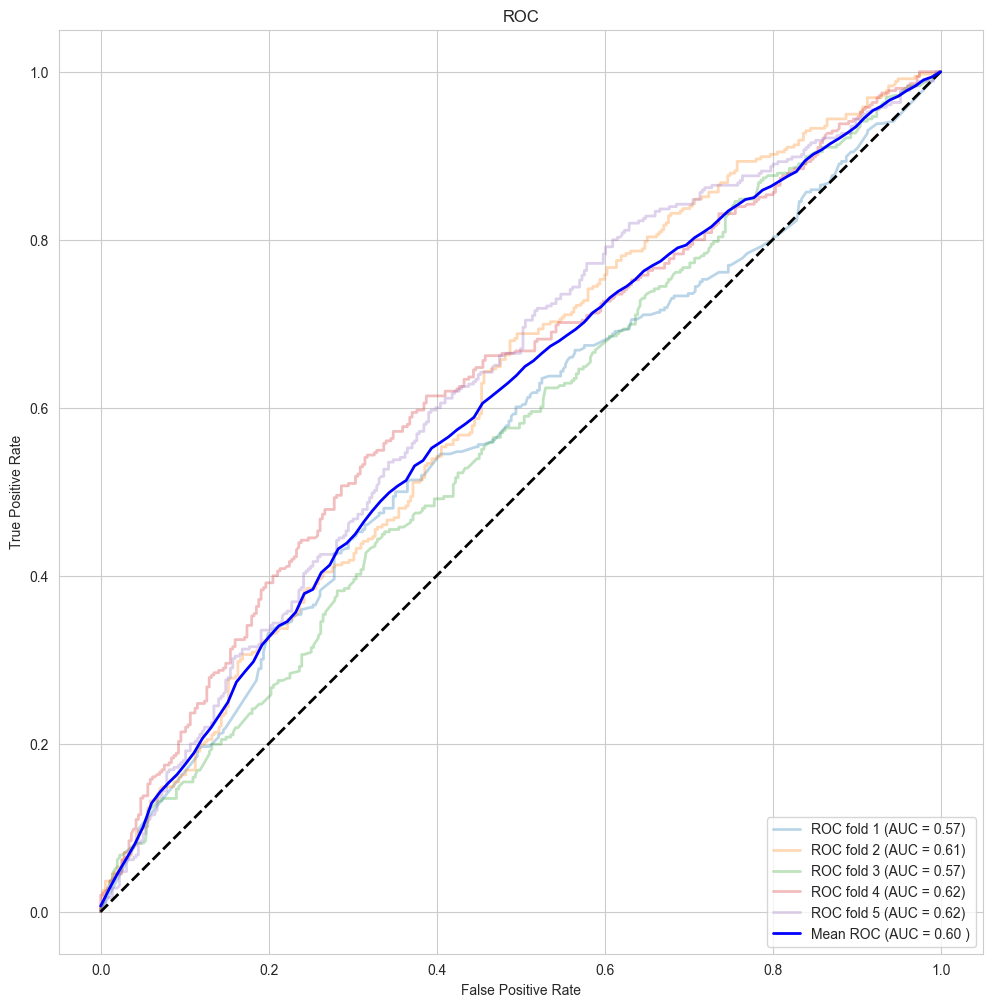

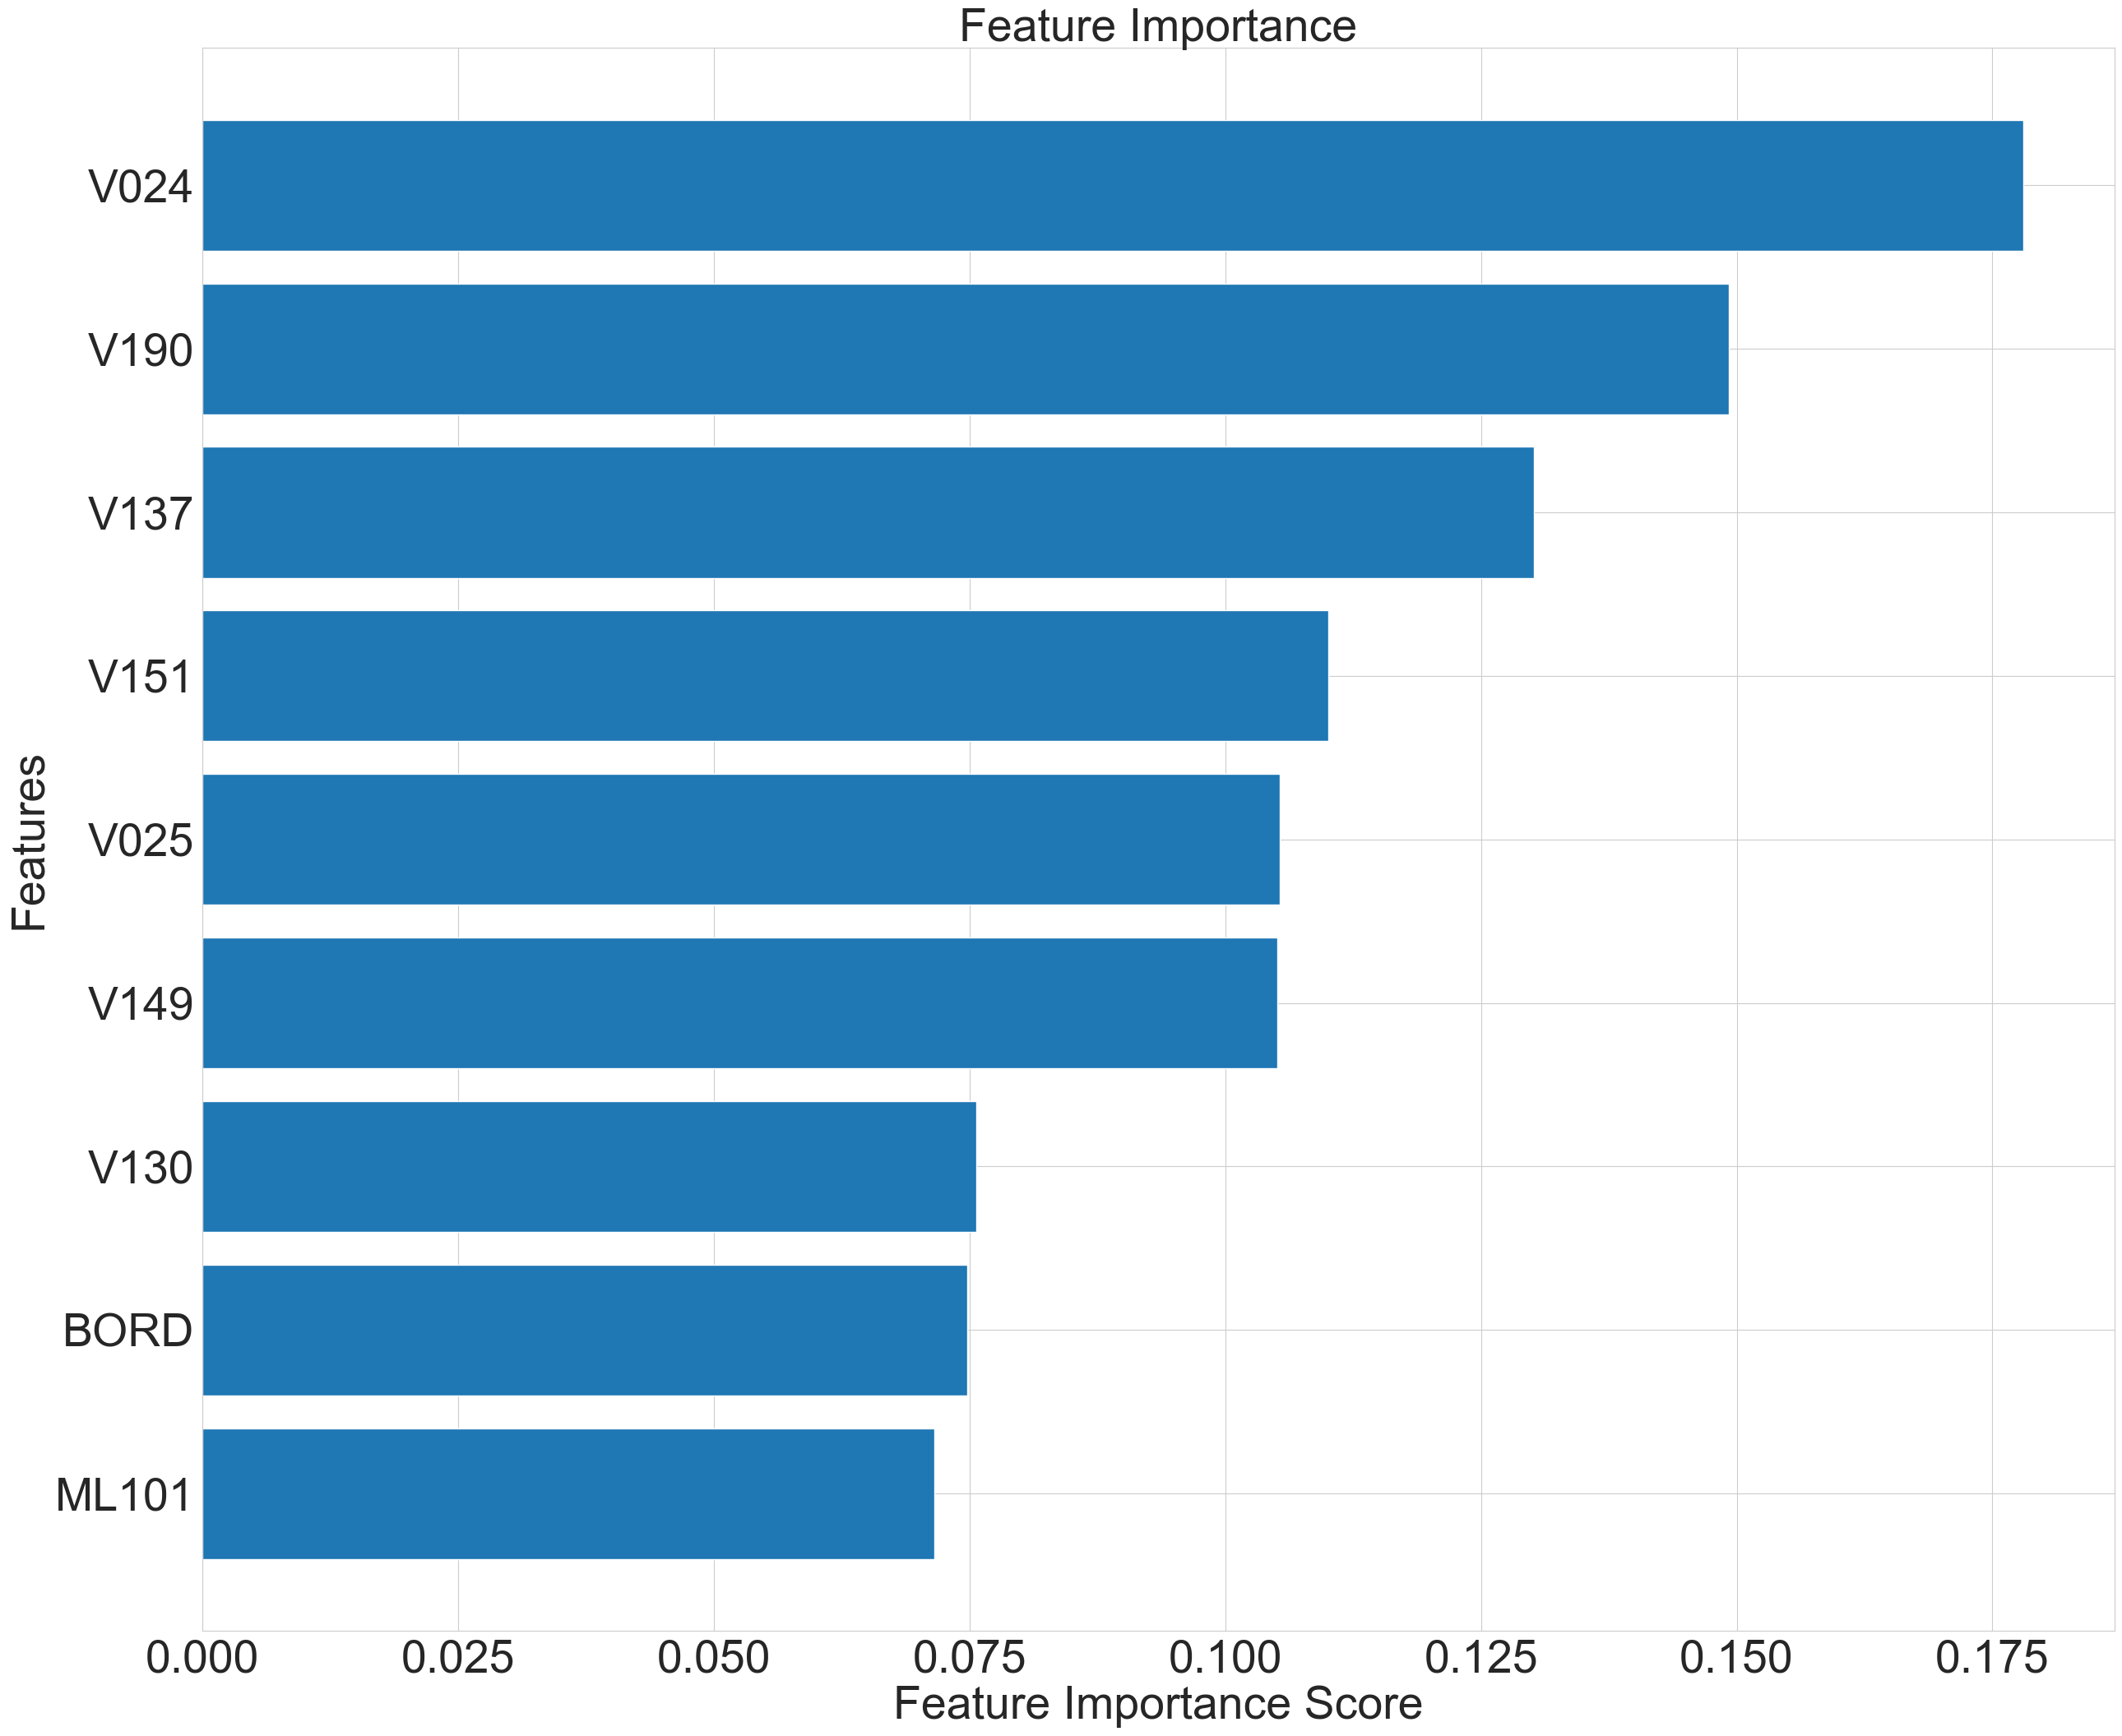

0.6643955428696042 0.6643955428696042 0.02339747103922764


In [54]:
func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

In [29]:
# from sklearn.preprocessing import MinMaxScaler
# # one hot representation
# _y_train = to_categorical(y_train)
# # _y_test = to_categorical(y_test)
# 
# # Normalization
# minmaxscaler = MinMaxScaler(feature_range = (0,1))
# X_train = minmaxscaler.fit_transform(X_train)
# X_test = minmaxscaler.transform(X_test)


In [30]:
from sklearn.preprocessing import MinMaxScaler
def train_neural(X_train, y_train, X_test, y_test):
 
    # one hot representation
    y_train = to_categorical(y_train)
    # _y_test = to_categorical(y_test)
    
    # Normalization
    minmaxscaler = MinMaxScaler(feature_range = (0,1))
    X_train = minmaxscaler.fit_transform(X_train)
    X_test = minmaxscaler.transform(X_test)

    network = Sequential()
    network.add(Dense(50, activation='relu', input_dim=X_train.shape[-1]))
    network.add(Dropout(0.2))
    network.add(Dense(25, activation='relu'))
    network.add(Dense(7, activation='relu'))
    network.add(Dense(2, activation='softmax'))  # Changed activation to 'softmax'
    network.compile(optimizer='adam',
                    loss='categorical_crossentropy',  # Changed loss function
                    metrics=['accuracy'])
    network.fit(X_train, y_train, epochs=3, batch_size=128, verbose=0)
    ppred = network.predict(X_test)
    predicted_labels = np.argmax(ppred, axis=1)
    print(y_test)
    nn_result = evaluate_model(y_test,predicted_labels)
    return nn_result

# Assuming y_train and y_test are integer labels (e.g., 0, 1)
# aa = train_neural(X_train, y_train, X_test, y_test)
# scores2 = aa.evaluate(X_test, y_test, verbose=2)
# rounded_predictions = aa.predict(X_test)

0:	learn: 0.6940535	total: 67.5ms	remaining: 11m 14s
1:	learn: 0.6940535	total: 72.2ms	remaining: 6m
2:	learn: 0.6940535	total: 73.6ms	remaining: 4m 5s
3:	learn: 0.6940535	total: 75ms	remaining: 3m 7s
4:	learn: 0.6940535	total: 76.4ms	remaining: 2m 32s
5:	learn: 0.6940535	total: 77.8ms	remaining: 2m 9s
6:	learn: 0.6940535	total: 79.1ms	remaining: 1m 52s
7:	learn: 0.6940535	total: 80.4ms	remaining: 1m 40s
8:	learn: 0.6940535	total: 81.7ms	remaining: 1m 30s
9:	learn: 0.6940535	total: 83.1ms	remaining: 1m 23s
10:	learn: 0.6940535	total: 84.5ms	remaining: 1m 16s
11:	learn: 0.6940535	total: 85.8ms	remaining: 1m 11s
12:	learn: 0.6940535	total: 87.2ms	remaining: 1m 6s
13:	learn: 0.6940535	total: 88.6ms	remaining: 1m 3s
14:	learn: 0.6940535	total: 90ms	remaining: 59.9s
15:	learn: 0.6940535	total: 91.5ms	remaining: 57.1s
16:	learn: 0.6940535	total: 92.8ms	remaining: 54.5s
17:	learn: 0.6940535	total: 94.3ms	remaining: 52.3s
18:	learn: 0.6940535	total: 95.6ms	remaining: 50.2s


/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


19:	learn: 0.6940535	total: 107ms	remaining: 53.5s
20:	learn: 0.6940535	total: 111ms	remaining: 52.9s
21:	learn: 0.6940535	total: 115ms	remaining: 52s
22:	learn: 0.6940535	total: 128ms	remaining: 55.5s
23:	learn: 0.6940535	total: 129ms	remaining: 53.7s
24:	learn: 0.6940535	total: 131ms	remaining: 52.2s
25:	learn: 0.6940535	total: 132ms	remaining: 50.7s
26:	learn: 0.6940535	total: 134ms	remaining: 49.5s
27:	learn: 0.6940535	total: 137ms	remaining: 48.7s
28:	learn: 0.6940535	total: 139ms	remaining: 47.7s
29:	learn: 0.6940535	total: 140ms	remaining: 46.7s
30:	learn: 0.6940535	total: 142ms	remaining: 45.6s
31:	learn: 0.6940535	total: 144ms	remaining: 44.8s
32:	learn: 0.6940535	total: 145ms	remaining: 43.9s
33:	learn: 0.6940535	total: 152ms	remaining: 44.5s
34:	learn: 0.6940535	total: 154ms	remaining: 43.7s
35:	learn: 0.6940535	total: 155ms	remaining: 43s
36:	learn: 0.6940535	total: 157ms	remaining: 42.2s
37:	learn: 0.6940535	total: 158ms	remaining: 41.5s
38:	learn: 0.6940535	total: 160ms	r

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

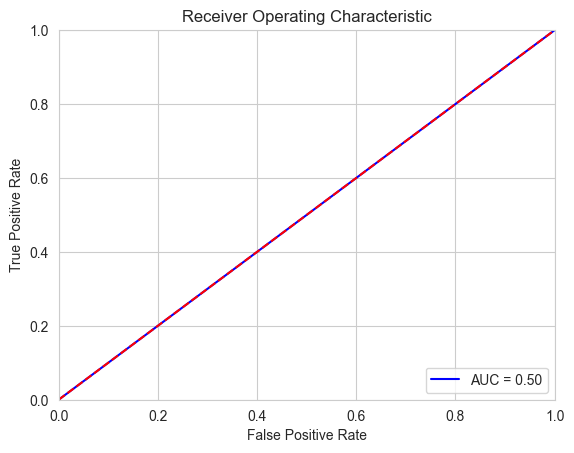

Normalized confusion matrix


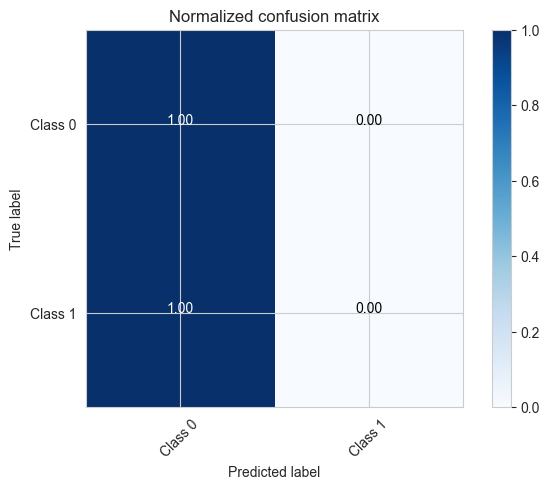

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([2021,   72]))
{'0': {'precision': 0.7877288471053934, 'recall': 0.9660194174757282, 'f1-score': 0.8678113927500682, 'support': 1648}, '1': {'precision': 0.2222222222222222, 'recall': 0.035955056179775284, 'f1-score': 0.061895551257253385, 'support': 445}, 'accuracy': 0.7682752030578117, 'macro avg': {'precision': 0.5049755346638078, 'recall': 0.5009872368277517, 'f1-score': 0.46485347200366084, 'support': 2093}, 'weighted avg': {'precision': 0.6674945193113125, 'recall': 0.7682752030578117, 'f1-score': 0.6964628263552749, 'support': 2093}}
Accuracy 0.7682752030578117
Precision 0.2222222222222222
Recall 0.035955056179775284
F1 Score 0.061895551257253385
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1648
           1       0.22

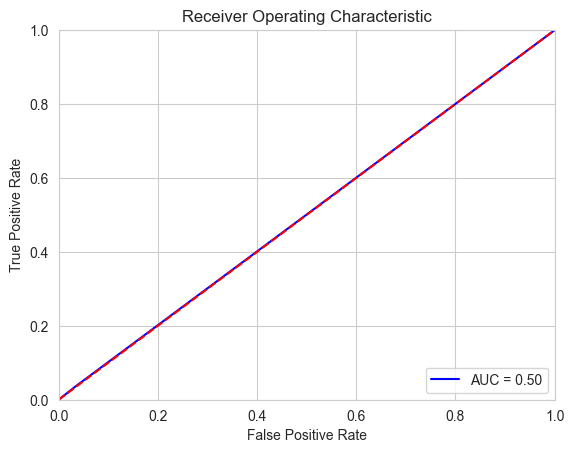

Normalized confusion matrix


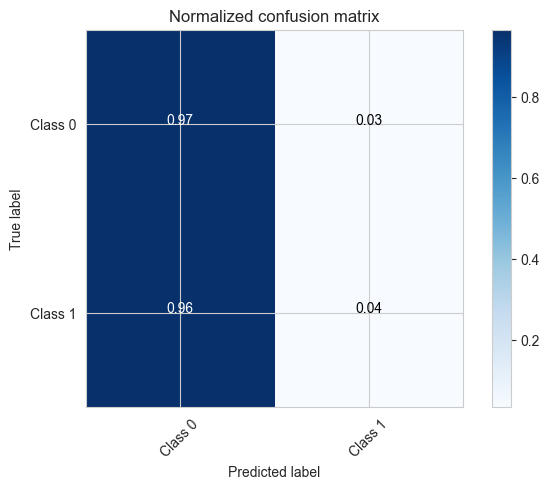

Metrics for the  Evaluation is {'accuracy': 0.7682752030578117, 'precision': 0.2222222222222222, 'recall': 0.035955056179775284, 'f1': 0.061895551257253385}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([1868,  225]))
{'0': {'precision': 0.791220556745182, 'recall': 0.8968446601941747, 'f1-score': 0.8407281001137656, 'support': 1648}, '1': {'precision': 0.24444444444444444, 'recall': 0.12359550561797752, 'f1-score': 0.16417910447761194, 'support': 445}, 'accuracy': 0.7324414715719063, 'macro avg': {'precision': 0.5178325005948132, 'recall': 0.5102200829060761, 'f1-score': 0.5024536022956888, 'support': 2093}, 'weighted avg': {'precision': 0.6749685882913702, 'recall': 0.7324414715719063, 'f1-score': 0.6968846681701018, 'support': 2093}}
Accuracy 0.7324414715719063
Precision 0.24444444444444444
Recall 0.12359550561797752
F1 Score 0.16417910447761194
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.9

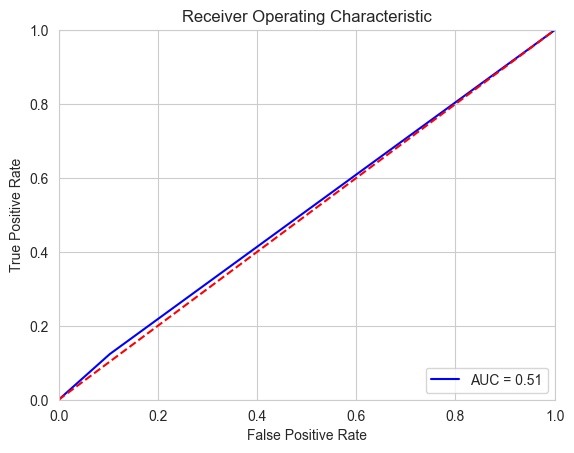

Normalized confusion matrix


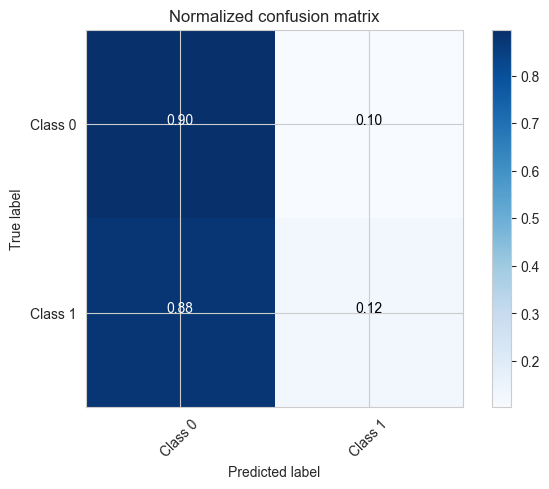

Metrics for the  Evaluation is {'accuracy': 0.7324414715719063, 'precision': 0.24444444444444444, 'recall': 0.12359550561797752, 'f1': 0.16417910447761194}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0]), array([2093]))
{'0': {'precision': 0.7873865265169613, 'recall': 1.0, 'f1-score': 0.8810478481689388, 'support': 1648}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 445}, 'accuracy': 0.7873865265169613, 'macro avg': {'precision': 0.39369326325848064, 'recall': 0.5, 'f1-score': 0.4405239240844694, 'support': 2093}, 'weighted avg': {'precision': 0.6199775421404453, 'recall': 0.7873865265169613, 'f1-score': 0.6937252048649838, 'support': 2093}}
Accuracy 0.7873865265169613
Precision 0.0
Recall 0.0
F1 Score 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.00      0.00      0.00       445

    accuracy                           0.79      2093
   

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

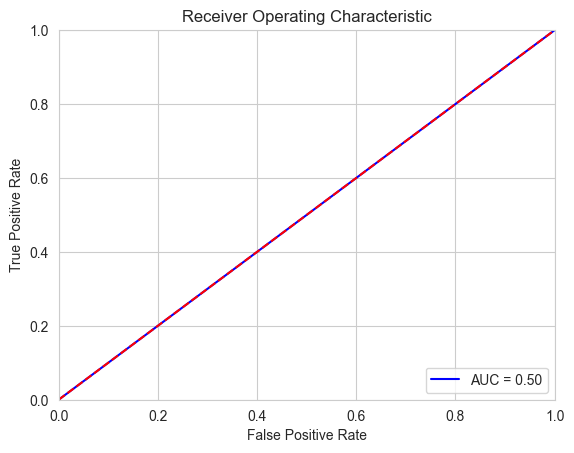

Normalized confusion matrix


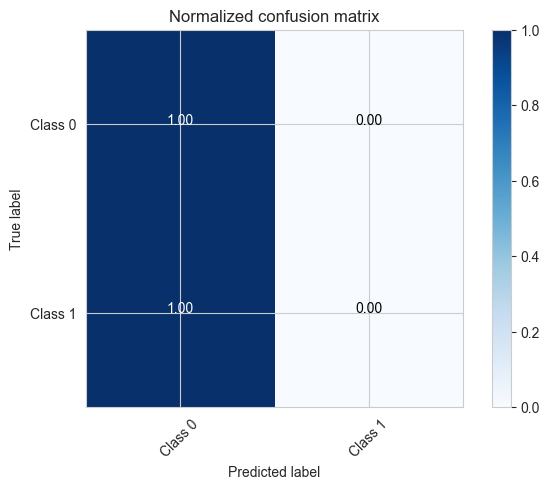

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([1882,  211]))
{'0': {'precision': 0.7954303931987248, 'recall': 0.908373786407767, 'f1-score': 0.8481586402266289, 'support': 1648}, '1': {'precision': 0.2843601895734597, 'recall': 0.1348314606741573, 'f1-score': 0.18292682926829268, 'support': 445}, 'accuracy': 0.7439082656473961, 'macro avg': {'precision': 0.5398952913860923, 'recall': 0.5216026235409621, 'f1-score': 0.5155427347474608, 'support': 2093}, 'weighted avg': {'precision': 0.6867699820122732, 'recall': 0.7439082656473961, 'f1-score': 0.7067213942273649, 'support': 2093}}
Accuracy 0.7439082656473961
Precision 0.2843601895734597
Recall 0.1348314606741573
F1 Score 0.18292682926829268
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1648
           1       0.28      0.

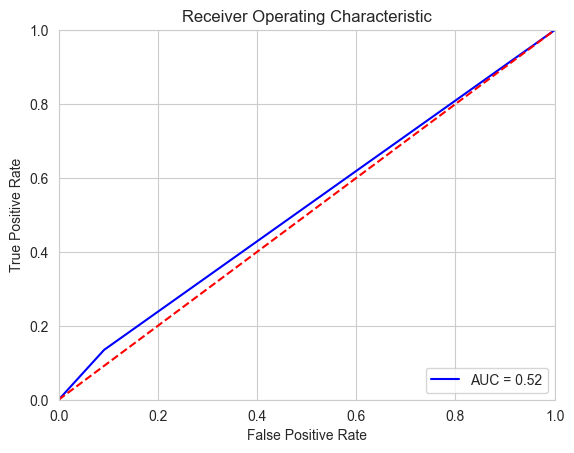

Normalized confusion matrix


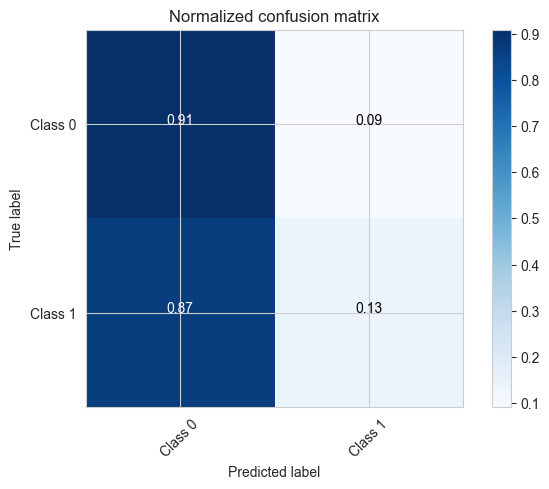

Metrics for the  Evaluation is {'accuracy': 0.7439082656473961, 'precision': 0.2843601895734597, 'recall': 0.1348314606741573, 'f1': 0.18292682926829268}
{'catboost_result': {'accuracy': 0.7682752030578117, 'precision': 0.2222222222222222, 'recall': 0.035955056179775284, 'f1': 0.061895551257253385}, 'xgb': {'accuracy': 0.7324414715719063, 'precision': 0.24444444444444444, 'recall': 0.12359550561797752, 'f1': 0.16417910447761194}, 'log': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'neural': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'radom_forest': {'accuracy': 0.7439082656473961, 'precision': 0.2843601895734597, 'recall': 0.1348314606741573, 'f1': 0.18292682926829268}}


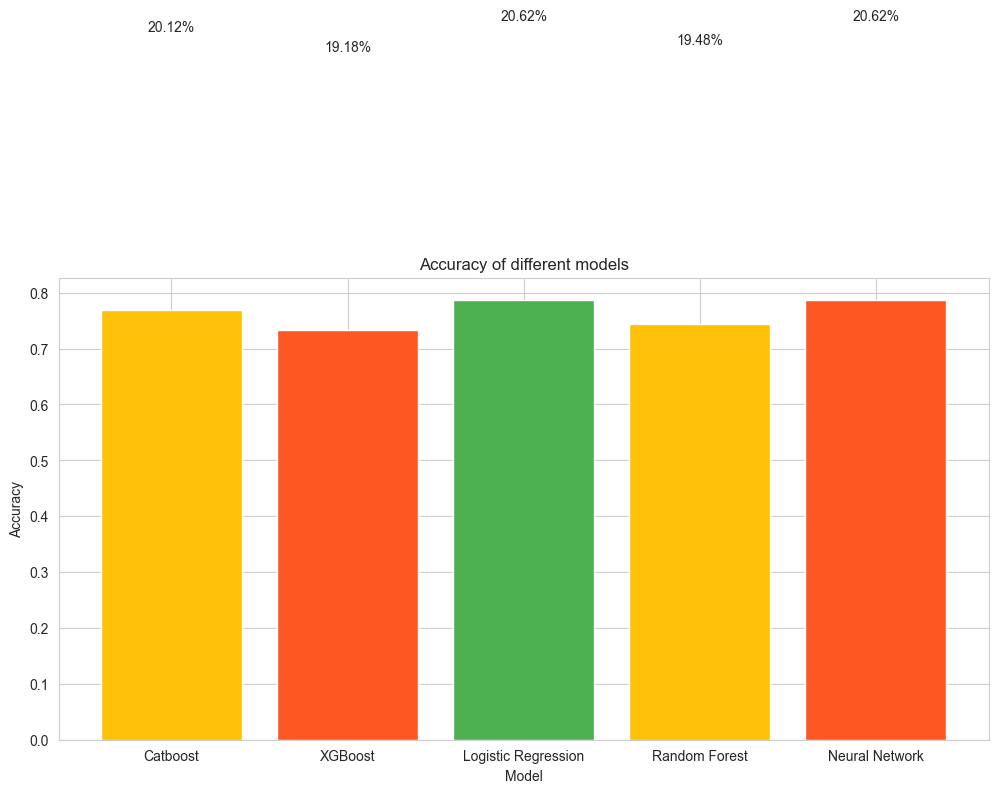

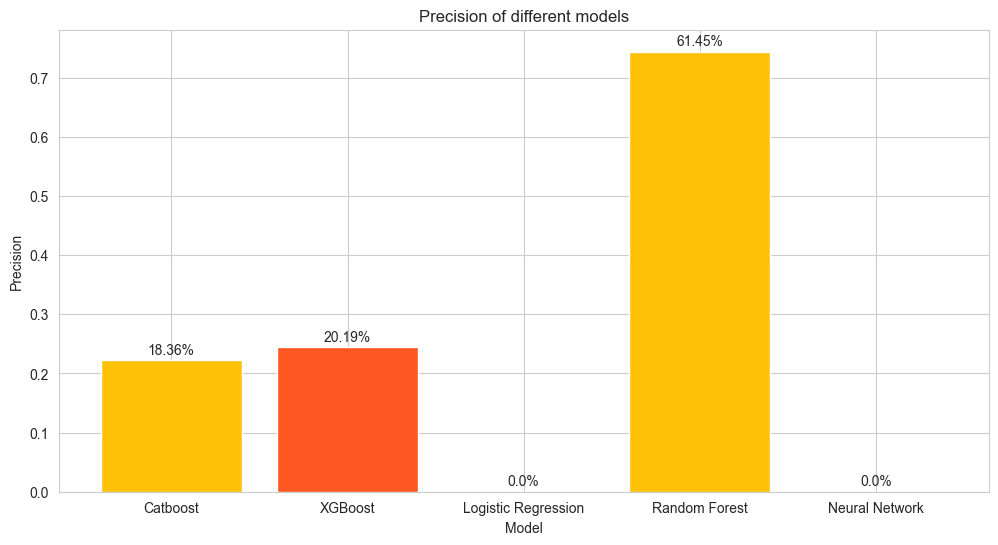

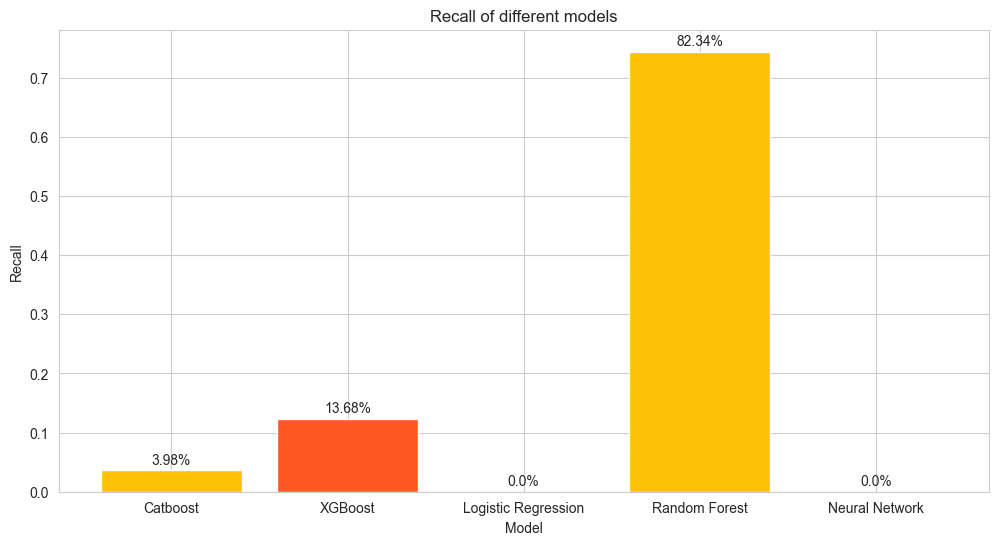

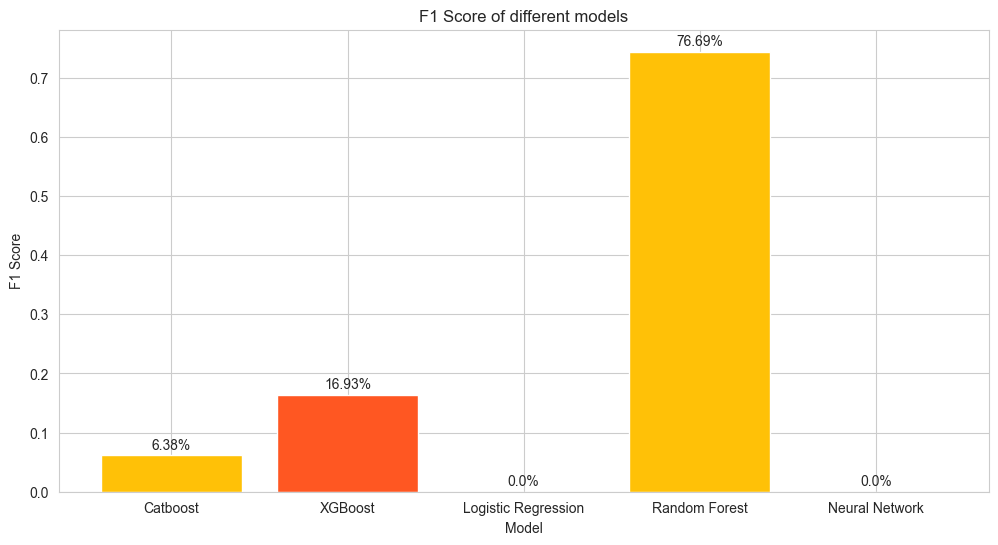

In [31]:
# Results without cross validation and without sampling
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, stratify=Y_data)
with_out_cross_classifier = classifier.fit(X_train, y_train)
with_out_cross_catboost = catboost.fit(X_train, y_train)
with_out_cross_xgboost = xgboost.fit(X_train, y_train)
with_out_cross_rad = clf_rad.fit(X_train, y_train)
with_out_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_out_cross_catboost,with_out_cross_xgboost, with_out_cross_classifier,with_out_cross_rad, with_out_cross_neural_result, y_test, X_test)

In [32]:
# a a=a as 

In [33]:
# # Results with cross validation and without sampling
# with_cross_classifier,with_cross_catboost,with_cross_xgboost, with_out_cross_rad = run_predictions(X_train,y_train, X_test)
# with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
# eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_out_cross_rad, with_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.5575863992980723 0.5135712362050033
Training scores 0.5558560468201118 0.5137987444131525
================================Fold2====================================

Validation scores 0.5293602150079648 0.5178183766172145
Training scores 0.5626300984528831 0.5128075525919987
================================Fold3====================================

Validation scores 0.5431929975618489 0.5154879478441646
Training scores 0.558696653582979 0.5133371447371156
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/xm/rq0m1_29363


Validation scores 0.5582494207092441 0.5129693982931653
Training scores 0.5561335273918995 0.5140423154025918
================================Fold5====================================

Validation scores 0.5595062413907249 0.5133460697244885
Training scores 0.5555507521989789 0.5138665680395086


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


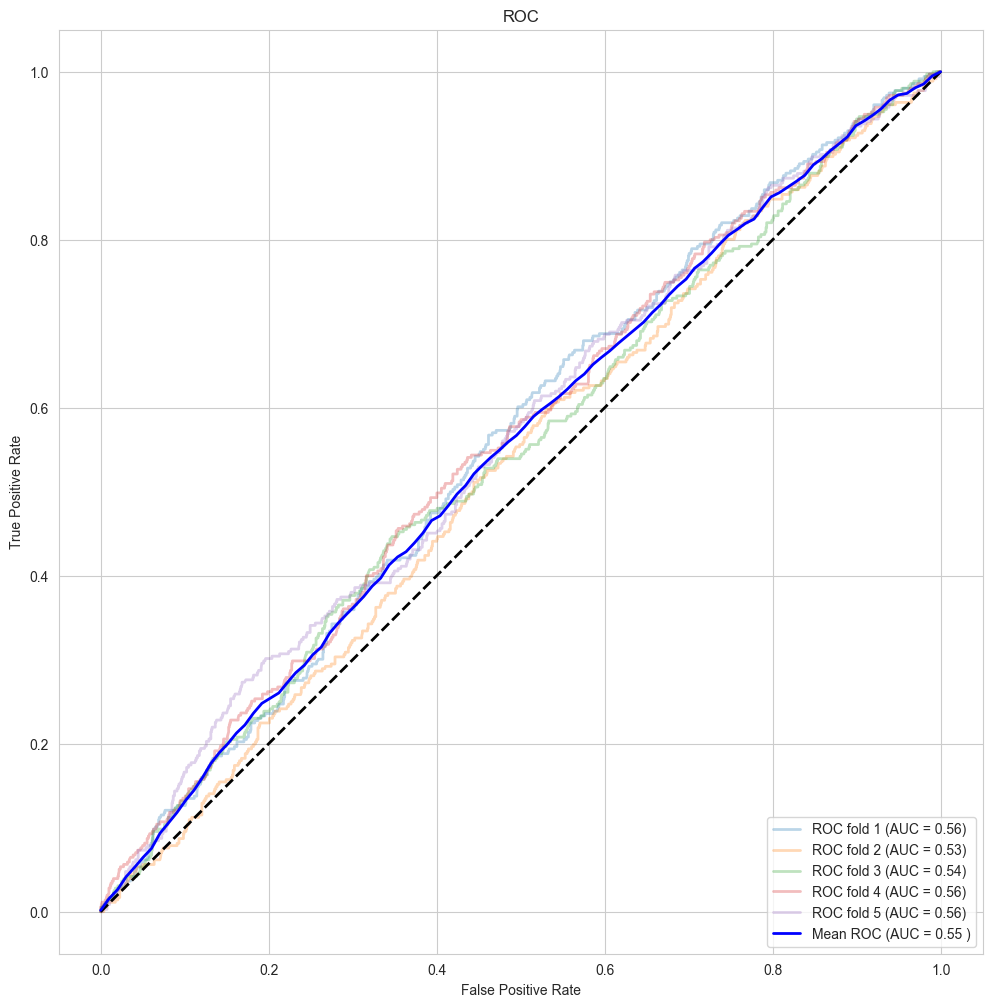

0.5577734156893704 0.5577734156893704 0.0026737803078824645
================================Fold1====================================
0:	learn: 0.6954581	test: 0.6952524	best: 0.6952524 (0)	total: 1.37ms	remaining: 13.7s
50:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 72.8ms	remaining: 14.2s
100:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 146ms	remaining: 14.3s
150:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 219ms	remaining: 14.3s
200:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 292ms	remaining: 14.2s
250:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 368ms	remaining: 14.3s
300:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 441ms	remaining: 14.2s
350:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 518ms	remaining: 14.2s
400:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 593ms	remaining: 14.2s
450:	learn: 0.6941094	test: 0.6938298	best: 0.6952524 (0)	total: 668ms	rema

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 147ms	remaining: 14.4s
150:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 222ms	remaining: 14.5s
200:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 298ms	remaining: 14.5s
250:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 373ms	remaining: 14.5s
300:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 447ms	remaining: 14.4s
350:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 520ms	remaining: 14.3s
400:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 596ms	remaining: 14.3s
450:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 674ms	remaining: 14.3s
500:	learn: 0.6941094	test: 0.6938298	best: 0.6938298 (0)	total: 750ms	remaining: 14.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6938298488
bestIteration = 0

Shrink model to first 1 iterations.

Validation scores 0.5222706595905989 0.6831854104857431
Training scores 

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


50:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 74.3ms	remaining: 14.5s
100:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 149ms	remaining: 14.6s
150:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 223ms	remaining: 14.5s
200:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 299ms	remaining: 14.6s
250:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 375ms	remaining: 14.5s
300:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 449ms	remaining: 14.5s
350:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 524ms	remaining: 14.4s
400:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 599ms	remaining: 14.3s
450:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 674ms	remaining: 14.3s
500:	learn: 0.6941529	test: 0.6936554	best: 0.6936554 (0)	total: 752ms	remaining: 14.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6936554029
bestIteration = 0

Shrink model to first

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


150:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 221ms	remaining: 14.4s
200:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 296ms	remaining: 14.4s
250:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 371ms	remaining: 14.4s
300:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 445ms	remaining: 14.3s
350:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 520ms	remaining: 14.3s
400:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 597ms	remaining: 14.3s
450:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 671ms	remaining: 14.2s
500:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 746ms	remaining: 14.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.694476279
bestIteration = 0

Shrink model to first 1 iterations.

Validation scores 0.5290147251972792 0.6830773693636383
Training scores 0.5337986298221833 0.6830649428320161
================================Fold5==============

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 150ms	remaining: 14.7s
150:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 224ms	remaining: 14.6s
200:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 303ms	remaining: 14.8s
250:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 379ms	remaining: 14.7s
300:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 454ms	remaining: 14.6s
350:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 530ms	remaining: 14.6s
400:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 608ms	remaining: 14.5s
450:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 684ms	remaining: 14.5s
500:	learn: 0.6939478	test: 0.6944763	best: 0.6944763 (0)	total: 758ms	remaining: 14.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.694476279
bestIteration = 0

Shrink model to first 1 iterations.

Validation scores 0.5454110561778557 0.6832006624297403
Training scores 0

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


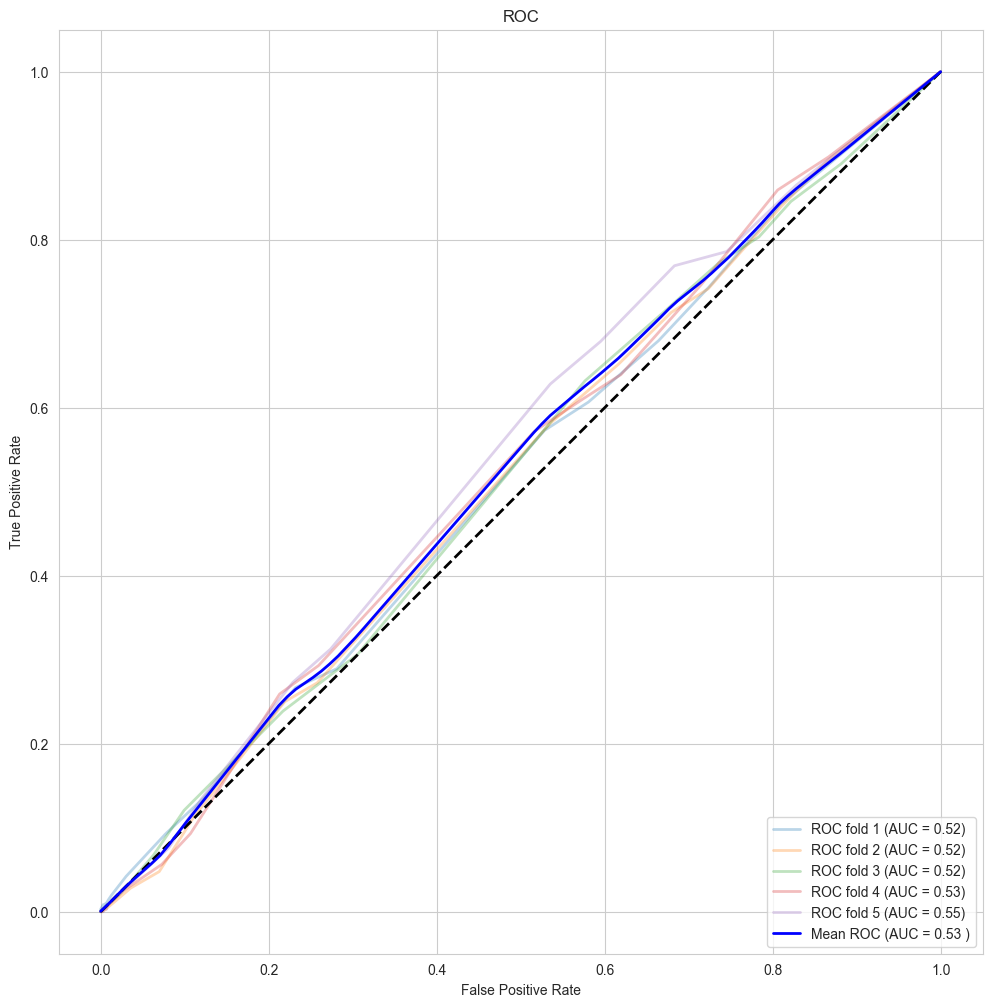

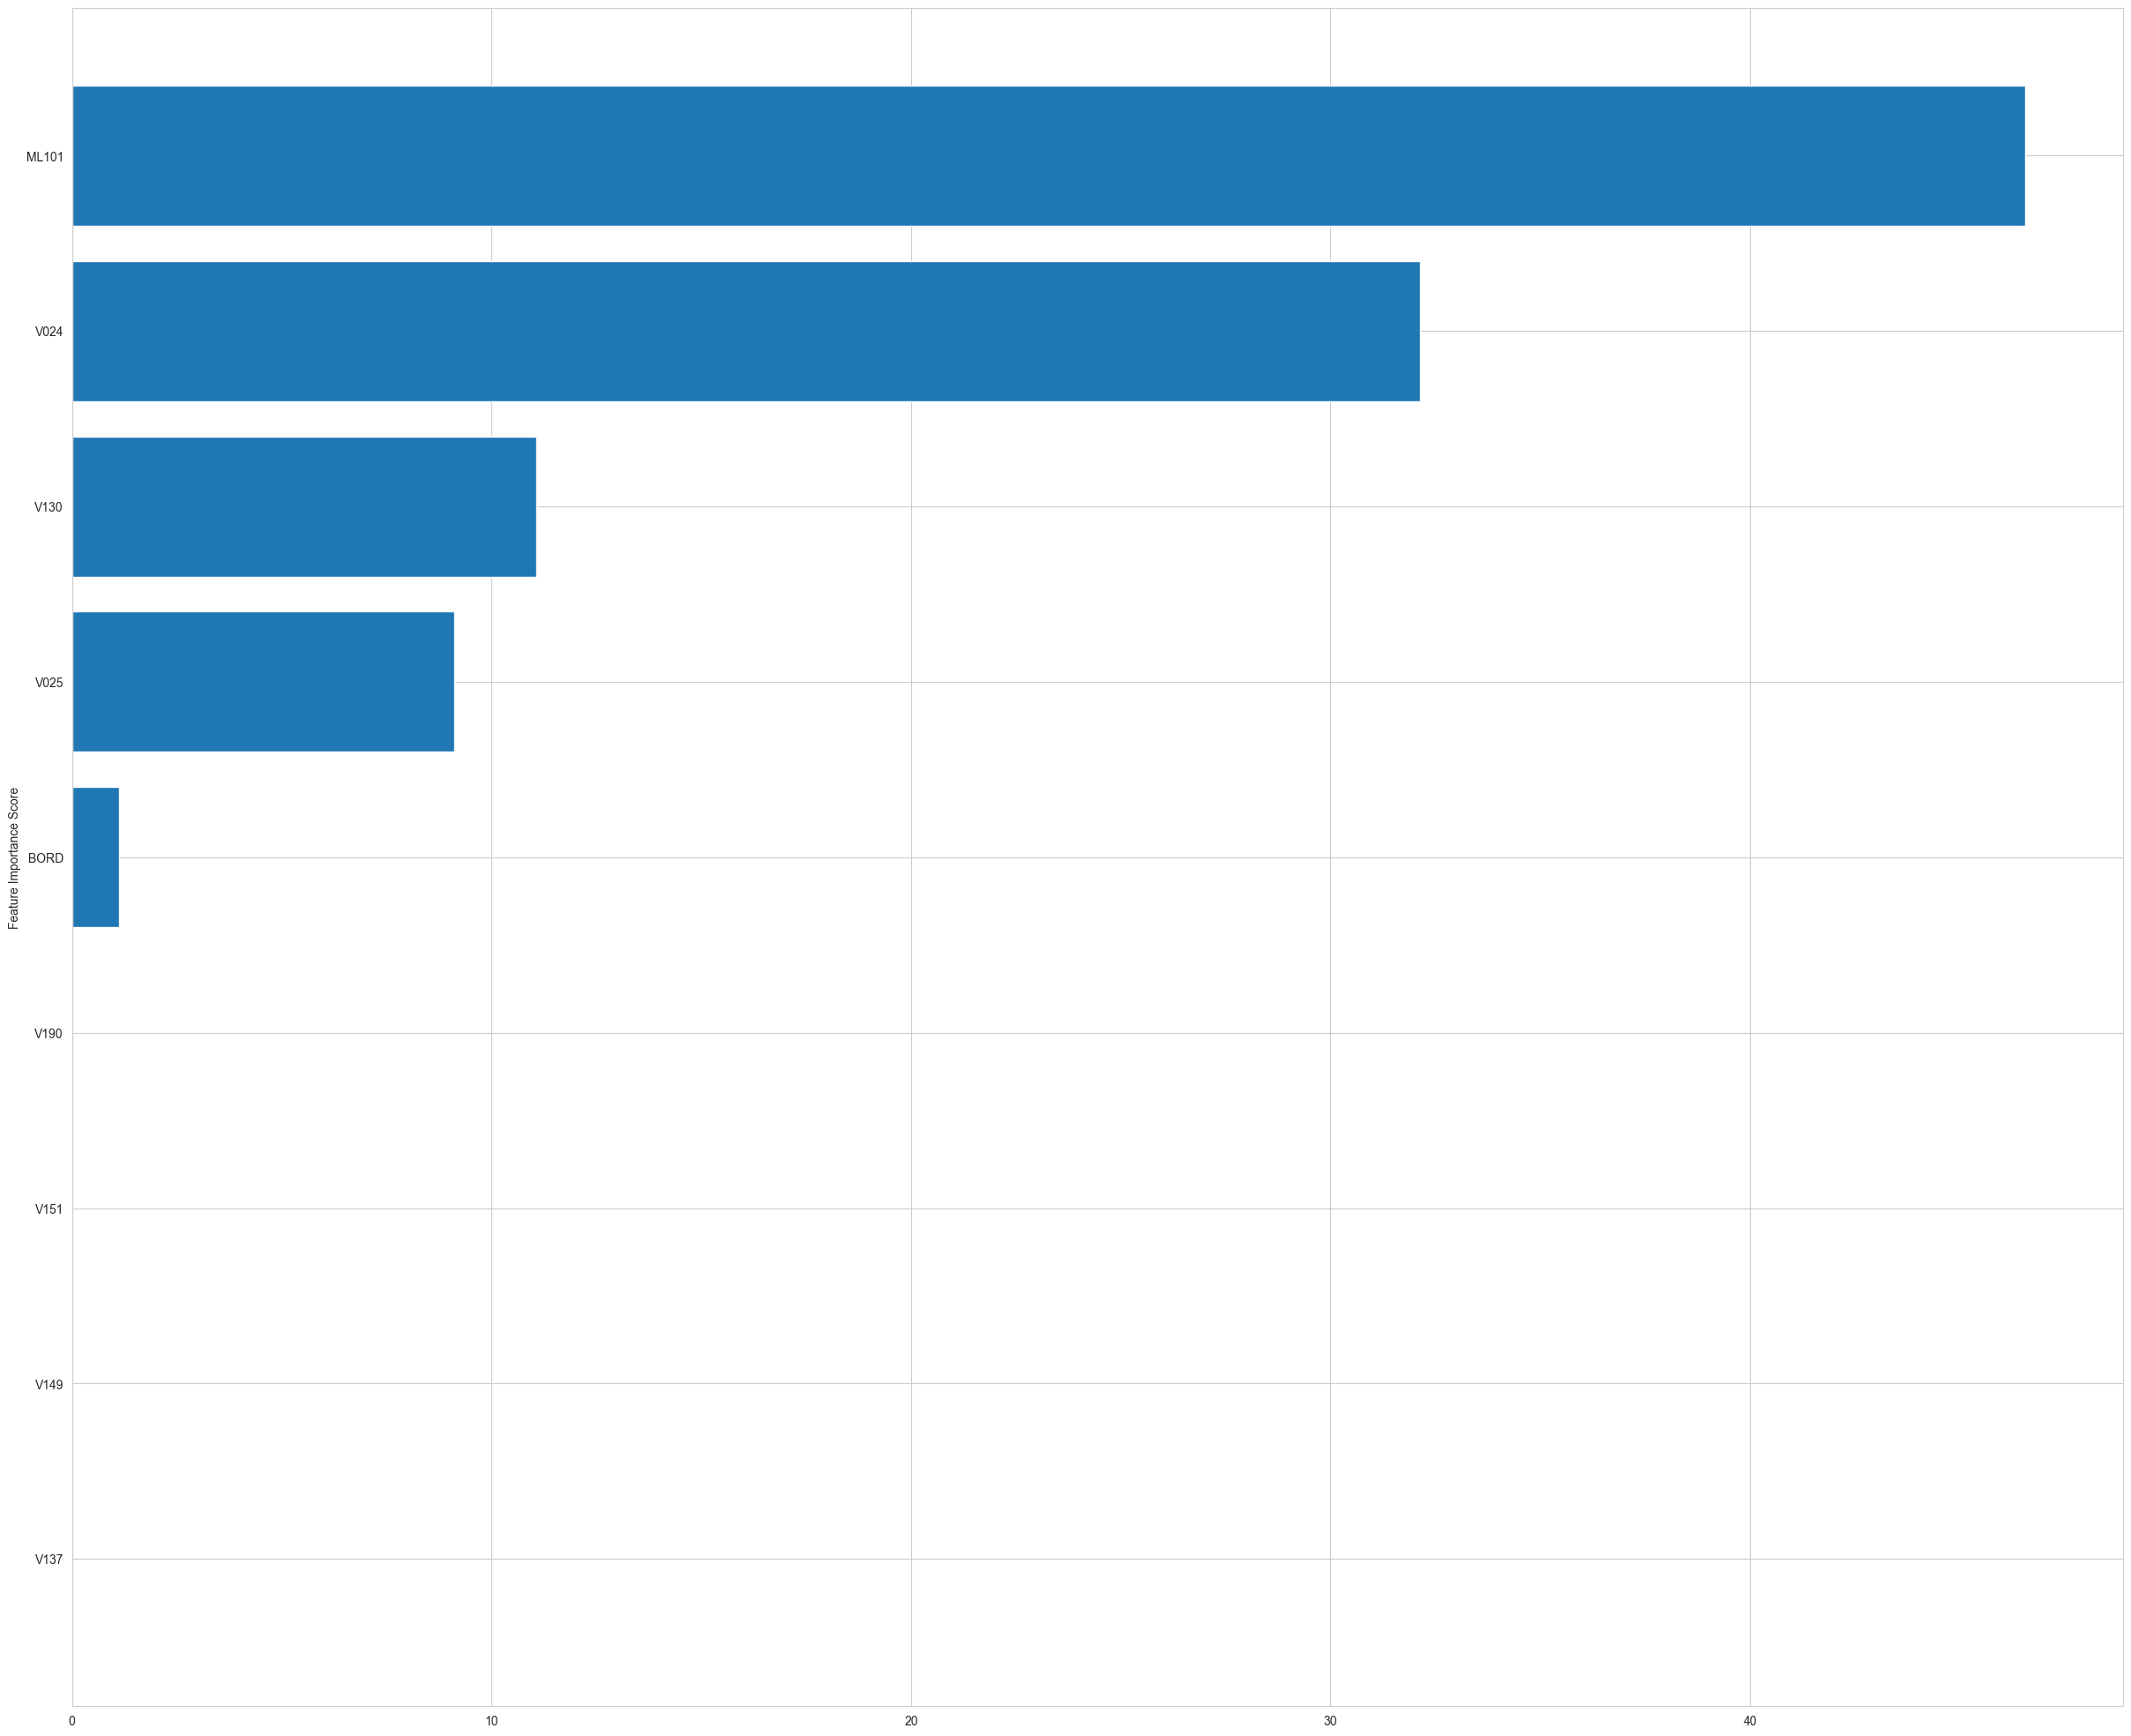

0.5373905748020731 0.5373905748020731 0.004562466471967144
================================Fold1====================================
[09:54:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.50000
[1]	validation_0-auc:0.49535
[2]	validation_0-auc:0.57016
[3]	validation_0-auc:0.58052
[4]	validation_0-auc:0.58937
[5]	validation_0-auc:0.59106
[6]	validation_0-auc:0.59017
[7]	validation_0-auc:0.59114
[8]	validation_0-auc:0.59312
[9]	validation_0-auc:0.59396
[10]	validation_0-auc:0.59409
[11]	validation_0-auc:0.59631
[12]	validation_0-auc:0.59528
[13]	validation_0-auc:0.59287
[14]	validation_0-auc:0.59306
[15]	validation_0-auc:0.59365
[16]	validation_0-auc:0.59423
[17]	validation_0-auc:0.59483
[18]	validation_0-auc:0.59488
[19]	validation_0-auc:0.59492
[20]	validation_0-auc:0.59301
[21]	validation_0-auc:0.59201
[22]	valid

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Training scores 0.7035804320728432 0.47940091238428867
================================Fold2====================================
[09:54:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.50000
[1]	validation_0-auc:0.49372
[2]	validation_0-auc:0.55672
[3]	validation_0-auc:0.56296
[4]	validation_0-auc:0.56378
[5]	validation_0-auc:0.57204
[6]	validation_0-auc:0.57755
[7]	validation_0-auc:0.57755
[8]	validation_0-auc:0.57639
[9]	validation_0-auc:0.57779
[10]	validation_0-auc:0.58006
[11]	validation_0-auc:0.57908
[12]	validation_0-auc:0.58103
[13]	validation_0-auc:0.58113
[14]	validation_0-auc:0.57998
[15]	validation_0-auc:0.57779
[16]	validation_0-auc:0.57454
[17]	validation_0-auc:0.57463
[18]	validation_0-auc:0.57609
[19]	validation_0-auc:0.57661
[20]	validation_0-auc:0.57749
[21]	validation_0-auc:0.57719
[22]	validatio

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or 

[41]	validation_0-auc:0.56693
[42]	validation_0-auc:0.56769
[43]	validation_0-auc:0.56778
[44]	validation_0-auc:0.56821
[45]	validation_0-auc:0.56838
[46]	validation_0-auc:0.56889
[47]	validation_0-auc:0.56845

Validation scores 0.5728014015106306 0.5130562621459678
Training scores 0.6668464740688136 0.49255965352896963
================================Fold4====================================
[09:54:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.50000
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.59284
[3]	validation_0-auc:0.59874
[4]	validation_0-auc:0.60680
[5]	validation_0-auc:0.60820
[6]	validation_0-auc:0.60898
[7]	validation_0-auc:0.60799
[8]	validation_0-auc:0.60613
[9]	validation_0-auc:0.60993
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.60869
[12]	validation_0-auc:0.61132
[13]	validation_0

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[11]	validation_0-auc:0.57992
[12]	validation_0-auc:0.57952
[13]	validation_0-auc:0.58180
[14]	validation_0-auc:0.58068
[15]	validation_0-auc:0.58051
[16]	validation_0-auc:0.58053
[17]	validation_0-auc:0.58085
[18]	validation_0-auc:0.58263
[19]	validation_0-auc:0.58234
[20]	validation_0-auc:0.58226
[21]	validation_0-auc:0.58146
[22]	validation_0-auc:0.57943
[23]	validation_0-auc:0.58098
[24]	validation_0-auc:0.58016
[25]	validation_0-auc:0.58096
[26]	validation_0-auc:0.58134
[27]	validation_0-auc:0.57979
[28]	validation_0-auc:0.58133
[29]	validation_0-auc:0.58152
[30]	validation_0-auc:0.58221
[31]	validation_0-auc:0.58061
[32]	validation_0-auc:0.58194
[33]	validation_0-auc:0.58150
[34]	validation_0-auc:0.58129
[35]	validation_0-auc:0.58237
[36]	validation_0-auc:0.58363
[37]	validation_0-auc:0.58331
[38]	validation_0-auc:0.58309
[39]	validation_0-auc:0.58052
[40]	validation_0-auc:0.57944
[41]	validation_0-auc:0.57900
[42]	validation_0-auc:0.57757
[43]	validation_0-auc:0.57630
[44]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


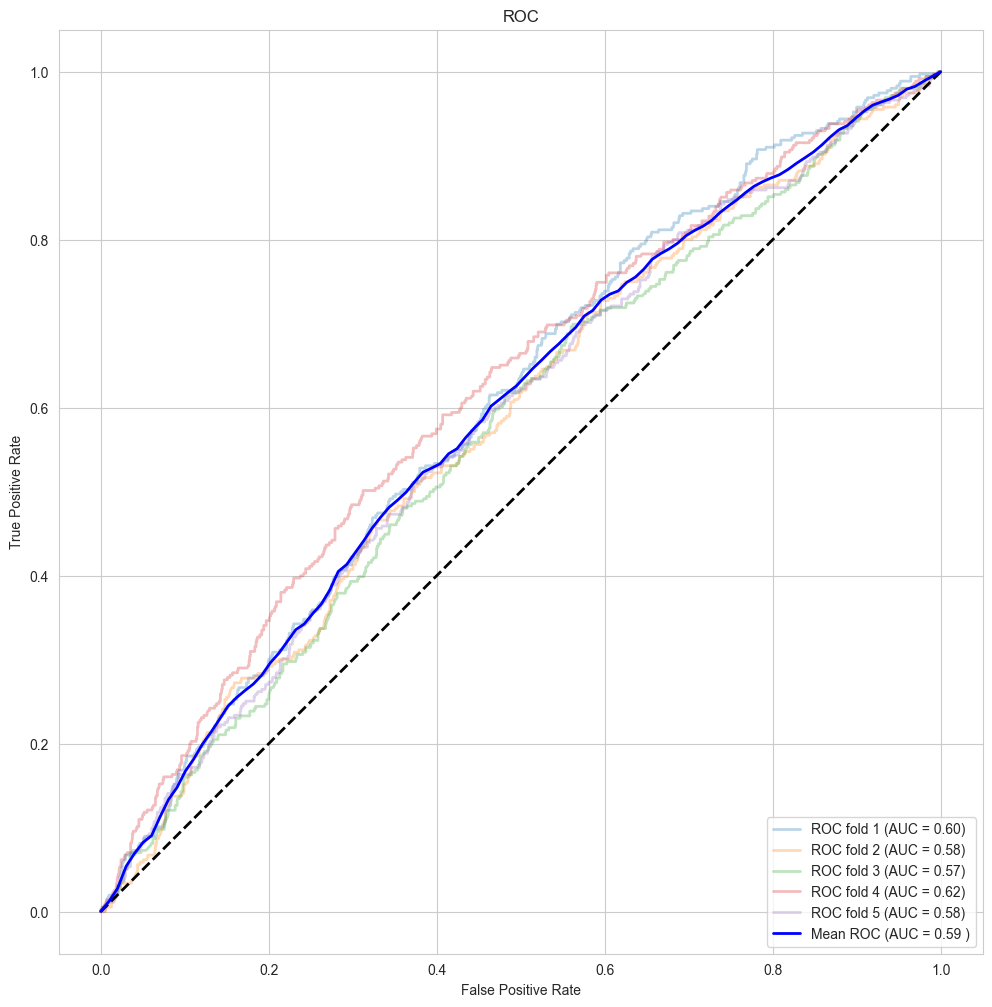

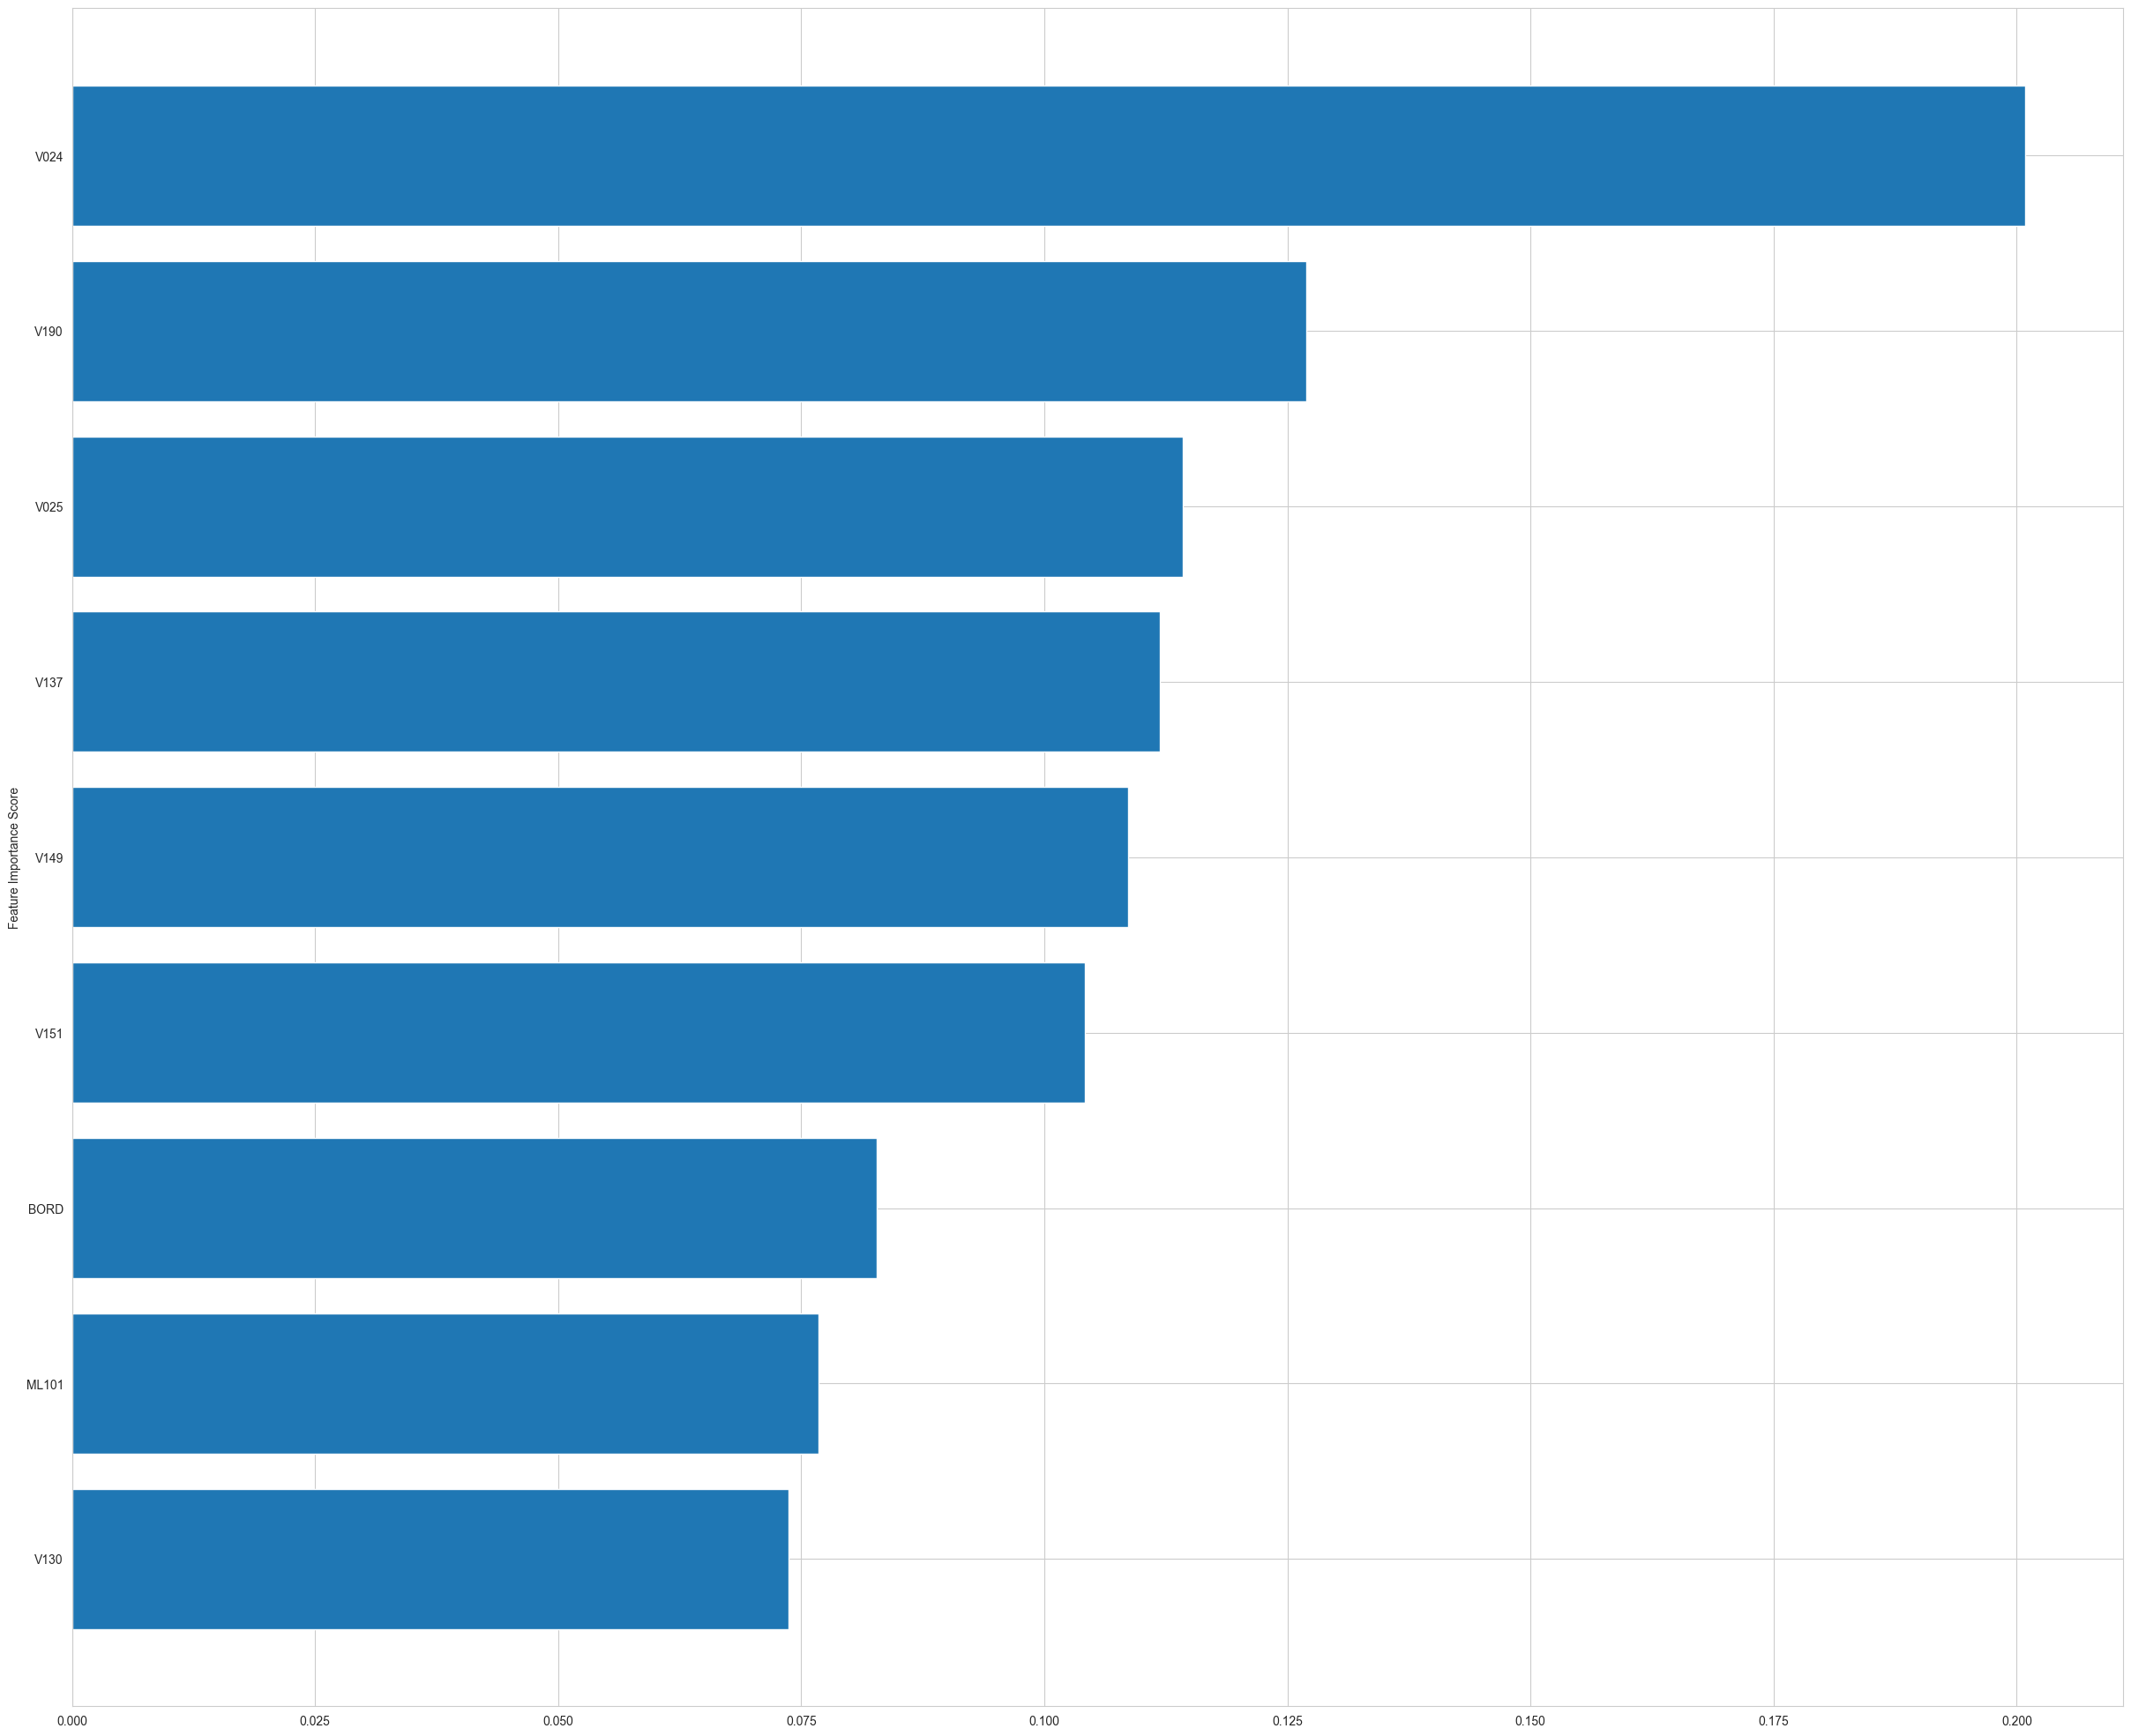

0.6811090954393795 0.6811090954393795 0.01816258664086279
================================Fold1====================================

Validation scores 0.5789551584022625 0.6425487447132592
Training scores 0.9912193626225663 0.18022457484882484
================================Fold2====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5401351040539735 0.8151812797509311
Training scores 0.9915971763953045 0.178123815750925
================================Fold3====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5514888919200014 0.6805344992496086
Training scores 0.9916594157232443 0.17726644952015494
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5780157823361701 0.7291294121558209
Training scores 0.9915295434183838 0.17799681001461518
================================Fold5====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5564747087528965 0.8639615454155176
Training scores 0.9923009595241347 0.17612399137147122


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


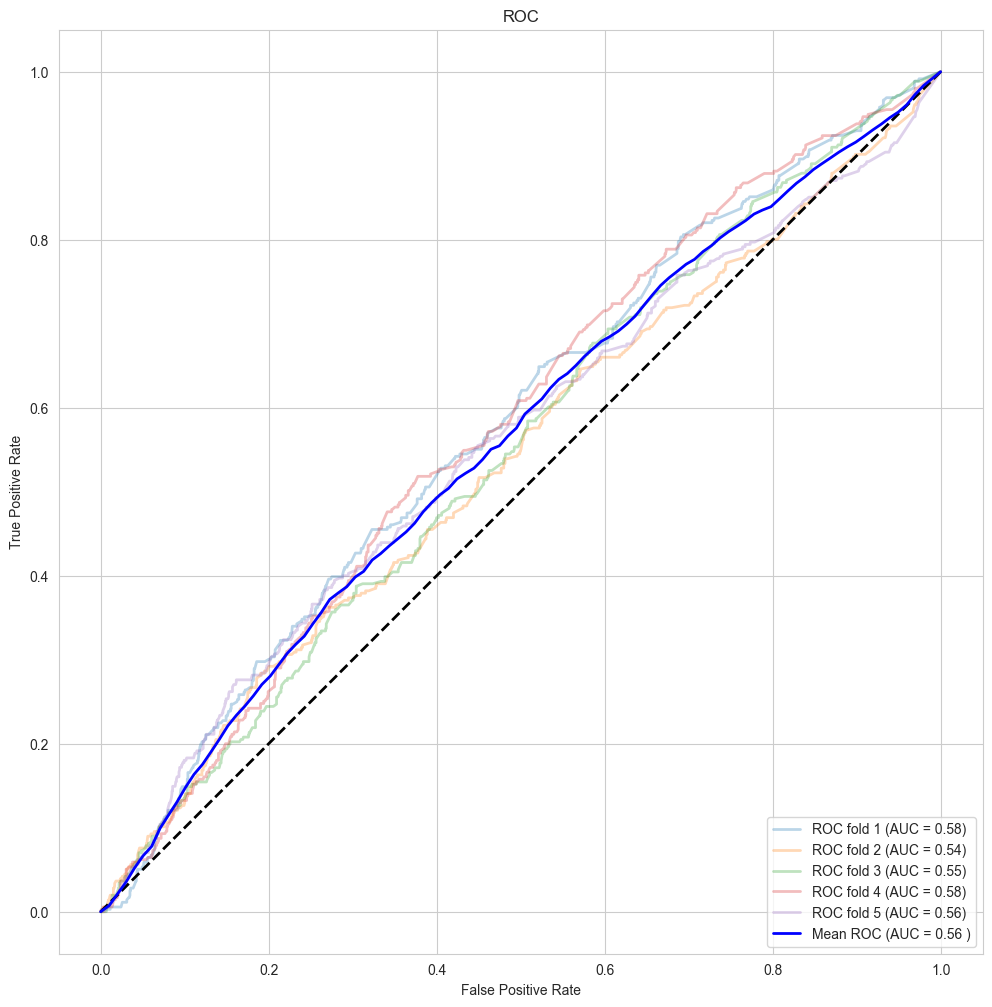

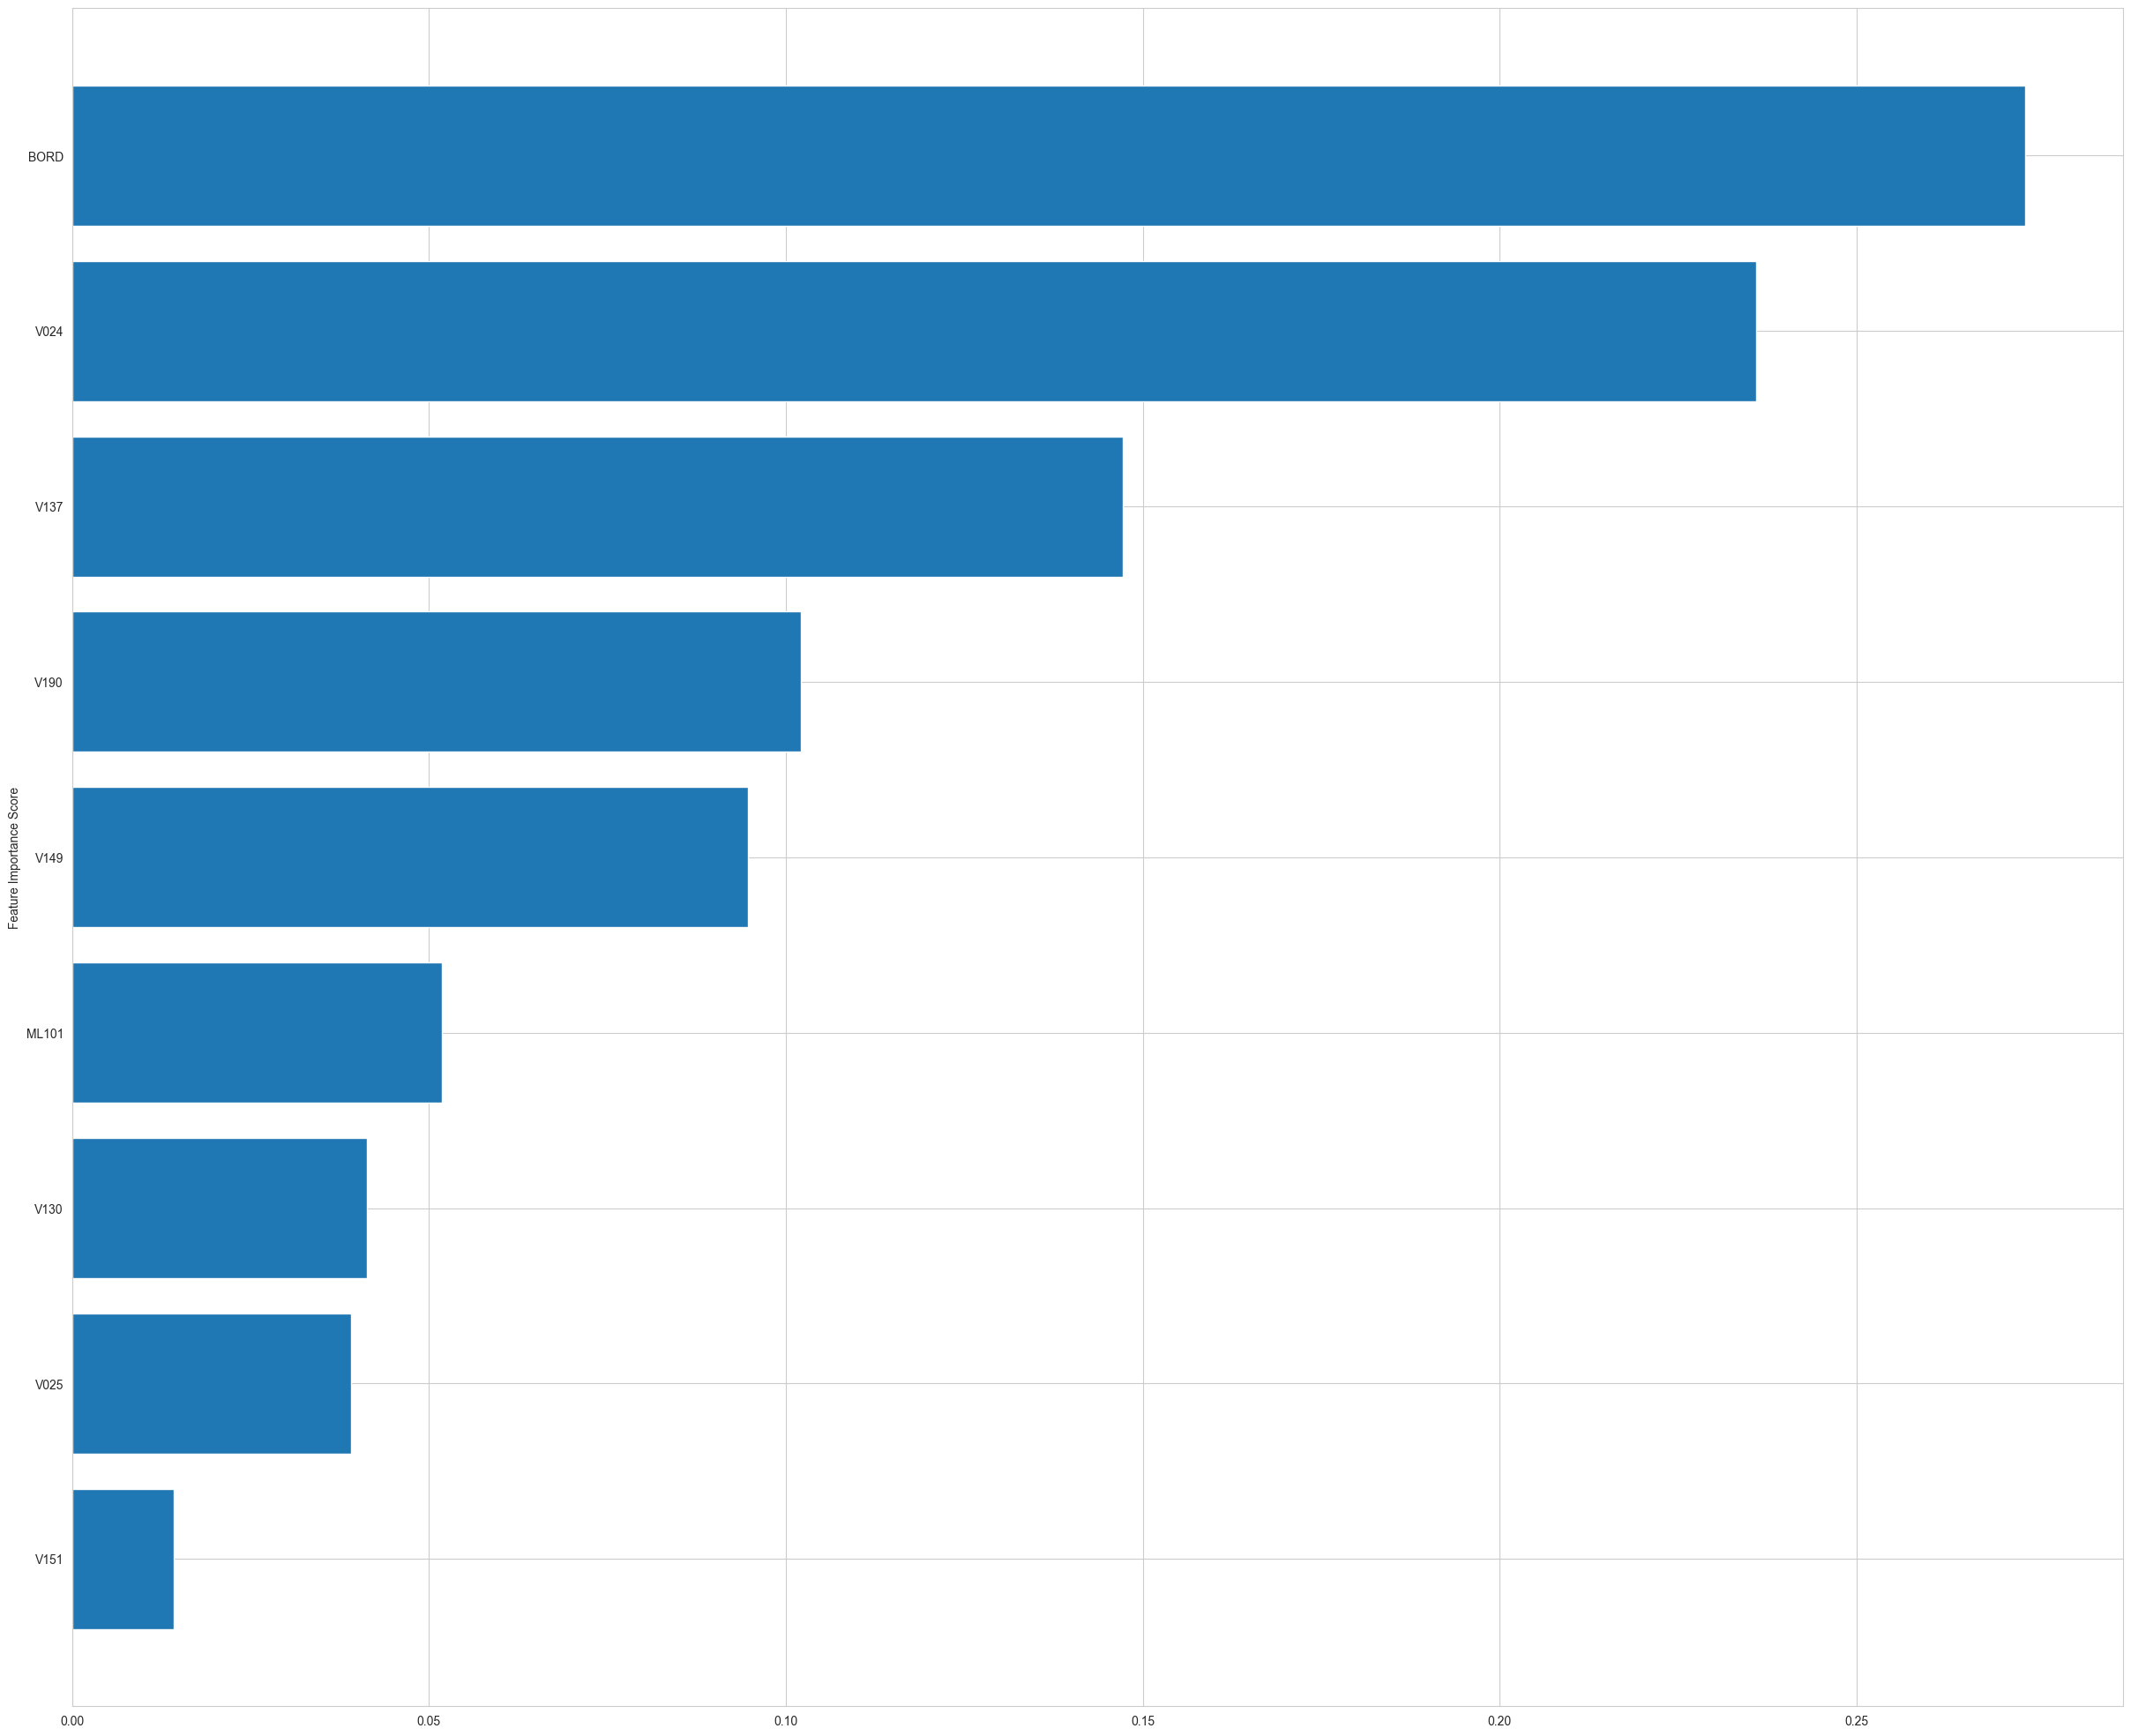

0.9916612915367269 0.9916612915367269 0.00035382146232478874
66/66 [==============================] - 0s 291us/step
3582    0
6795    0
4541    0
1542    1
2886    0
       ..
4923    0
410     0
4105    0
9432    0
6954    0
Name: HML32$01, Length: 2093, dtype: int64
Unique instance  (array([0, 1]), array([1648,  445])) (array([0]), array([2093]))
{'0': {'precision': 0.7873865265169613, 'recall': 1.0, 'f1-score': 0.8810478481689388, 'support': 1648}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 445}, 'accuracy': 0.7873865265169613, 'macro avg': {'precision': 0.39369326325848064, 'recall': 0.5, 'f1-score': 0.4405239240844694, 'support': 2093}, 'weighted avg': {'precision': 0.6199775421404453, 'recall': 0.7873865265169613, 'f1-score': 0.6937252048649838, 'support': 2093}}
Accuracy 0.7873865265169613
Precision 0.0
Recall 0.0
F1 Score 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

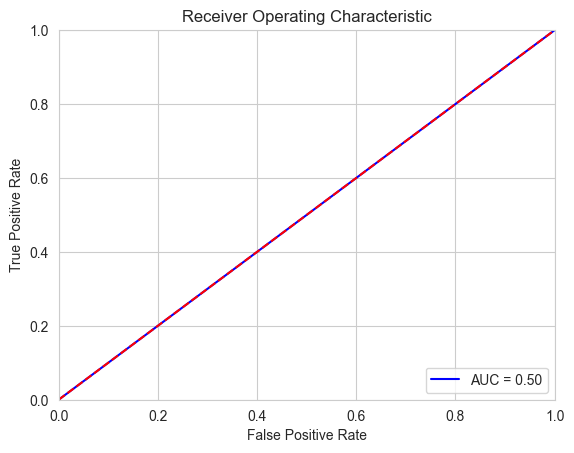

Normalized confusion matrix


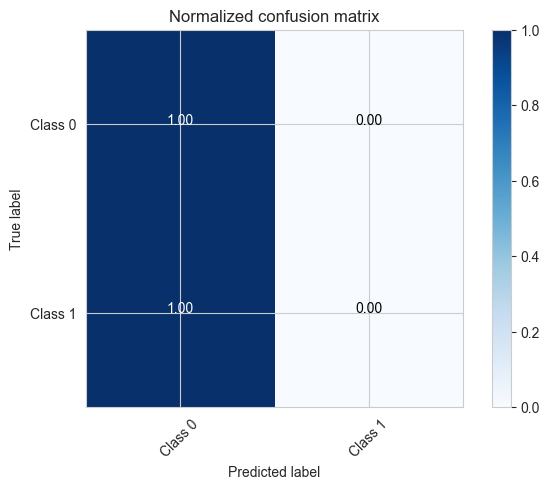

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([2089,    4]))
{'0': {'precision': 0.7874581139301101, 'recall': 0.9981796116504854, 'f1-score': 0.8803853358308804, 'support': 1648}, '1': {'precision': 0.25, 'recall': 0.0022471910112359553, 'f1-score': 0.0044543429844098, 'support': 445}, 'accuracy': 0.7864309603440038, 'macro avg': {'precision': 0.5187290569650551, 'recall': 0.5002134013308607, 'f1-score': 0.4424198394076451, 'support': 2093}, 'weighted avg': {'precision': 0.6731872774757867, 'recall': 0.7864309603440038, 'f1-score': 0.6941506049103456, 'support': 2093}}
Accuracy 0.7864309603440038
Precision 0.25
Recall 0.0022471910112359553
F1 Score 0.0044543429844098
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.25      0.00      0.00       445


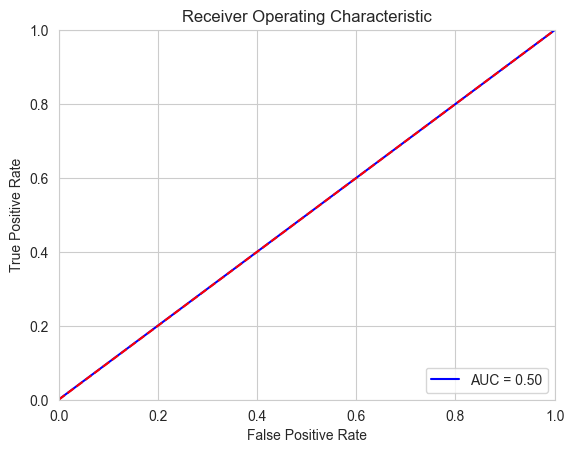

Normalized confusion matrix


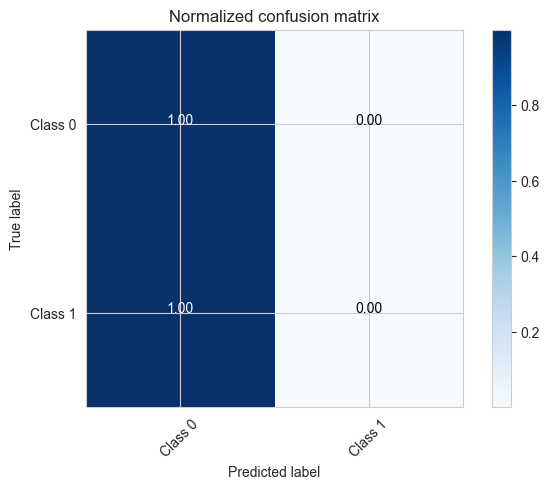

Metrics for the  Evaluation is {'accuracy': 0.7864309603440038, 'precision': 0.25, 'recall': 0.0022471910112359553, 'f1': 0.0044543429844098}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([2092,    1]))
{'0': {'precision': 0.7877629063097514, 'recall': 1.0, 'f1-score': 0.881283422459893, 'support': 1648}, '1': {'precision': 1.0, 'recall': 0.0022471910112359553, 'f1-score': 0.004484304932735426, 'support': 445}, 'accuracy': 0.78786430960344, 'macro avg': {'precision': 0.8938814531548758, 'recall': 0.501123595505618, 'f1-score': 0.4428838636963142, 'support': 2093}, 'weighted avg': {'precision': 0.8328873720011802, 'recall': 0.78786430960344, 'f1-score': 0.694864116535581, 'support': 2093}}
Accuracy 0.78786430960344
Precision 1.0
Recall 0.0022471910112359553
F1 Score 0.004484304932735426
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       1.00      0.00      0.0

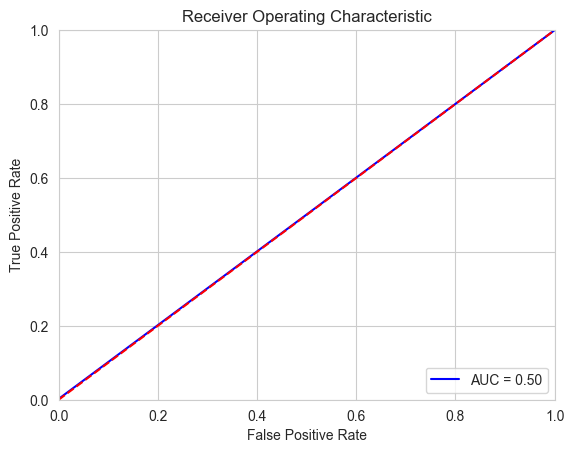

Normalized confusion matrix


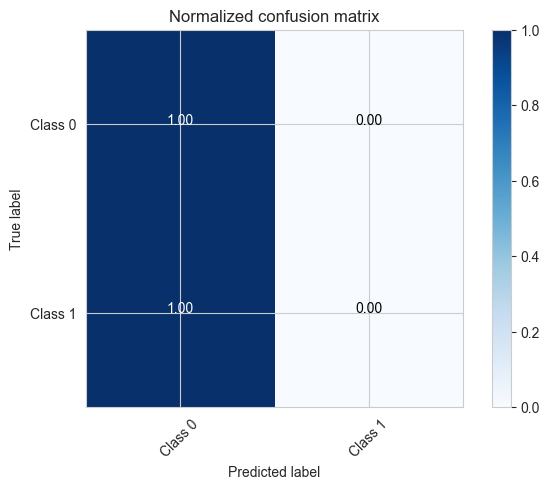

Metrics for the  Evaluation is {'accuracy': 0.78786430960344, 'precision': 1.0, 'recall': 0.0022471910112359553, 'f1': 0.004484304932735426}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0]), array([2093]))
{'0': {'precision': 0.7873865265169613, 'recall': 1.0, 'f1-score': 0.8810478481689388, 'support': 1648}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 445}, 'accuracy': 0.7873865265169613, 'macro avg': {'precision': 0.39369326325848064, 'recall': 0.5, 'f1-score': 0.4405239240844694, 'support': 2093}, 'weighted avg': {'precision': 0.6199775421404453, 'recall': 0.7873865265169613, 'f1-score': 0.6937252048649838, 'support': 2093}}
Accuracy 0.7873865265169613
Precision 0.0
Recall 0.0
F1 Score 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1648
           1       0.00      0.00      0.00       445

    accuracy                           0.79      2093
   macro avg      

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec

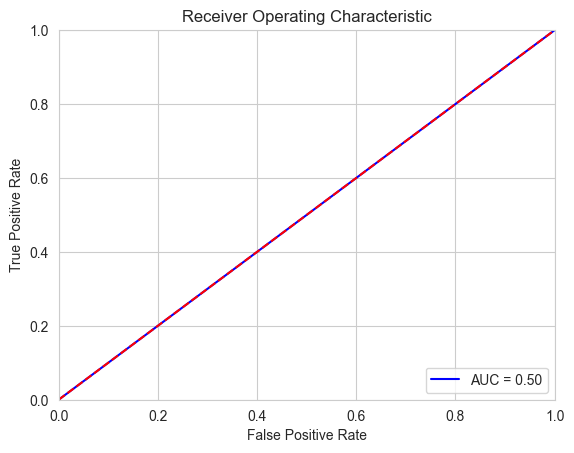

Normalized confusion matrix


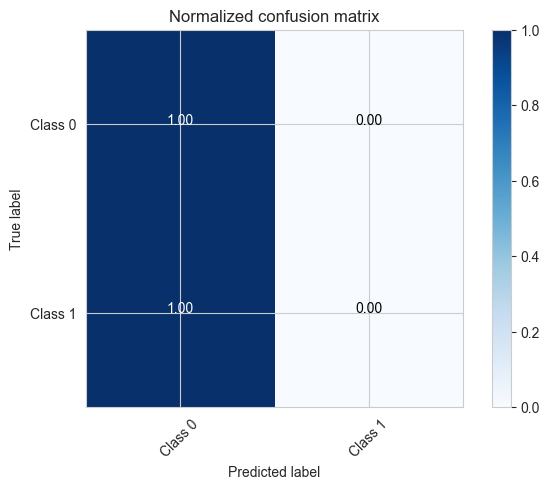

Metrics for the  Evaluation is {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Unique instance  (array([0, 1]), array([1648,  445])) (array([0, 1]), array([1903,  190]))
{'0': {'precision': 0.7961114030478192, 'recall': 0.9192961165048543, 'f1-score': 0.8532807659814136, 'support': 1648}, '1': {'precision': 0.3, 'recall': 0.12808988764044943, 'f1-score': 0.1795275590551181, 'support': 445}, 'accuracy': 0.7510750119445772, 'macro avg': {'precision': 0.5480557015239096, 'recall': 0.5236930020726519, 'f1-score': 0.5164041625182658, 'support': 2093}, 'weighted avg': {'precision': 0.6906314344112786, 'recall': 0.7510750119445772, 'f1-score': 0.7100317563864773, 'support': 2093}}
Accuracy 0.7510750119445772
Precision 0.3
Recall 0.12808988764044943
F1 Score 0.1795275590551181
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1648
           1       0.30      0.13      0.18       445

    a

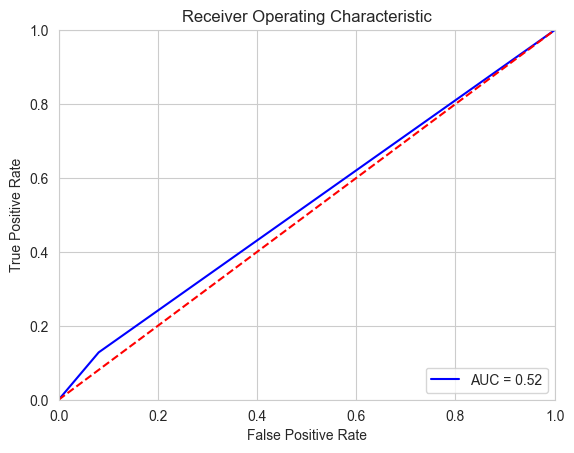

Normalized confusion matrix


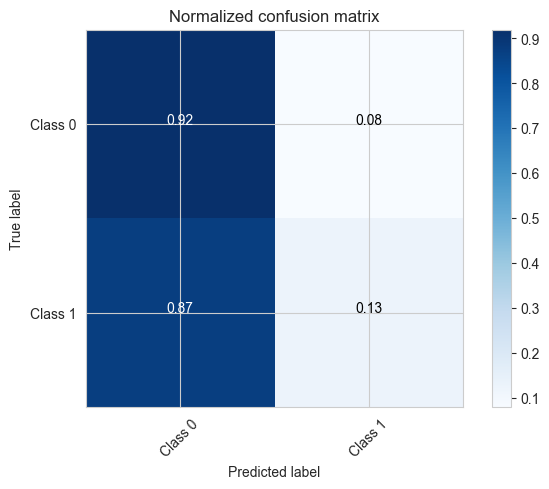

Metrics for the  Evaluation is {'accuracy': 0.7510750119445772, 'precision': 0.3, 'recall': 0.12808988764044943, 'f1': 0.1795275590551181}
{'catboost_result': {'accuracy': 0.7864309603440038, 'precision': 0.25, 'recall': 0.0022471910112359553, 'f1': 0.0044543429844098}, 'xgb': {'accuracy': 0.78786430960344, 'precision': 1.0, 'recall': 0.0022471910112359553, 'f1': 0.004484304932735426}, 'log': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'neural': {'accuracy': 0.7873865265169613, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'radom_forest': {'accuracy': 0.7510750119445772, 'precision': 0.3, 'recall': 0.12808988764044943, 'f1': 0.1795275590551181}}


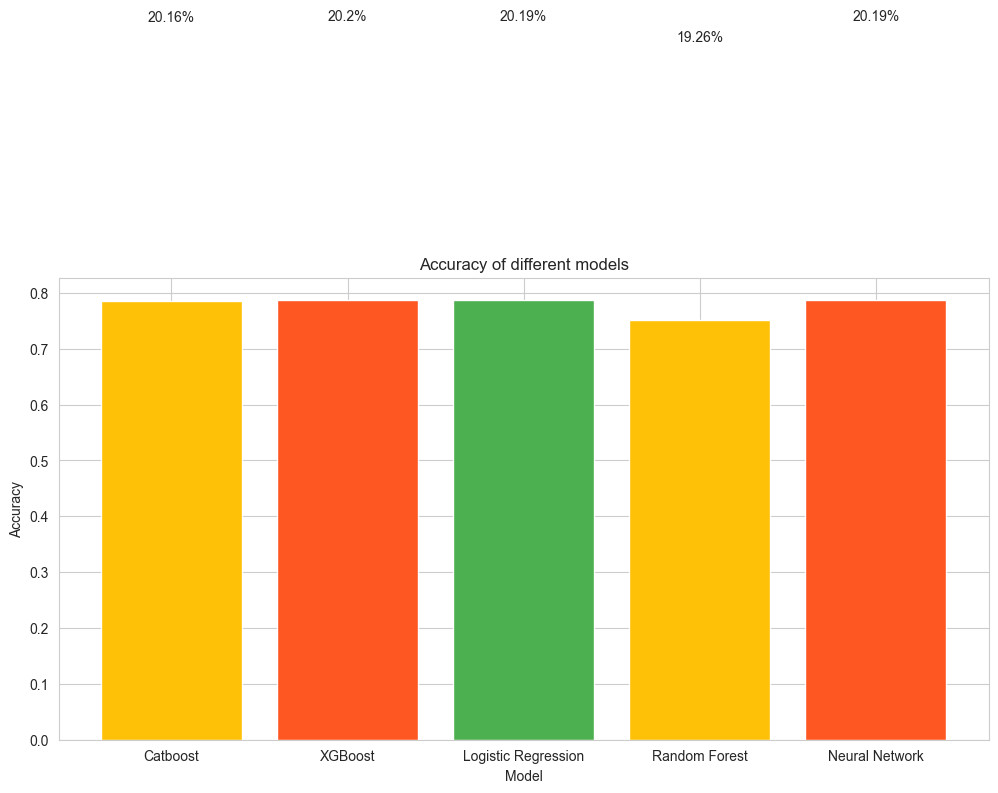

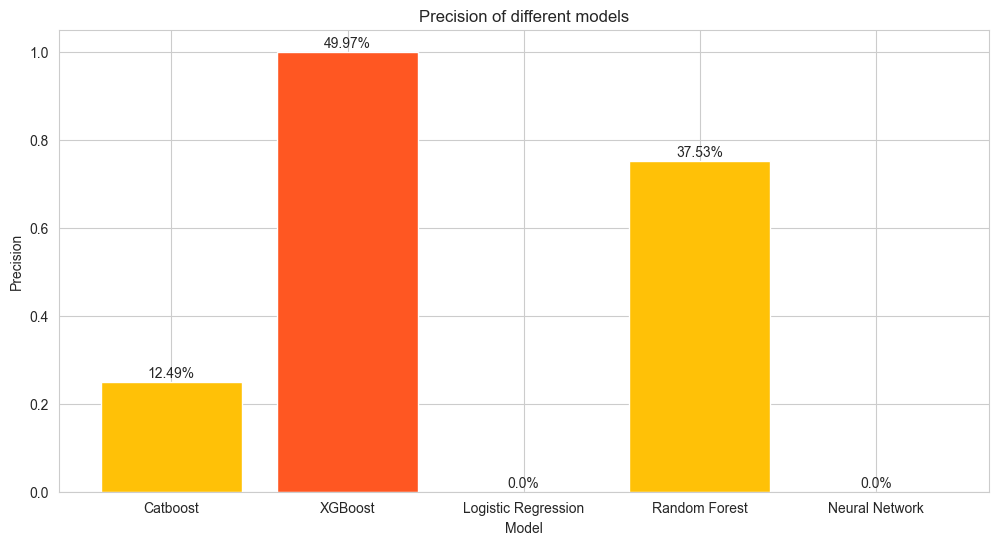

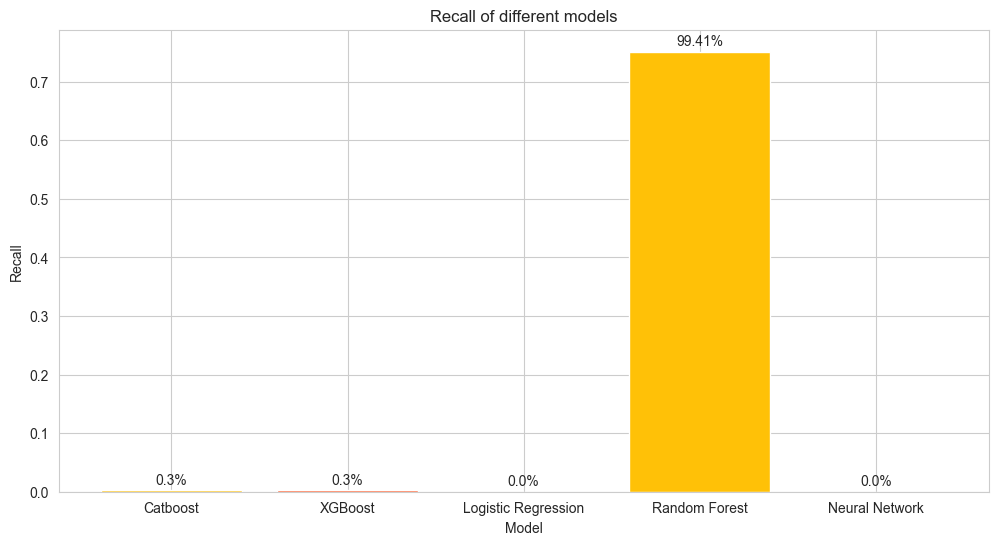

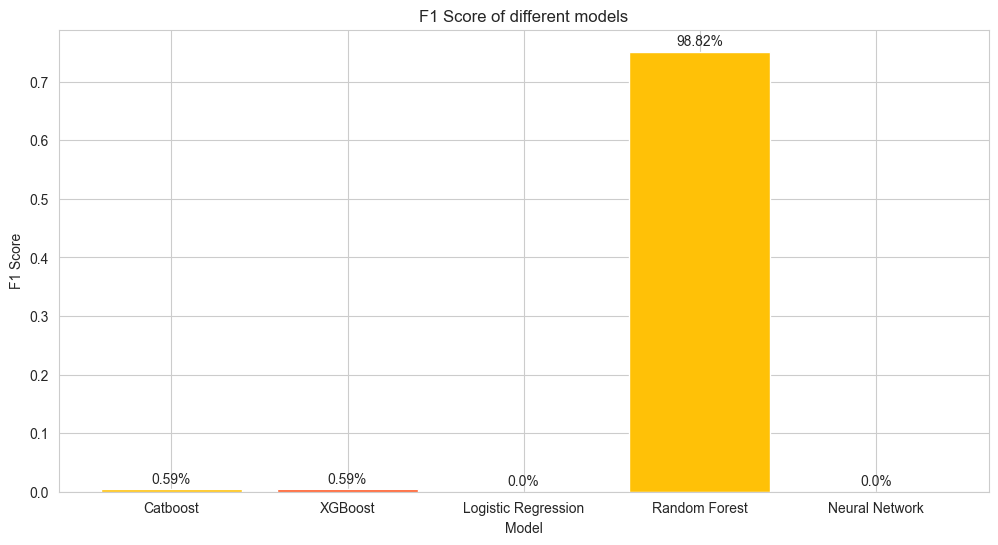

In [34]:
# Results  cross validation
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, stratify=Y_data)
with_cross_classifier,with_cross_catboost,with_cross_xgboost, with_cross_rad = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_out_cross_rad, with_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.5534294653116146 0.6903698789765055
Training scores 0.5637413619886162 0.6873048397649205
================================Fold2====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5697216456743197 0.6864384270019935
Training scores 0.5587297068512798 0.6882893146707084
================================Fold3====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5513574798584019 0.6911230793422103
Training scores 0.5648050875696444 0.6871011183094478
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5666113681100663 0.6867703556119721
Training scores 0.560242366523663 0.68815328826243
================================Fold5====================================

Validation scores 0.5563849699903707 0.6876049637837226
Training scores 0.5619197412457043 0.6880215423201609


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


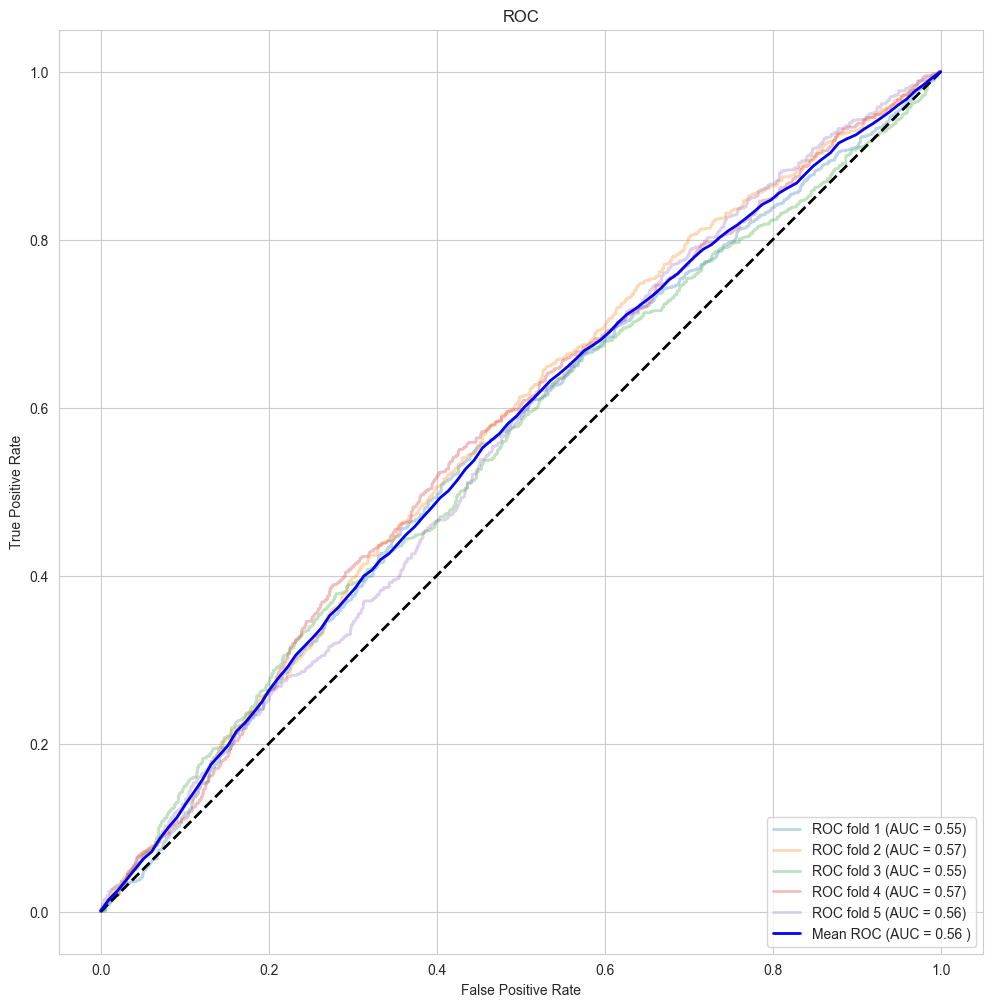

0.5618876528357816 0.5618876528357816 0.0022193820133352294
================================Fold1====================================
0:	learn: 0.5646746	test: 0.5625270	best: 0.5625270 (0)	total: 2.91ms	remaining: 29.1s
50:	learn: 0.5867356	test: 0.5692626	best: 0.5708245 (44)	total: 134ms	remaining: 26.2s
100:	learn: 0.6009143	test: 0.5801090	best: 0.5801090 (100)	total: 257ms	remaining: 25.2s
150:	learn: 0.6063540	test: 0.5812390	best: 0.5820431 (146)	total: 361ms	remaining: 23.6s
200:	learn: 0.6142956	test: 0.5830595	best: 0.5834478 (198)	total: 460ms	remaining: 22.4s
250:	learn: 0.6253920	test: 0.5909018	best: 0.5916813 (244)	total: 577ms	remaining: 22.4s
300:	learn: 0.6331007	test: 0.5973222	best: 0.5976911 (299)	total: 688ms	remaining: 22.2s
350:	learn: 0.6387560	test: 0.6045228	best: 0.6045228 (350)	total: 804ms	remaining: 22.1s
400:	learn: 0.6423489	test: 0.6051127	best: 0.6057317 (376)	total: 923ms	remaining: 22.1s
450:	learn: 0.6457846	test: 0.6078840	best: 0.6094234 (434)	t

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


50:	learn: 0.5895930	test: 0.5852146	best: 0.5859965 (48)	total: 133ms	remaining: 26s
100:	learn: 0.6003621	test: 0.5893894	best: 0.5924141 (96)	total: 254ms	remaining: 24.9s
150:	learn: 0.6062771	test: 0.5878459	best: 0.5924141 (96)	total: 372ms	remaining: 24.2s
200:	learn: 0.6146595	test: 0.5972276	best: 0.5980120 (199)	total: 494ms	remaining: 24.1s
250:	learn: 0.6208391	test: 0.5945072	best: 0.5987169 (211)	total: 612ms	remaining: 23.8s
300:	learn: 0.6262109	test: 0.6017652	best: 0.6029358 (295)	total: 730ms	remaining: 23.5s
350:	learn: 0.6338222	test: 0.6008990	best: 0.6039668 (337)	total: 849ms	remaining: 23.3s
400:	learn: 0.6411514	test: 0.6039340	best: 0.6050968 (398)	total: 968ms	remaining: 23.2s
450:	learn: 0.6450126	test: 0.6074041	best: 0.6080816 (425)	total: 1.1s	remaining: 23.3s
500:	learn: 0.6499771	test: 0.6108936	best: 0.6127573 (492)	total: 1.21s	remaining: 23s
550:	learn: 0.6544337	test: 0.6162152	best: 0.6169737 (544)	total: 1.32s	remaining: 22.6s
600:	learn: 0.65915

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.5938752	test: 0.5674694	best: 0.5685896 (97)	total: 233ms	remaining: 22.8s
150:	learn: 0.6047232	test: 0.5773836	best: 0.5773836 (150)	total: 336ms	remaining: 21.9s
200:	learn: 0.6130293	test: 0.5877059	best: 0.5877059 (200)	total: 427ms	remaining: 20.8s
250:	learn: 0.6222045	test: 0.5899538	best: 0.5923366 (242)	total: 543ms	remaining: 21.1s
300:	learn: 0.6304923	test: 0.5981835	best: 0.5988725 (298)	total: 645ms	remaining: 20.8s
350:	learn: 0.6370794	test: 0.6013108	best: 0.6031124 (314)	total: 744ms	remaining: 20.5s
400:	learn: 0.6455068	test: 0.6099530	best: 0.6099530 (400)	total: 856ms	remaining: 20.5s
450:	learn: 0.6494698	test: 0.6115603	best: 0.6138386 (436)	total: 976ms	remaining: 20.7s
500:	learn: 0.6545808	test: 0.6172025	best: 0.6180257 (484)	total: 1.1s	remaining: 20.8s
550:	learn: 0.6595153	test: 0.6172663	best: 0.6191950 (533)	total: 1.22s	remaining: 20.9s
600:	learn: 0.6617257	test: 0.6206937	best: 0.6213689 (594)	total: 1.33s	remaining: 20.8s
650:	learn: 

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


50:	learn: 0.5844048	test: 0.5740786	best: 0.5756285 (6)	total: 122ms	remaining: 23.8s
100:	learn: 0.5952775	test: 0.5819986	best: 0.5819986 (100)	total: 225ms	remaining: 22.1s
150:	learn: 0.6048379	test: 0.5837851	best: 0.5857529 (145)	total: 343ms	remaining: 22.4s
200:	learn: 0.6160274	test: 0.5876065	best: 0.5879924 (188)	total: 463ms	remaining: 22.6s
250:	learn: 0.6246519	test: 0.5871148	best: 0.5910009 (237)	total: 566ms	remaining: 22s
300:	learn: 0.6320509	test: 0.5962544	best: 0.5966565 (297)	total: 682ms	remaining: 22s
350:	learn: 0.6390015	test: 0.5978806	best: 0.5986274 (342)	total: 800ms	remaining: 22s
400:	learn: 0.6474913	test: 0.6012769	best: 0.6013006 (380)	total: 922ms	remaining: 22.1s
450:	learn: 0.6537052	test: 0.6092831	best: 0.6092934 (449)	total: 1.02s	remaining: 21.6s
500:	learn: 0.6583643	test: 0.6107788	best: 0.6111524 (493)	total: 1.13s	remaining: 21.5s
550:	learn: 0.6599469	test: 0.6104549	best: 0.6119536 (529)	total: 1.25s	remaining: 21.4s
600:	learn: 0.66385

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


50:	learn: 0.5833661	test: 0.5707517	best: 0.5744973 (1)	total: 130ms	remaining: 25.4s
100:	learn: 0.5999456	test: 0.5892635	best: 0.5892635 (100)	total: 251ms	remaining: 24.6s
150:	learn: 0.6064345	test: 0.5818020	best: 0.5892635 (100)	total: 370ms	remaining: 24.1s
200:	learn: 0.6158165	test: 0.5883289	best: 0.5906075 (195)	total: 484ms	remaining: 23.6s
250:	learn: 0.6199488	test: 0.5881773	best: 0.5909990 (210)	total: 599ms	remaining: 23.3s
300:	learn: 0.6284102	test: 0.5930760	best: 0.5949622 (288)	total: 717ms	remaining: 23.1s
350:	learn: 0.6339971	test: 0.5962685	best: 0.6007526 (321)	total: 845ms	remaining: 23.2s
400:	learn: 0.6401067	test: 0.6002624	best: 0.6009606 (389)	total: 967ms	remaining: 23.1s
450:	learn: 0.6434780	test: 0.5968557	best: 0.6021702 (415)	total: 1.09s	remaining: 23s
500:	learn: 0.6510574	test: 0.6006897	best: 0.6033186 (489)	total: 1.21s	remaining: 23s
550:	learn: 0.6542246	test: 0.6018556	best: 0.6033186 (489)	total: 1.33s	remaining: 22.8s
600:	learn: 0.657

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


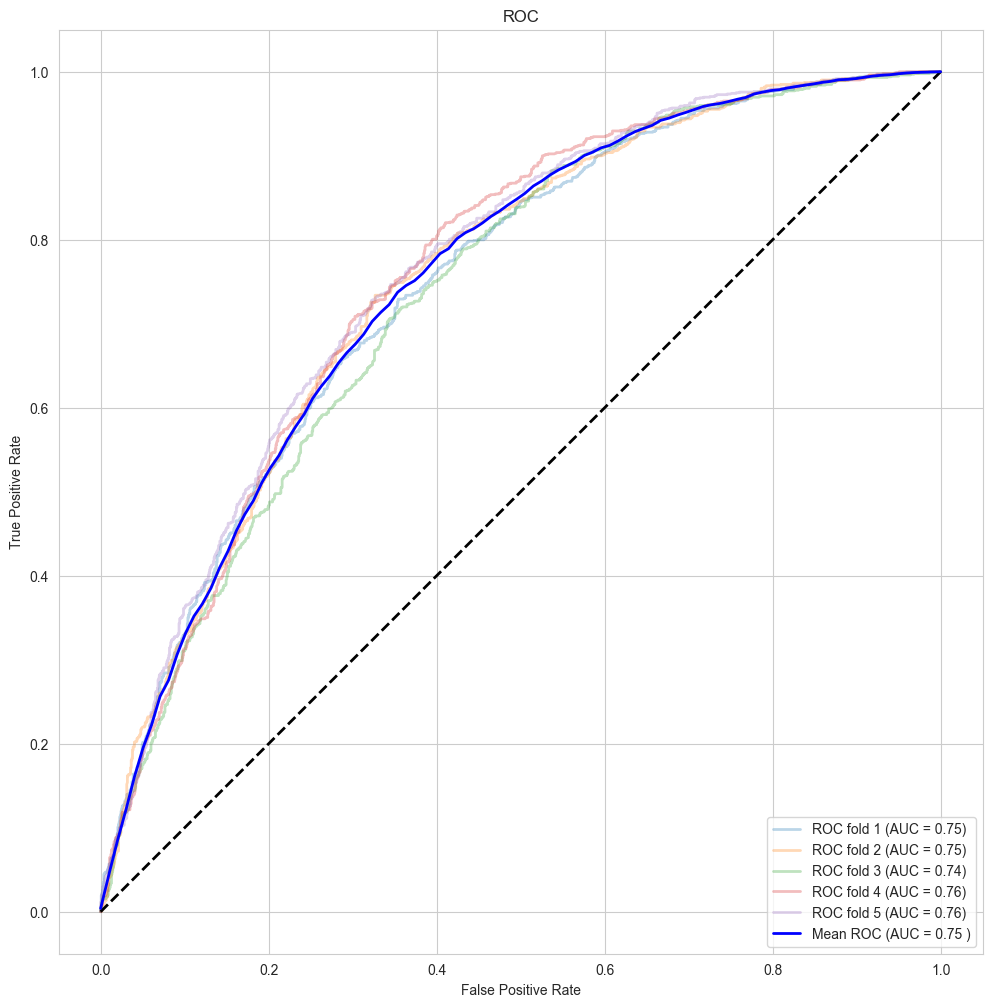

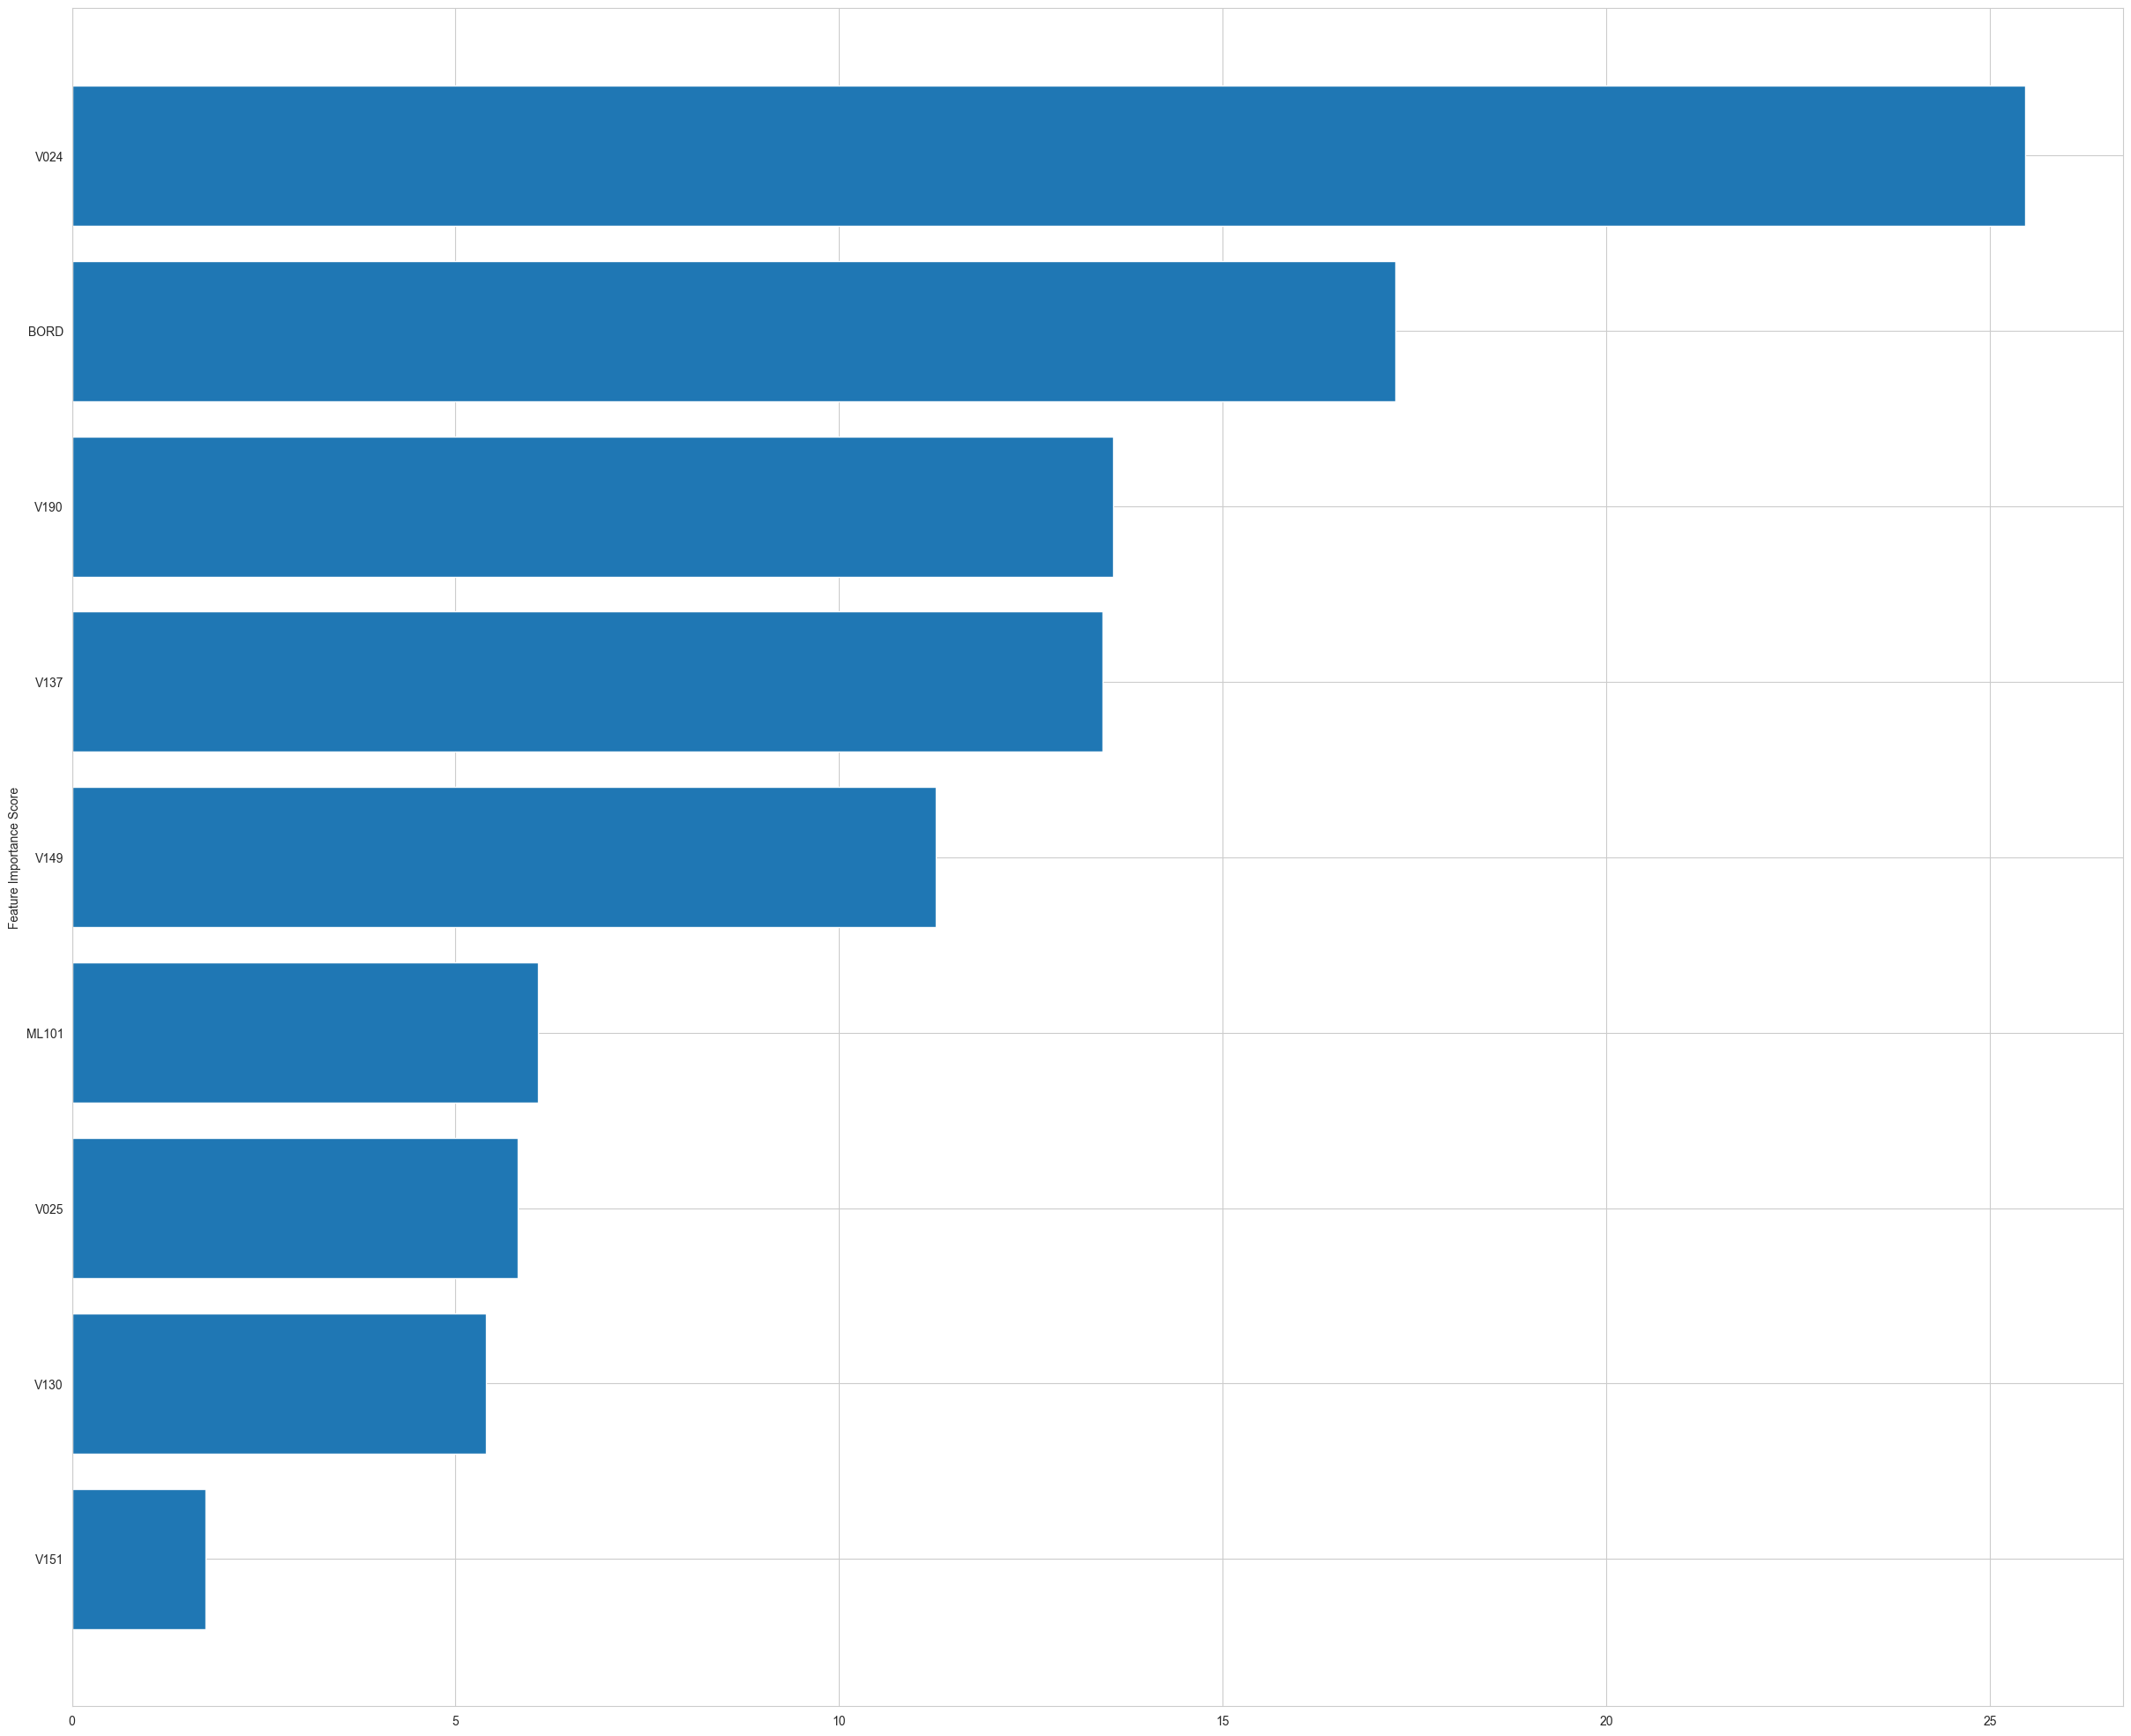

0.8774523595204761 0.8774523595204761 0.01524114864124836
================================Fold1====================================
[09:56:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.59267
[1]	validation_0-auc:0.58162
[2]	validation_0-auc:0.59587
[3]	validation_0-auc:0.59682
[4]	validation_0-auc:0.59836
[5]	validation_0-auc:0.60060
[6]	validation_0-auc:0.60481
[7]	validation_0-auc:0.61052
[8]	validation_0-auc:0.61127
[9]	validation_0-auc:0.61505
[10]	validation_0-auc:0.61839
[11]	validation_0-auc:0.62188
[12]	validation_0-auc:0.62423
[13]	validation_0-auc:0.62912
[14]	validation_0-auc:0.62988
[15]	validation_0-auc:0.63163
[16]	validation_0-auc:0.63366
[17]	validation_0-auc:0.63304
[18]	validation_0-auc:0.63537
[19]	validation_0-auc:0.63674
[20]	validation_0-auc:0.63857
[21]	validation_0-auc:0.64034
[22]	valida

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[81]	validation_0-auc:0.67725
[82]	validation_0-auc:0.67727
[83]	validation_0-auc:0.67885
[84]	validation_0-auc:0.67927
[85]	validation_0-auc:0.67983
[86]	validation_0-auc:0.68065
[87]	validation_0-auc:0.68075
[88]	validation_0-auc:0.68112
[89]	validation_0-auc:0.68131
[90]	validation_0-auc:0.68187
[91]	validation_0-auc:0.68198
[92]	validation_0-auc:0.68252
[93]	validation_0-auc:0.68333
[94]	validation_0-auc:0.68458
[95]	validation_0-auc:0.68472
[96]	validation_0-auc:0.68438
[97]	validation_0-auc:0.68475
[98]	validation_0-auc:0.68583
[99]	validation_0-auc:0.68681
[100]	validation_0-auc:0.68762
[101]	validation_0-auc:0.68741
[102]	validation_0-auc:0.68785
[103]	validation_0-auc:0.68833
[104]	validation_0-auc:0.68895
[105]	validation_0-auc:0.68994
[106]	validation_0-auc:0.69007
[107]	validation_0-auc:0.69107
[108]	validation_0-auc:0.69153
[109]	validation_0-auc:0.69207
[110]	validation_0-auc:0.69303
[111]	validation_0-auc:0.69343
[112]	validation_0-auc:0.69348
[113]	validation_0-auc:0.69

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[40]	validation_0-auc:0.66133
[41]	validation_0-auc:0.66137
[42]	validation_0-auc:0.66276
[43]	validation_0-auc:0.66425
[44]	validation_0-auc:0.66474
[45]	validation_0-auc:0.66670
[46]	validation_0-auc:0.66720
[47]	validation_0-auc:0.66764
[48]	validation_0-auc:0.66792
[49]	validation_0-auc:0.66766
[50]	validation_0-auc:0.66777
[51]	validation_0-auc:0.66861
[52]	validation_0-auc:0.66888
[53]	validation_0-auc:0.66933
[54]	validation_0-auc:0.66989
[55]	validation_0-auc:0.67032
[56]	validation_0-auc:0.67101
[57]	validation_0-auc:0.67147
[58]	validation_0-auc:0.67217
[59]	validation_0-auc:0.67208
[60]	validation_0-auc:0.67136
[61]	validation_0-auc:0.67125
[62]	validation_0-auc:0.67167
[63]	validation_0-auc:0.67244
[64]	validation_0-auc:0.67376
[65]	validation_0-auc:0.67435
[66]	validation_0-auc:0.67490
[67]	validation_0-auc:0.67453
[68]	validation_0-auc:0.67462
[69]	validation_0-auc:0.67513
[70]	validation_0-auc:0.67621
[71]	validation_0-auc:0.67725
[72]	validation_0-auc:0.67690
[73]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[37]	validation_0-auc:0.65487
[38]	validation_0-auc:0.65541
[39]	validation_0-auc:0.65555
[40]	validation_0-auc:0.65519
[41]	validation_0-auc:0.65614
[42]	validation_0-auc:0.65690
[43]	validation_0-auc:0.65704
[44]	validation_0-auc:0.65799
[45]	validation_0-auc:0.65816
[46]	validation_0-auc:0.65903
[47]	validation_0-auc:0.65900
[48]	validation_0-auc:0.66083
[49]	validation_0-auc:0.66186
[50]	validation_0-auc:0.66354
[51]	validation_0-auc:0.66362
[52]	validation_0-auc:0.66471
[53]	validation_0-auc:0.66565
[54]	validation_0-auc:0.66691
[55]	validation_0-auc:0.66810
[56]	validation_0-auc:0.66864
[57]	validation_0-auc:0.66873
[58]	validation_0-auc:0.66928
[59]	validation_0-auc:0.66920
[60]	validation_0-auc:0.66938
[61]	validation_0-auc:0.66966
[62]	validation_0-auc:0.67042
[63]	validation_0-auc:0.67082
[64]	validation_0-auc:0.67153
[65]	validation_0-auc:0.67164
[66]	validation_0-auc:0.67188
[67]	validation_0-auc:0.67246
[68]	validation_0-auc:0.67294
[69]	validation_0-auc:0.67347
[70]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[57]	validation_0-auc:0.66981
[58]	validation_0-auc:0.67023
[59]	validation_0-auc:0.67090
[60]	validation_0-auc:0.67065
[61]	validation_0-auc:0.67090
[62]	validation_0-auc:0.67109
[63]	validation_0-auc:0.67147
[64]	validation_0-auc:0.67217
[65]	validation_0-auc:0.67252
[66]	validation_0-auc:0.67261
[67]	validation_0-auc:0.67254
[68]	validation_0-auc:0.67322
[69]	validation_0-auc:0.67386
[70]	validation_0-auc:0.67483
[71]	validation_0-auc:0.67626
[72]	validation_0-auc:0.67622
[73]	validation_0-auc:0.67716
[74]	validation_0-auc:0.67795
[75]	validation_0-auc:0.67914
[76]	validation_0-auc:0.67931
[77]	validation_0-auc:0.68001
[78]	validation_0-auc:0.67986
[79]	validation_0-auc:0.68014
[80]	validation_0-auc:0.68096
[81]	validation_0-auc:0.68079
[82]	validation_0-auc:0.68105
[83]	validation_0-auc:0.68111
[84]	validation_0-auc:0.68175
[85]	validation_0-auc:0.68171
[86]	validation_0-auc:0.68223
[87]	validation_0-auc:0.68256
[88]	validation_0-auc:0.68330
[89]	validation_0-auc:0.68376
[90]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[49]	validation_0-auc:0.66259
[50]	validation_0-auc:0.66184
[51]	validation_0-auc:0.66300
[52]	validation_0-auc:0.66375
[53]	validation_0-auc:0.66439
[54]	validation_0-auc:0.66517
[55]	validation_0-auc:0.66545
[56]	validation_0-auc:0.66618
[57]	validation_0-auc:0.66640
[58]	validation_0-auc:0.66704
[59]	validation_0-auc:0.66725
[60]	validation_0-auc:0.66807
[61]	validation_0-auc:0.66843
[62]	validation_0-auc:0.66910
[63]	validation_0-auc:0.66874
[64]	validation_0-auc:0.66850
[65]	validation_0-auc:0.67003
[66]	validation_0-auc:0.67031
[67]	validation_0-auc:0.67088
[68]	validation_0-auc:0.67148
[69]	validation_0-auc:0.67163
[70]	validation_0-auc:0.67206
[71]	validation_0-auc:0.67222
[72]	validation_0-auc:0.67249
[73]	validation_0-auc:0.67348
[74]	validation_0-auc:0.67387
[75]	validation_0-auc:0.67405
[76]	validation_0-auc:0.67472
[77]	validation_0-auc:0.67551
[78]	validation_0-auc:0.67559
[79]	validation_0-auc:0.67561
[80]	validation_0-auc:0.67575
[81]	validation_0-auc:0.67587
[82]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


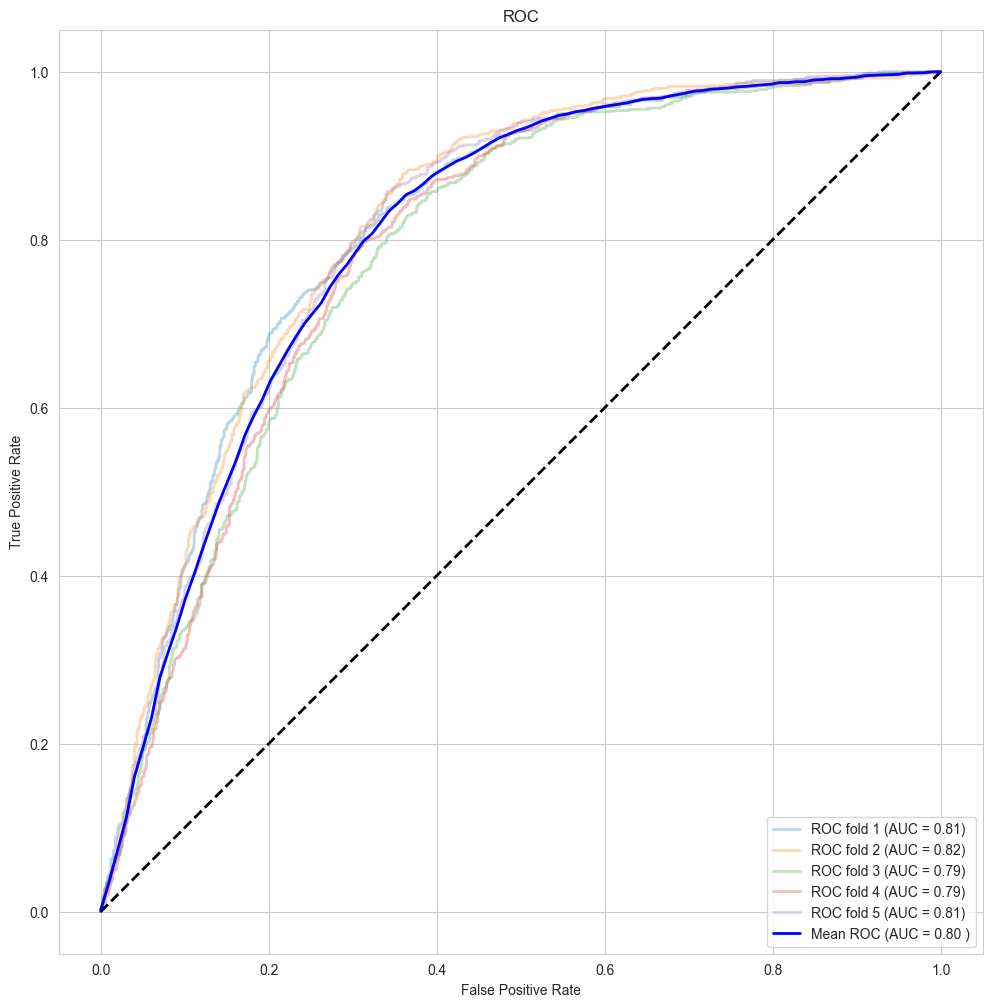

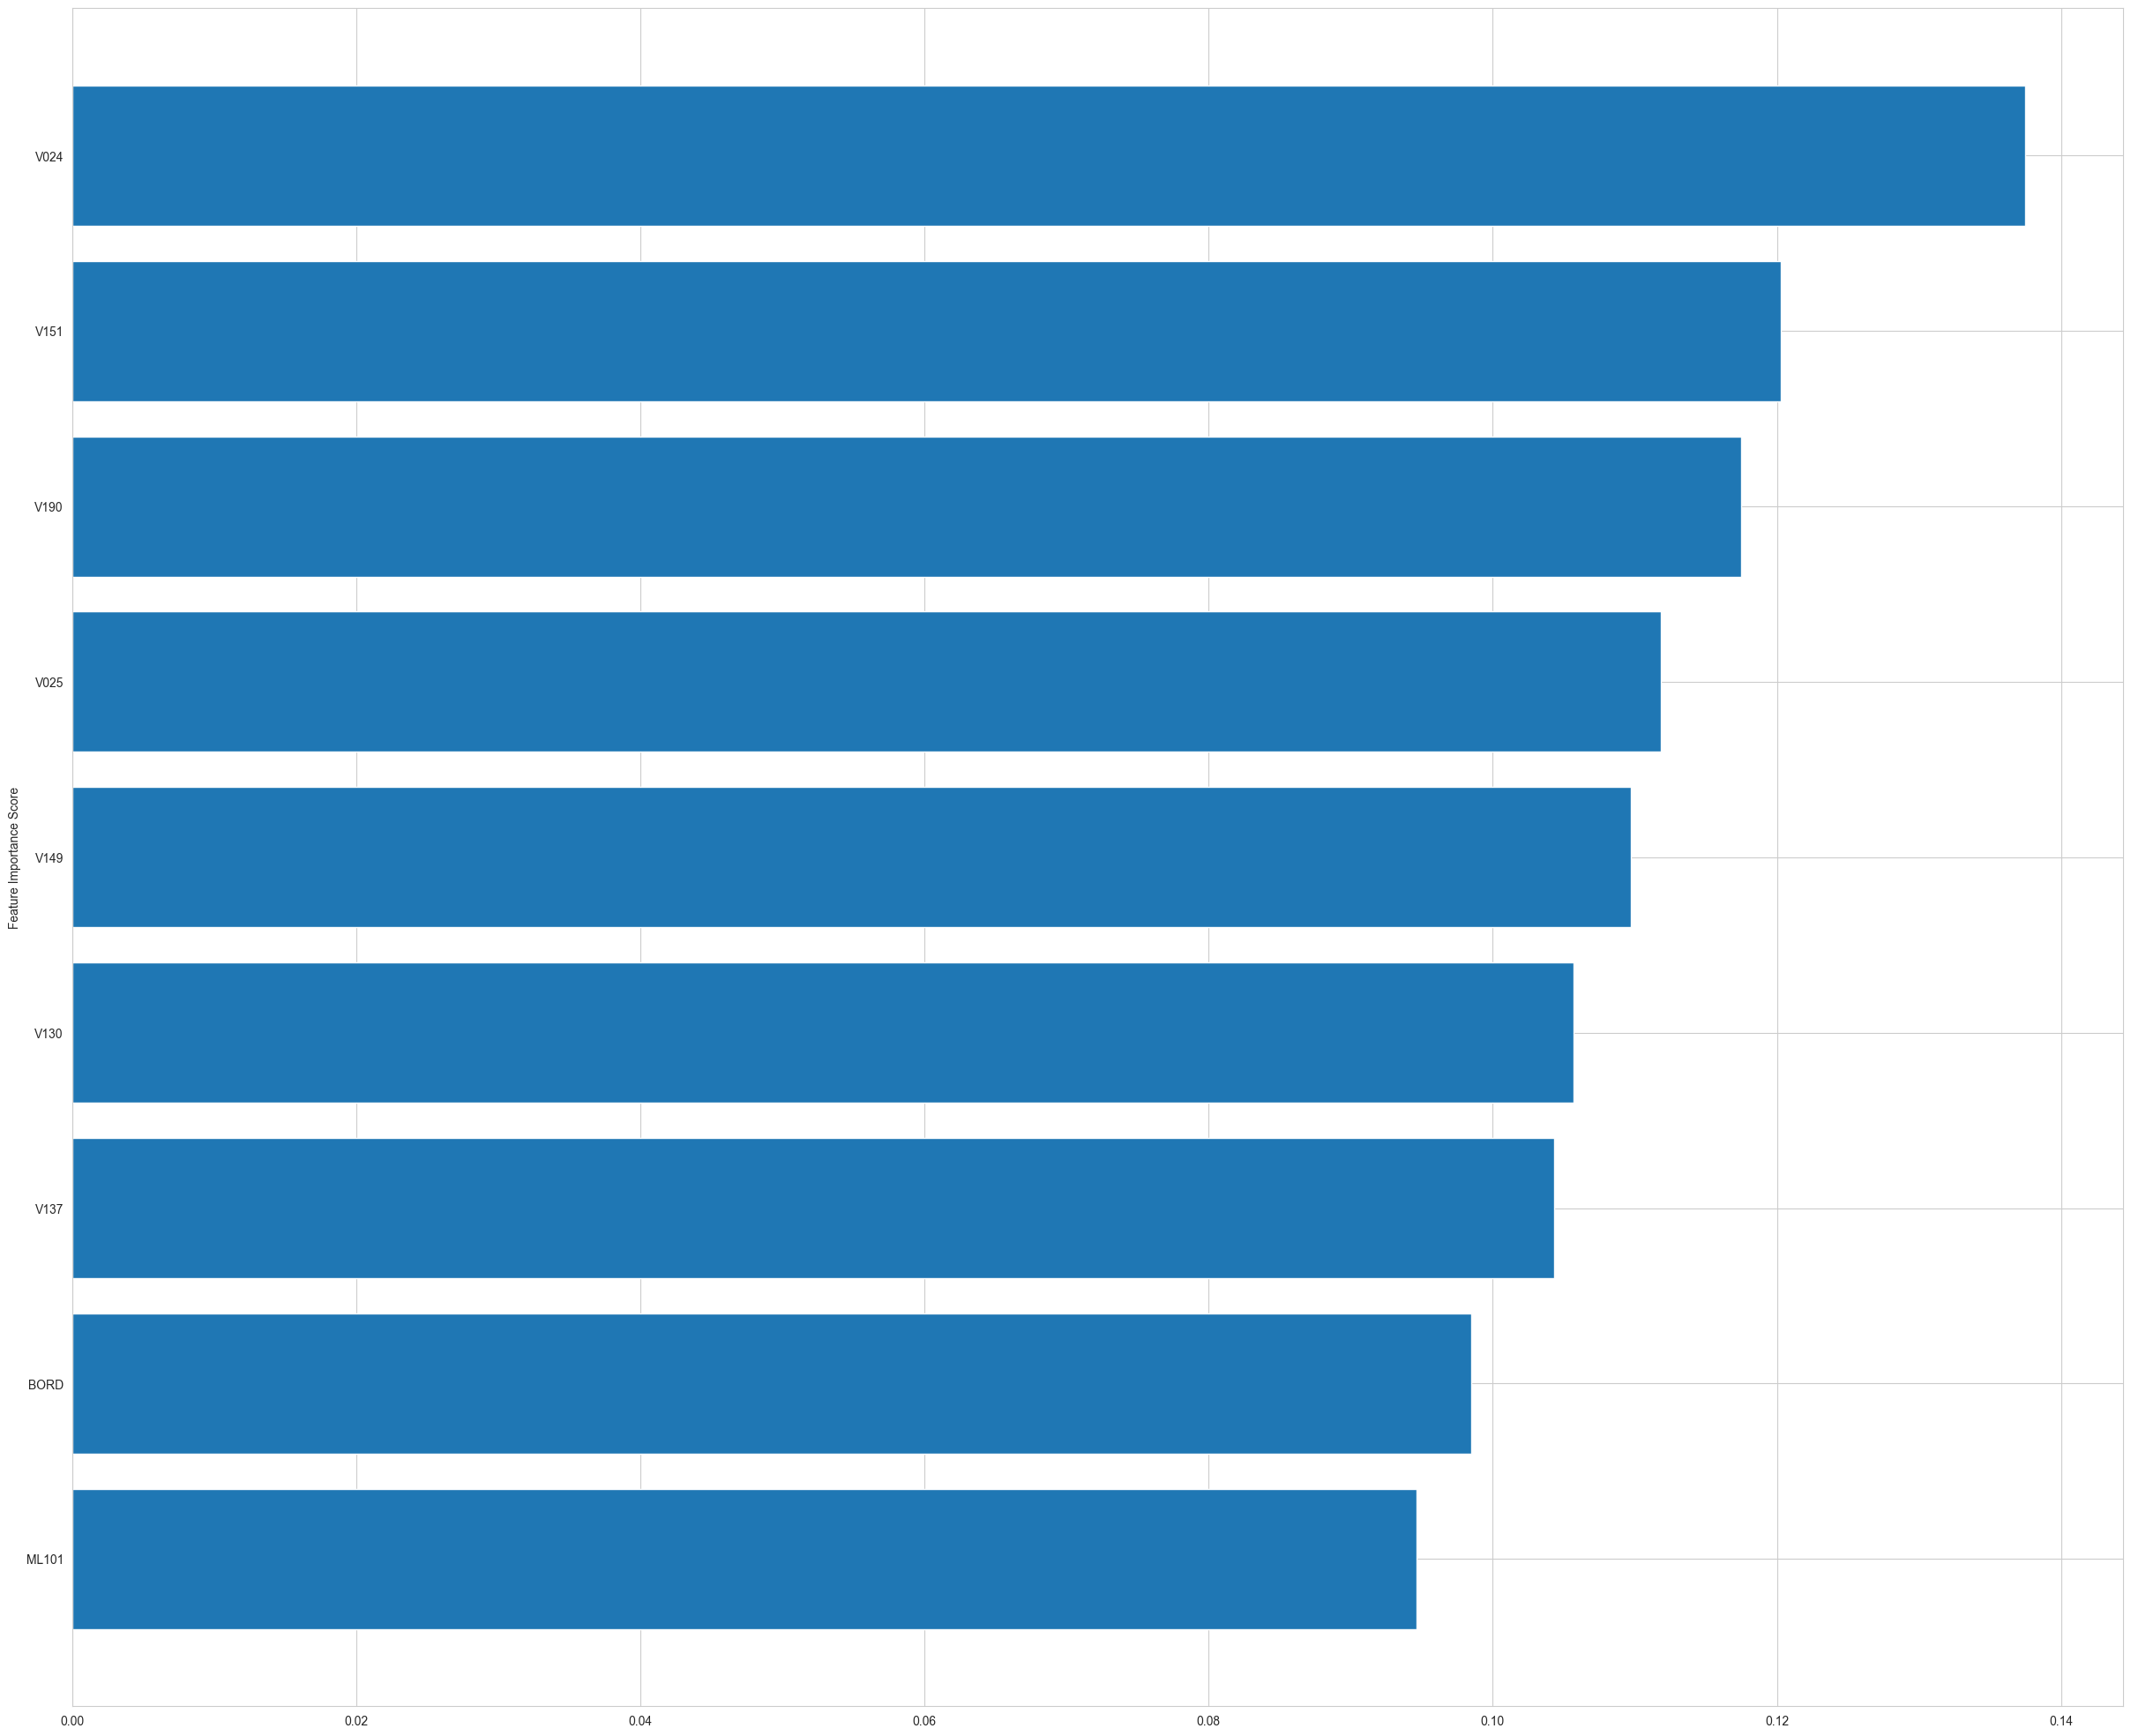

0.9464247482294958 0.9464247482294958 0.008107900696468722
================================Fold1====================================

Validation scores 0.8948864240547982 0.530010090499995
Training scores 0.9900849378242905 0.17230783995350954
================================Fold2====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.8929347191941881 0.6460189850972967
Training scores 0.9905682710677616 0.16996268470796602
================================Fold3====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.8954676083527665 0.6982560815513378
Training scores 0.9899127329543445 0.1730286099157226
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.893019726858877 0.59382526460865
Training scores 0.9900377799240807 0.1723908056161198
================================Fold5====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.9050324946129925 0.5413289053977033
Training scores 0.9896364951371263 0.17511397870098871


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


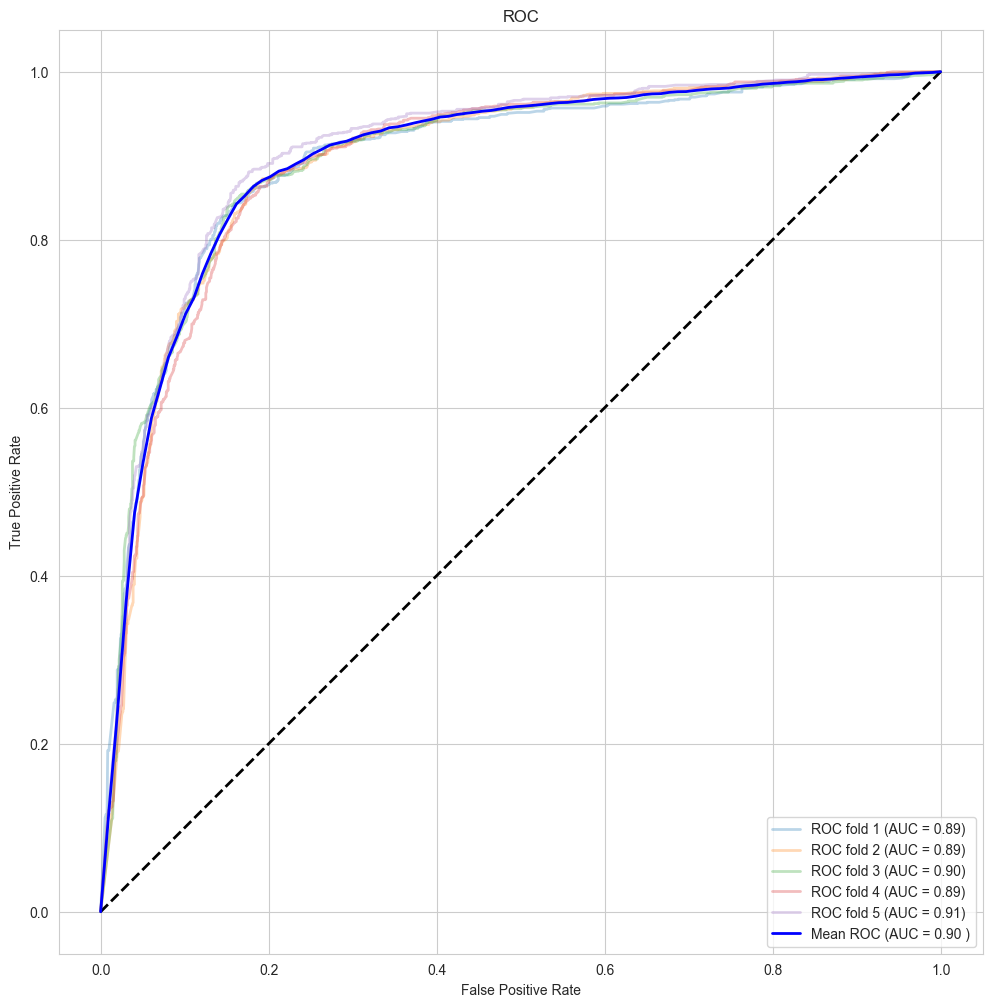

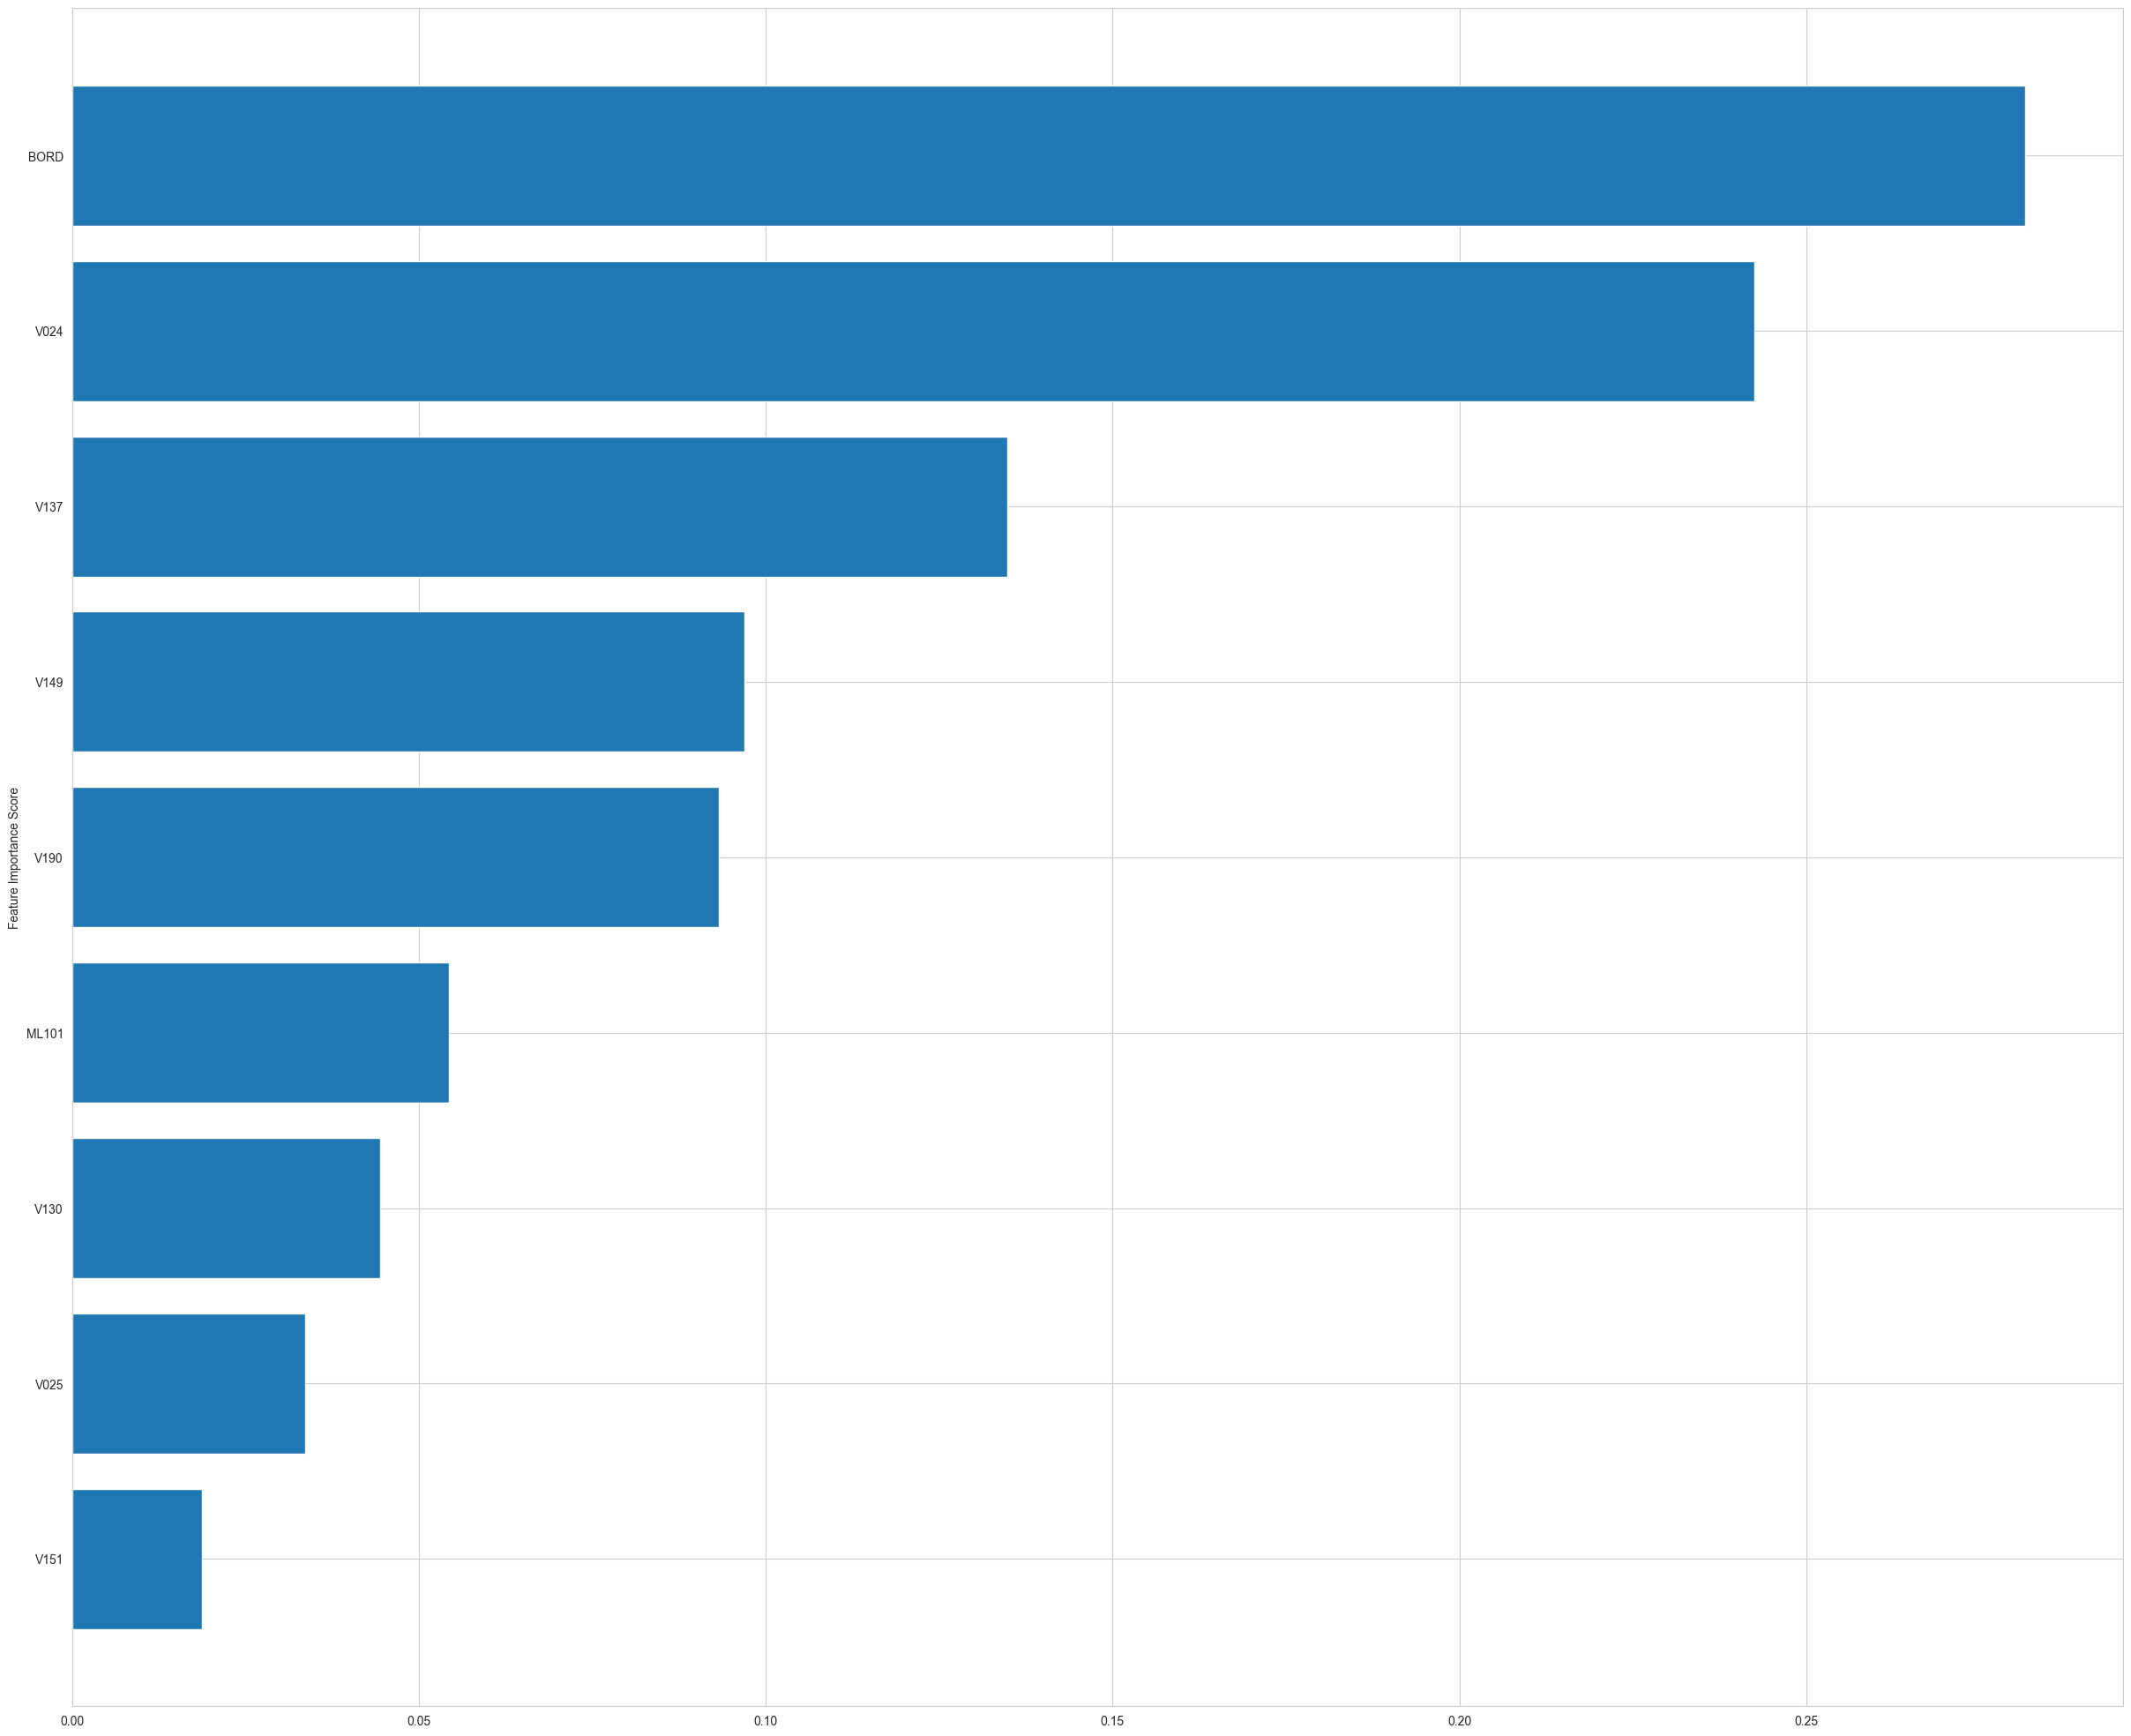

0.9900480433815206 0.9900480433815206 0.0003032438797945363
104/104 [==============================] - 0s 291us/step
7076     1
10080    1
12566    1
10222    0
13710    1
        ..
14856    1
9366     1
5048     1
11907    1
10408    0
Name: HML32$01, Length: 3297, dtype: int64
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1375, 1922]))
{'0': {'precision': 0.552, 'recall': 0.46027895694360216, 'f1-score': 0.5019841269841271, 'support': 1649}, '1': {'precision': 0.5369406867845994, 'recall': 0.6262135922330098, 'f1-score': 0.5781512605042017, 'support': 1648}, 'accuracy': 0.543221110100091, 'macro avg': {'precision': 0.5444703433922997, 'recall': 0.543246274588306, 'f1-score': 0.5400676937441644, 'support': 3297}, 'weighted avg': {'precision': 0.5444726271825963, 'recall': 0.543221110100091, 'f1-score': 0.5400561427685017, 'support': 3297}}
Accuracy 0.543221110100091
Precision 0.5369406867845994
Recall 0.6262135922330098
F1 Score 0.5781512605042017
Class

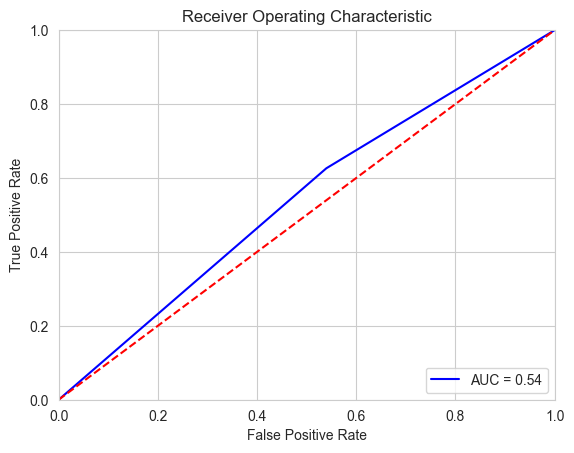

Normalized confusion matrix


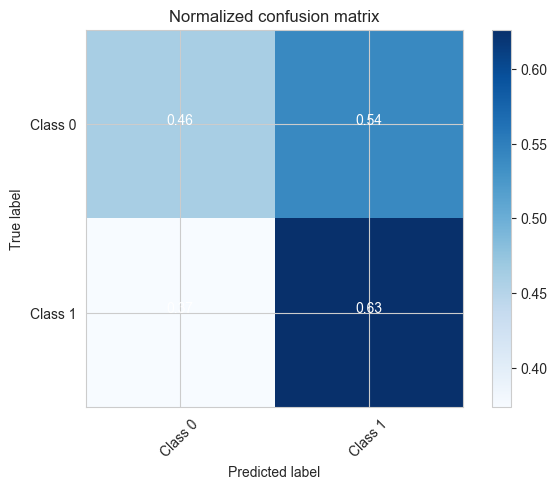

Metrics for the  Evaluation is {'accuracy': 0.543221110100091, 'precision': 0.5369406867845994, 'recall': 0.6262135922330098, 'f1': 0.5781512605042017}
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1500, 1797]))
{'0': {'precision': 0.7073333333333334, 'recall': 0.6434202546998181, 'f1-score': 0.6738647189583995, 'support': 1649}, '1': {'precision': 0.672787979966611, 'recall': 0.7336165048543689, 'f1-score': 0.7018867924528301, 'support': 1648}, 'accuracy': 0.6885047012435548, 'macro avg': {'precision': 0.6900606566499722, 'recall': 0.6885183797770935, 'f1-score': 0.6878757557056148, 'support': 3297}, 'weighted avg': {'precision': 0.6900658955570645, 'recall': 0.6885047012435548, 'f1-score': 0.6878715060736018, 'support': 3297}}
Accuracy 0.6885047012435548
Precision 0.672787979966611
Recall 0.7336165048543689
F1 Score 0.7018867924528301
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.64      0.67

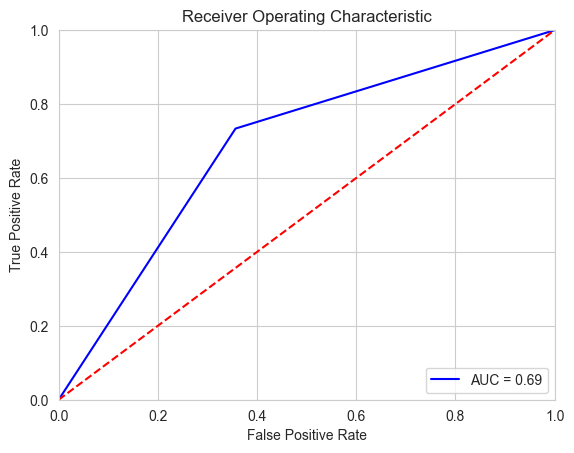

Normalized confusion matrix


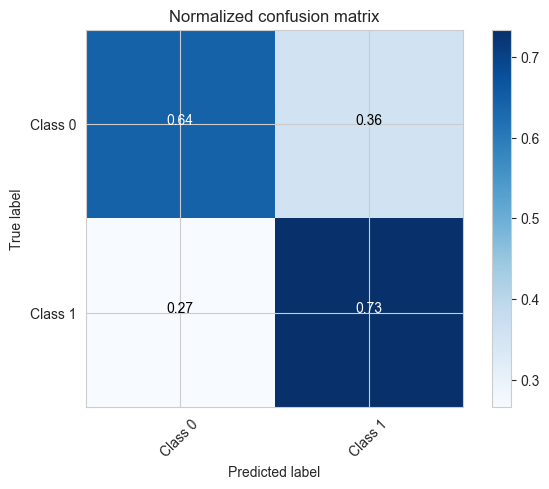

Metrics for the  Evaluation is {'accuracy': 0.6885047012435548, 'precision': 0.672787979966611, 'recall': 0.7336165048543689, 'f1': 0.7018867924528301}
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1449, 1848]))
{'0': {'precision': 0.779848171152519, 'recall': 0.6852637962401456, 'f1-score': 0.7295029051000647, 'support': 1649}, '1': {'precision': 0.7191558441558441, 'recall': 0.8064320388349514, 'f1-score': 0.7602974828375286, 'support': 1648}, 'accuracy': 0.745829542007886, 'macro avg': {'precision': 0.7495020076541816, 'recall': 0.7458479175375485, 'f1-score': 0.7449001939687967, 'support': 3297}, 'weighted avg': {'precision': 0.7495112118287337, 'recall': 0.745829542007886, 'f1-score': 0.744895523878148, 'support': 3297}}
Accuracy 0.745829542007886
Precision 0.7191558441558441
Recall 0.8064320388349514
F1 Score 0.7602974828375286
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.69      0.73   

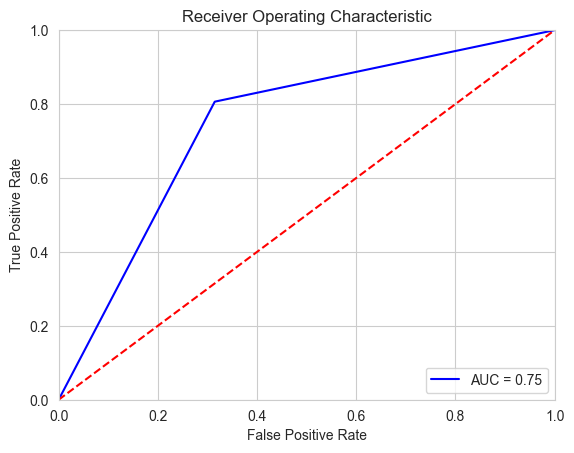

Normalized confusion matrix


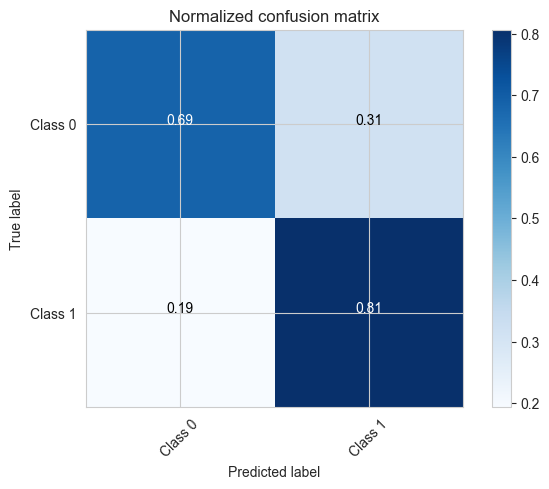

Metrics for the  Evaluation is {'accuracy': 0.745829542007886, 'precision': 0.7191558441558441, 'recall': 0.8064320388349514, 'f1': 0.7602974828375286}
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1524, 1773]))
{'0': {'precision': 0.5452755905511811, 'recall': 0.5039417828987265, 'f1-score': 0.5237945162306966, 'support': 1649}, '1': {'precision': 0.5386350817822899, 'recall': 0.5794902912621359, 'f1-score': 0.5583162817889505, 'support': 1648}, 'accuracy': 0.5417045799211404, 'macro avg': {'precision': 0.5419553361667355, 'recall': 0.5417160370804313, 'f1-score': 0.5410553990098236, 'support': 3297}, 'weighted avg': {'precision': 0.5419563432199307, 'recall': 0.5417045799211404, 'f1-score': 0.5410501636798936, 'support': 3297}}
Accuracy 0.5417045799211404
Precision 0.5386350817822899
Recall 0.5794902912621359
F1 Score 0.5583162817889505
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.50      0.

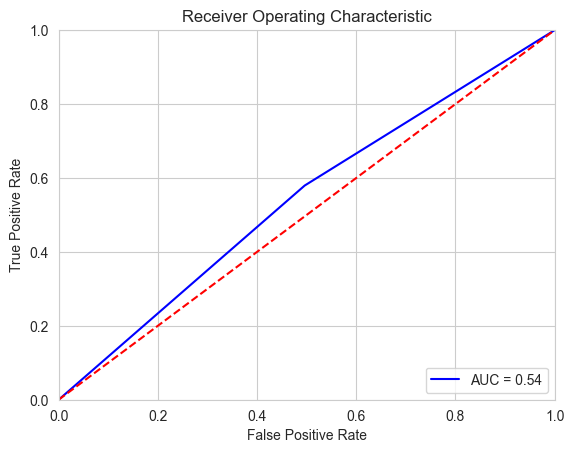

Normalized confusion matrix


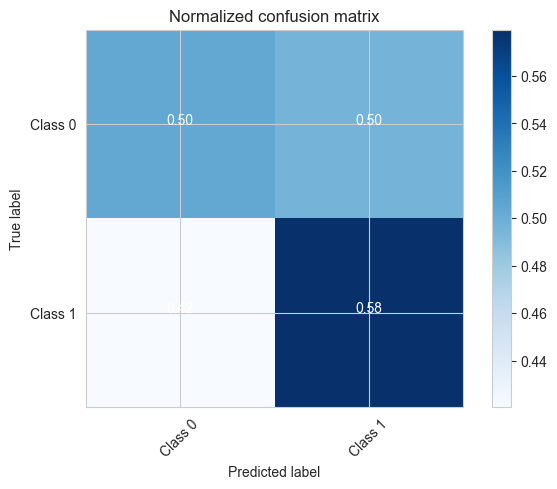

Metrics for the  Evaluation is {'accuracy': 0.5417045799211404, 'precision': 0.5386350817822899, 'recall': 0.5794902912621359, 'f1': 0.5583162817889505}
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1405, 1892]))
{'0': {'precision': 0.8711743772241993, 'recall': 0.7422680412371134, 'f1-score': 0.8015717092337918, 'support': 1649}, '1': {'precision': 0.7753699788583509, 'recall': 0.8901699029126213, 'f1-score': 0.8288135593220338, 'support': 1648}, 'accuracy': 0.816196542311192, 'macro avg': {'precision': 0.8232721780412751, 'recall': 0.8162189720748674, 'f1-score': 0.8151926342779128, 'support': 3297}, 'weighted avg': {'precision': 0.8232867070674149, 'recall': 0.816196542311192, 'f1-score': 0.8151885029691338, 'support': 3297}}
Accuracy 0.816196542311192
Precision 0.7753699788583509
Recall 0.8901699029126213
F1 Score 0.8288135593220338
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.74      0.80

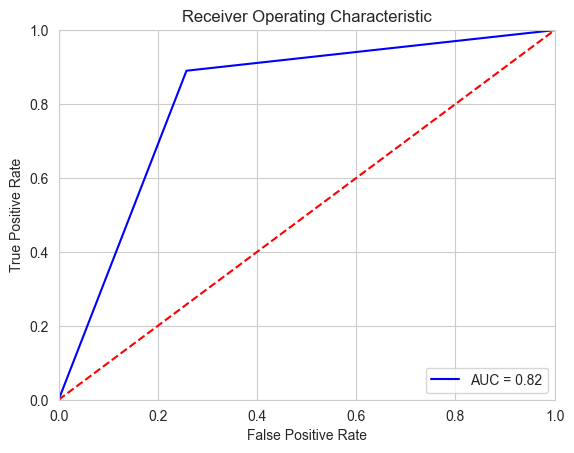

Normalized confusion matrix


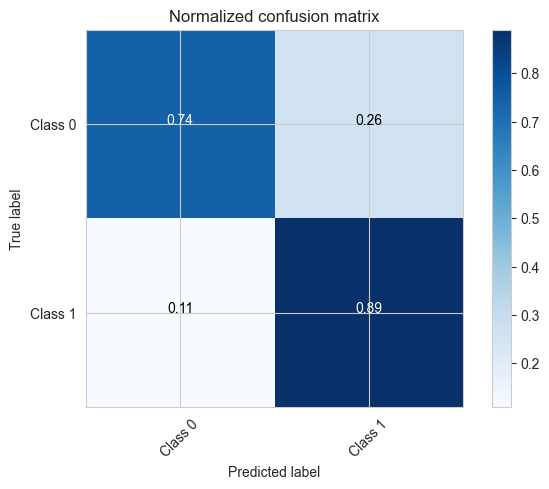

Metrics for the  Evaluation is {'accuracy': 0.816196542311192, 'precision': 0.7753699788583509, 'recall': 0.8901699029126213, 'f1': 0.8288135593220338}
{'catboost_result': {'accuracy': 0.6885047012435548, 'precision': 0.672787979966611, 'recall': 0.7336165048543689, 'f1': 0.7018867924528301}, 'xgb': {'accuracy': 0.745829542007886, 'precision': 0.7191558441558441, 'recall': 0.8064320388349514, 'f1': 0.7602974828375286}, 'log': {'accuracy': 0.5417045799211404, 'precision': 0.5386350817822899, 'recall': 0.5794902912621359, 'f1': 0.5583162817889505}, 'neural': {'accuracy': 0.543221110100091, 'precision': 0.5369406867845994, 'recall': 0.6262135922330098, 'f1': 0.5781512605042017}, 'radom_forest': {'accuracy': 0.816196542311192, 'precision': 0.7753699788583509, 'recall': 0.8901699029126213, 'f1': 0.8288135593220338}}


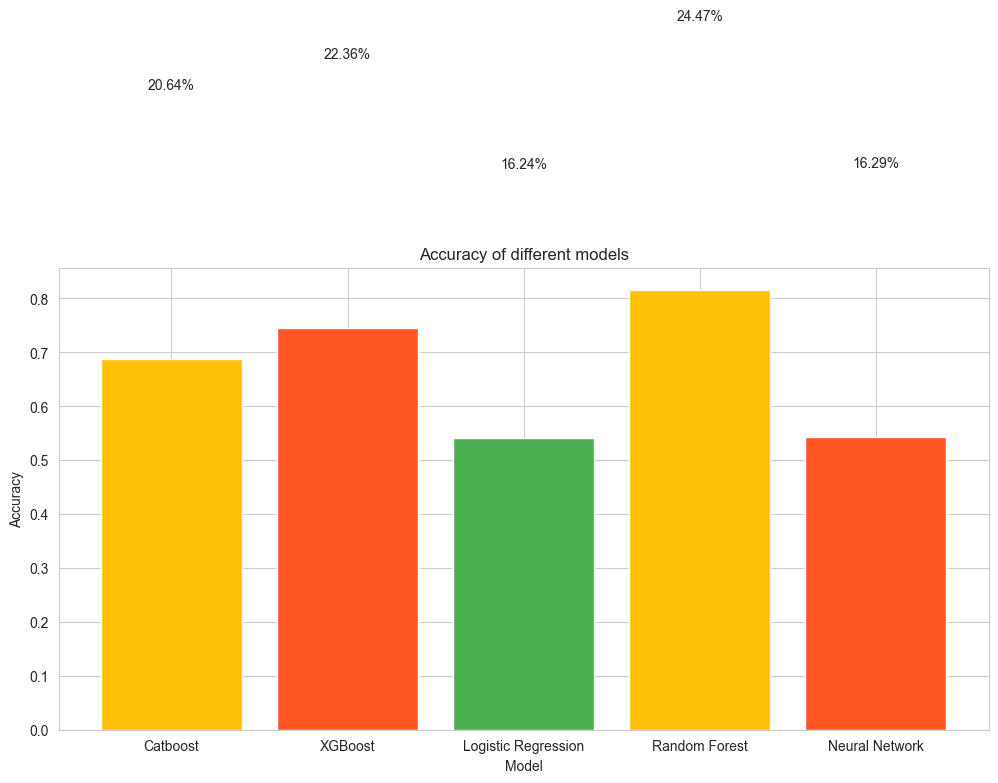

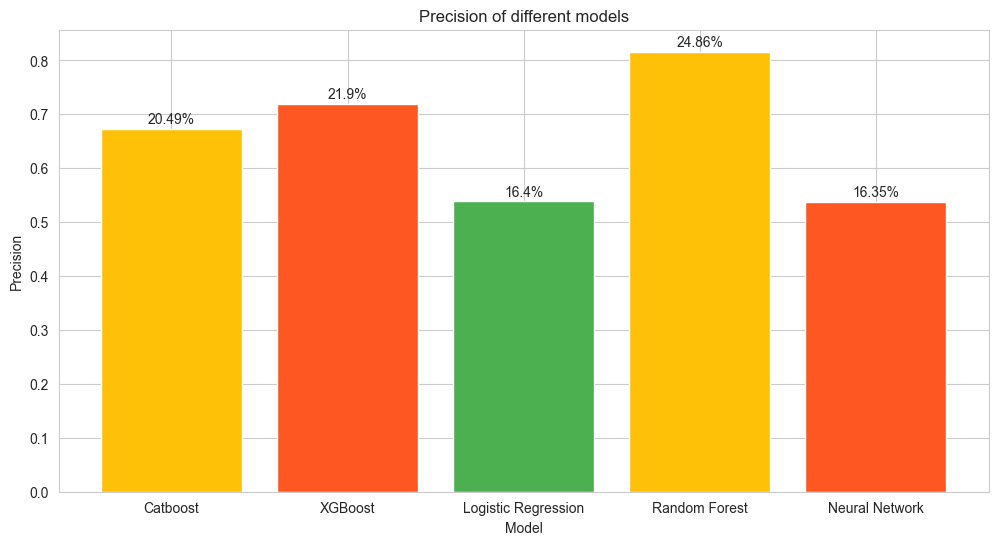

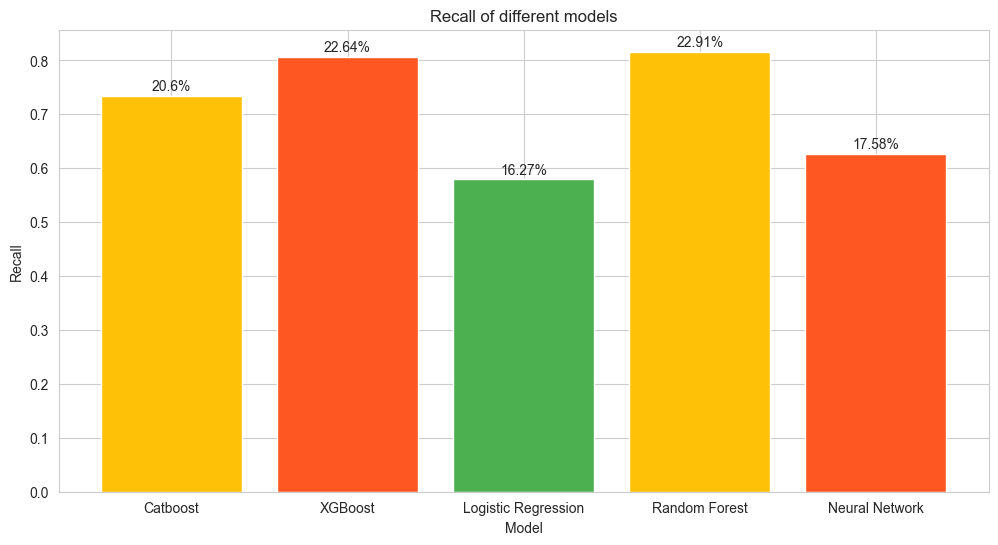

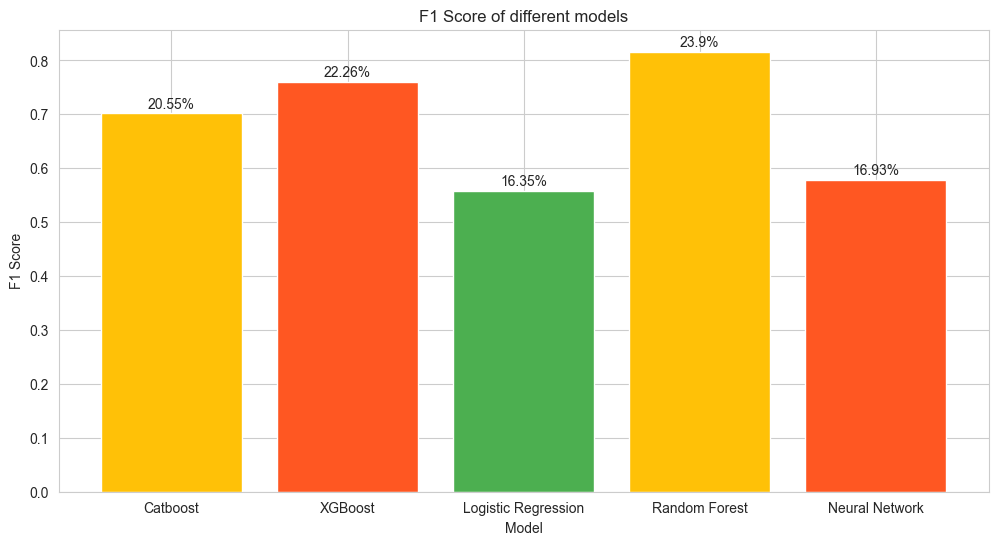

In [35]:
# Results with cross validation and oversamplying
_X, _Y = oversampling()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad, with_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.5851720437462387 0.6814361872541664
Training scores 0.6065857366999337 0.67328370339017
================================Fold2====================================

Validation scores 0.6165045083778748 0.6694268950192149
Training scores 0.5985337351974365 0.6763090823498945
================================Fold3====================================

Validation scores 0.5945717487267335 0.6764928631485201
Training scores 0.6044605684314572 0.6744619094797832
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5951159141346102 0.6776137979017319
Training scores 0.603814757080928 0.6742126958274683
================================Fold5====================================

Validation scores 0.608871909445354 0.6729018108820738
Training scores 0.600745338155028 0.6753649363397054


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


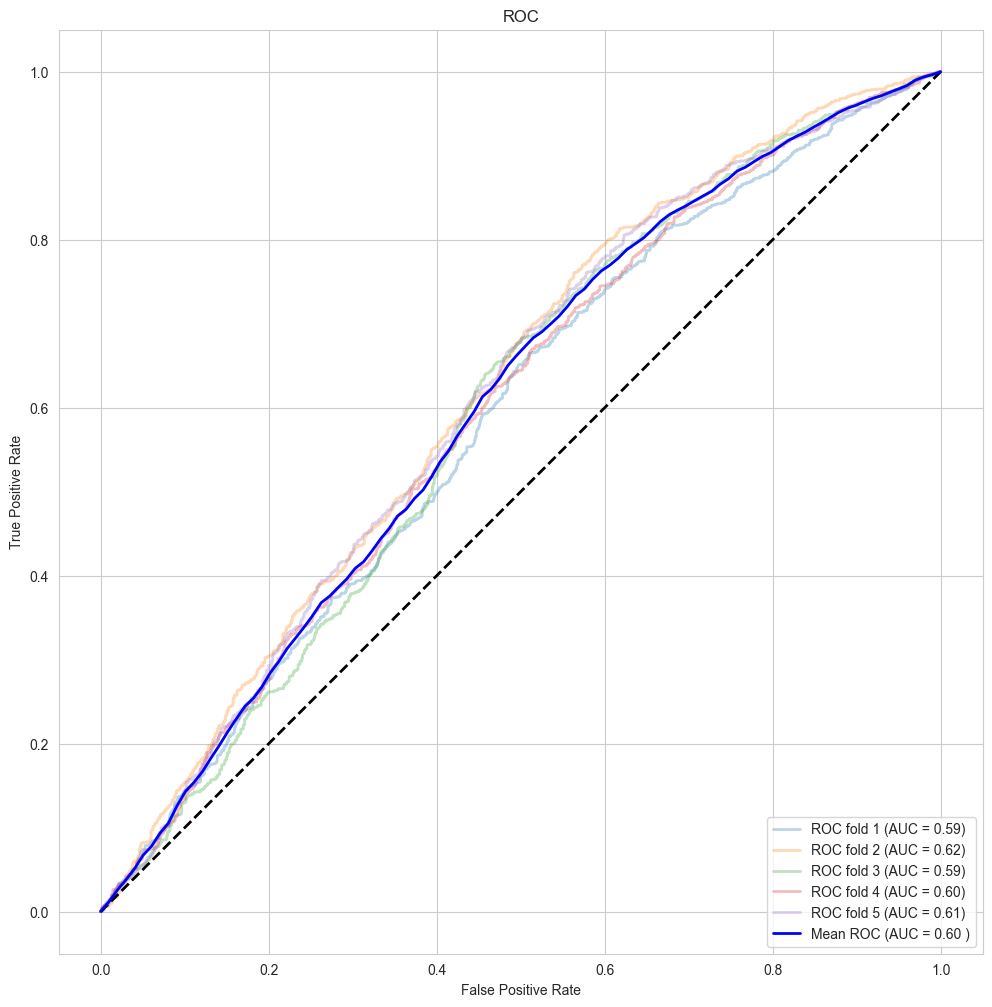

0.6028280271129567 0.6028280271129567 0.0028473758051069907
================================Fold1====================================
0:	learn: 0.5811773	test: 0.5629432	best: 0.5629432 (0)	total: 3.21ms	remaining: 32.1s
50:	learn: 0.6700078	test: 0.6466856	best: 0.6466856 (50)	total: 132ms	remaining: 25.8s
100:	learn: 0.6860034	test: 0.6561777	best: 0.6561777 (100)	total: 261ms	remaining: 25.5s
150:	learn: 0.7054654	test: 0.6699723	best: 0.6699723 (150)	total: 389ms	remaining: 25.4s
200:	learn: 0.7161668	test: 0.6858657	best: 0.6858657 (200)	total: 517ms	remaining: 25.2s
250:	learn: 0.7263324	test: 0.6952896	best: 0.6966023 (243)	total: 646ms	remaining: 25.1s
300:	learn: 0.7342982	test: 0.7062148	best: 0.7073774 (296)	total: 775ms	remaining: 25s
350:	learn: 0.7438321	test: 0.7222052	best: 0.7222052 (350)	total: 905ms	remaining: 24.9s
400:	learn: 0.7533263	test: 0.7282394	best: 0.7320445 (392)	total: 1.03s	remaining: 24.6s
450:	learn: 0.7621044	test: 0.7347756	best: 0.7347756 (450)	tot

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.6866522	test: 0.6982353	best: 0.6982353 (100)	total: 263ms	remaining: 25.7s
150:	learn: 0.6983182	test: 0.7068897	best: 0.7068897 (150)	total: 389ms	remaining: 25.3s
200:	learn: 0.7129894	test: 0.7180117	best: 0.7187406 (199)	total: 515ms	remaining: 25.1s
250:	learn: 0.7255123	test: 0.7268893	best: 0.7268893 (250)	total: 642ms	remaining: 24.9s
300:	learn: 0.7348875	test: 0.7377817	best: 0.7377817 (300)	total: 771ms	remaining: 24.8s
350:	learn: 0.7428081	test: 0.7441485	best: 0.7441485 (348)	total: 899ms	remaining: 24.7s
400:	learn: 0.7516229	test: 0.7495851	best: 0.7501675 (375)	total: 1.03s	remaining: 24.7s
450:	learn: 0.7596508	test: 0.7594207	best: 0.7623387 (438)	total: 1.16s	remaining: 24.6s
500:	learn: 0.7618587	test: 0.7624081	best: 0.7624081 (499)	total: 1.29s	remaining: 24.6s
550:	learn: 0.7655398	test: 0.7638182	best: 0.7645888 (539)	total: 1.43s	remaining: 24.5s
600:	learn: 0.7702959	test: 0.7619576	best: 0.7649482 (587)	total: 1.56s	remaining: 24.4s
650:	learn

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


50:	learn: 0.6646306	test: 0.6563427	best: 0.6578679 (49)	total: 124ms	remaining: 24.2s
100:	learn: 0.6862356	test: 0.6711993	best: 0.6730804 (95)	total: 256ms	remaining: 25.1s
150:	learn: 0.7042339	test: 0.6844227	best: 0.6844295 (148)	total: 380ms	remaining: 24.8s
200:	learn: 0.7135983	test: 0.6967556	best: 0.6967556 (200)	total: 503ms	remaining: 24.5s
250:	learn: 0.7233868	test: 0.7063198	best: 0.7063198 (250)	total: 630ms	remaining: 24.5s
300:	learn: 0.7324220	test: 0.7122711	best: 0.7148660 (290)	total: 764ms	remaining: 24.6s
350:	learn: 0.7427017	test: 0.7261562	best: 0.7265507 (348)	total: 886ms	remaining: 24.4s
400:	learn: 0.7558263	test: 0.7342507	best: 0.7342507 (400)	total: 1s	remaining: 24.1s
450:	learn: 0.7593142	test: 0.7375595	best: 0.7383268 (445)	total: 1.12s	remaining: 23.8s
500:	learn: 0.7632311	test: 0.7418961	best: 0.7451052 (467)	total: 1.25s	remaining: 23.7s
550:	learn: 0.7671758	test: 0.7471882	best: 0.7484122 (532)	total: 1.37s	remaining: 23.6s
600:	learn: 0.77

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.6816944	test: 0.6715923	best: 0.6738676 (95)	total: 264ms	remaining: 25.9s
150:	learn: 0.7049260	test: 0.6924270	best: 0.6943416 (139)	total: 386ms	remaining: 25.2s
200:	learn: 0.7183888	test: 0.7092495	best: 0.7092495 (200)	total: 513ms	remaining: 25s
250:	learn: 0.7299506	test: 0.7187668	best: 0.7187668 (250)	total: 636ms	remaining: 24.7s
300:	learn: 0.7382491	test: 0.7204164	best: 0.7235450 (263)	total: 764ms	remaining: 24.6s
350:	learn: 0.7493112	test: 0.7351781	best: 0.7352133 (349)	total: 889ms	remaining: 24.4s
400:	learn: 0.7557473	test: 0.7430367	best: 0.7430367 (400)	total: 1.01s	remaining: 24.3s
450:	learn: 0.7623142	test: 0.7522821	best: 0.7522821 (450)	total: 1.15s	remaining: 24.4s
500:	learn: 0.7691444	test: 0.7560984	best: 0.7560984 (500)	total: 1.29s	remaining: 24.4s
550:	learn: 0.7719213	test: 0.7541977	best: 0.7560984 (500)	total: 1.42s	remaining: 24.3s
600:	learn: 0.7732001	test: 0.7549186	best: 0.7560984 (500)	total: 1.55s	remaining: 24.2s
650:	learn: 0

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


100:	learn: 0.6810829	test: 0.6893697	best: 0.6893697 (100)	total: 242ms	remaining: 23.7s
150:	learn: 0.6961538	test: 0.7026886	best: 0.7026886 (150)	total: 347ms	remaining: 22.6s
200:	learn: 0.7089313	test: 0.7158347	best: 0.7162094 (199)	total: 473ms	remaining: 23.1s
250:	learn: 0.7181418	test: 0.7305338	best: 0.7305338 (250)	total: 588ms	remaining: 22.9s
300:	learn: 0.7290725	test: 0.7400625	best: 0.7412116 (297)	total: 714ms	remaining: 23s
350:	learn: 0.7391025	test: 0.7455804	best: 0.7455804 (350)	total: 833ms	remaining: 22.9s
400:	learn: 0.7538674	test: 0.7571163	best: 0.7585866 (398)	total: 964ms	remaining: 23.1s
450:	learn: 0.7592388	test: 0.7591051	best: 0.7592688 (446)	total: 1.09s	remaining: 23s
500:	learn: 0.7614157	test: 0.7612344	best: 0.7628046 (496)	total: 1.2s	remaining: 22.7s
550:	learn: 0.7652786	test: 0.7614486	best: 0.7641580 (532)	total: 1.31s	remaining: 22.5s
600:	learn: 0.7663160	test: 0.7630524	best: 0.7641580 (532)	total: 1.44s	remaining: 22.5s
650:	learn: 0.7

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


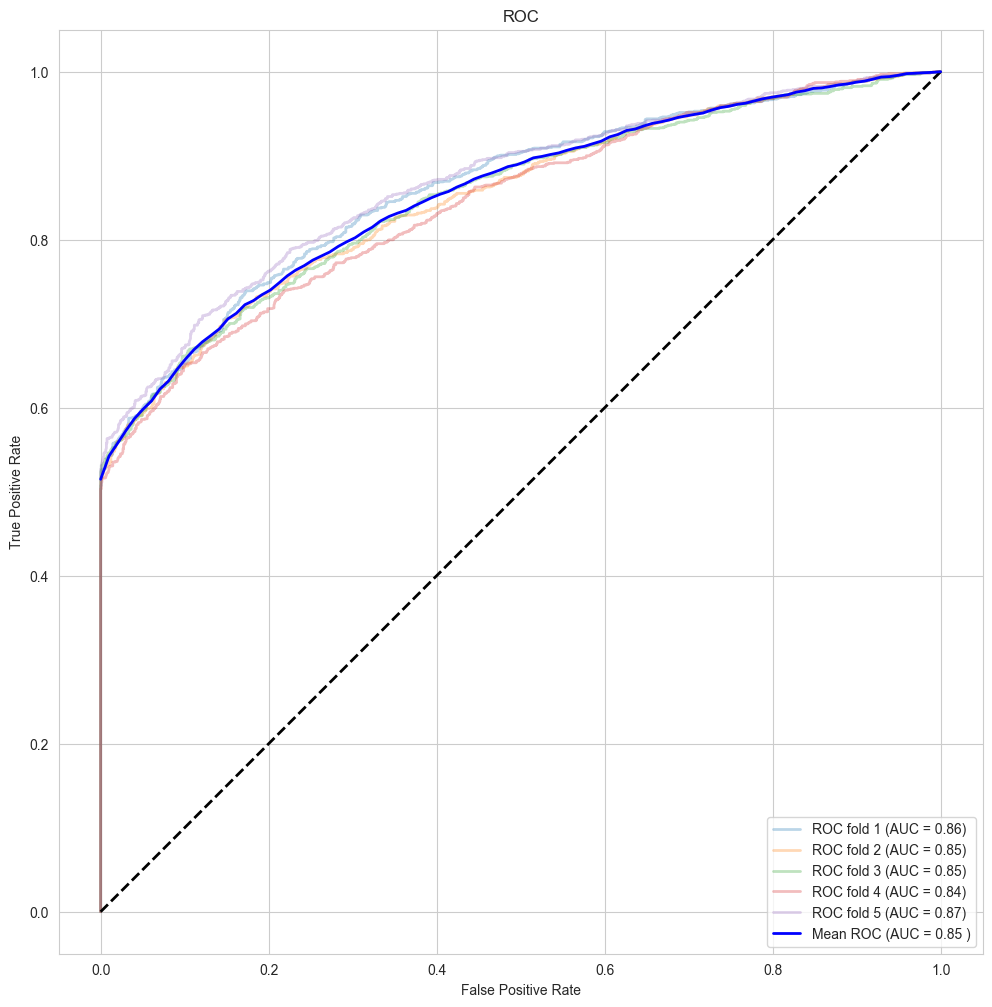

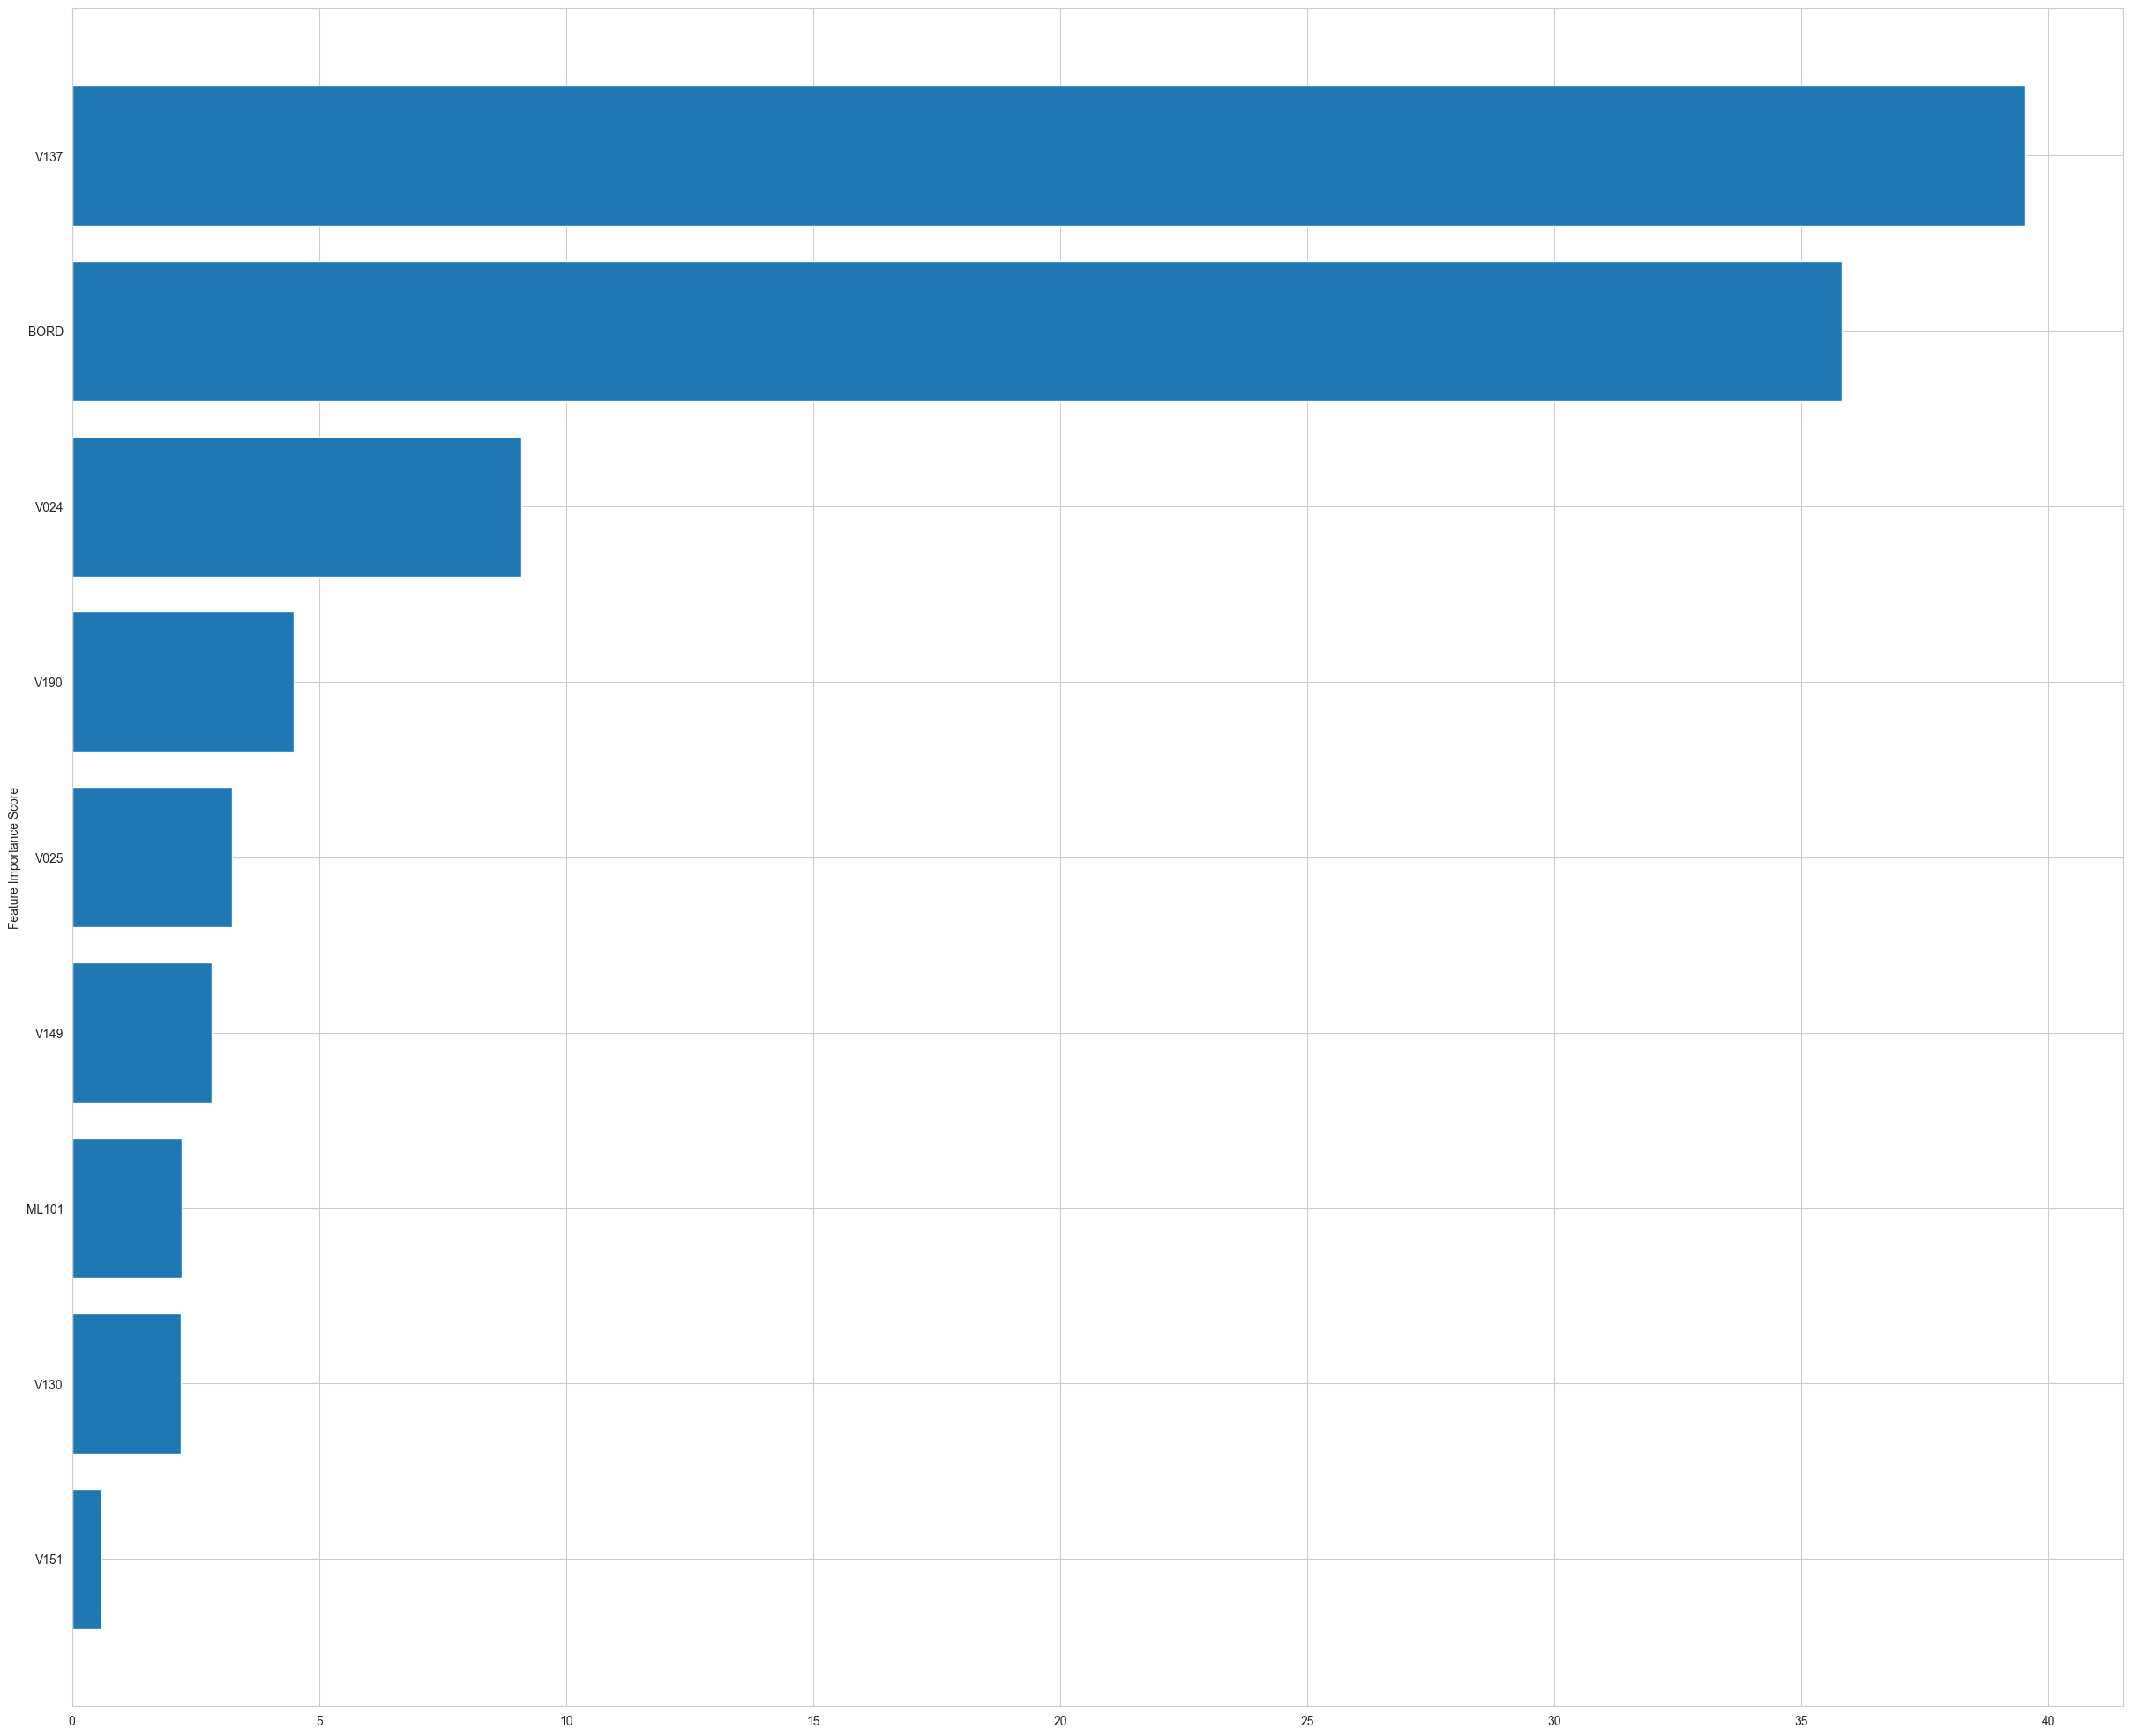

0.8897887974341412 0.8897887974341412 0.012585660448637312
================================Fold1====================================
[09:57:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.59936
[1]	validation_0-auc:0.70252
[2]	validation_0-auc:0.70250
[3]	validation_0-auc:0.70235
[4]	validation_0-auc:0.72256
[5]	validation_0-auc:0.73183
[6]	validation_0-auc:0.74861
[7]	validation_0-auc:0.75275
[8]	validation_0-auc:0.75777
[9]	validation_0-auc:0.75920
[10]	validation_0-auc:0.77193
[11]	validation_0-auc:0.77841
[12]	validation_0-auc:0.78638
[13]	validation_0-auc:0.79504
[14]	validation_0-auc:0.80047
[15]	validation_0-auc:0.80249
[16]	validation_0-auc:0.80788
[17]	validation_0-auc:0.80825
[18]	validation_0-auc:0.81003
[19]	validation_0-auc:0.81220
[20]	validation_0-auc:0.81585
[21]	validation_0-auc:0.81897
[22]	valid

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[77]	validation_0-auc:0.84249
[78]	validation_0-auc:0.84252
[79]	validation_0-auc:0.84240
[80]	validation_0-auc:0.84265
[81]	validation_0-auc:0.84268
[82]	validation_0-auc:0.84286
[83]	validation_0-auc:0.84291
[84]	validation_0-auc:0.84305
[85]	validation_0-auc:0.84325
[86]	validation_0-auc:0.84328
[87]	validation_0-auc:0.84353
[88]	validation_0-auc:0.84377
[89]	validation_0-auc:0.84424
[90]	validation_0-auc:0.84428
[91]	validation_0-auc:0.84453
[92]	validation_0-auc:0.84482
[93]	validation_0-auc:0.84537
[94]	validation_0-auc:0.84525
[95]	validation_0-auc:0.84561
[96]	validation_0-auc:0.84561
[97]	validation_0-auc:0.84553
[98]	validation_0-auc:0.84542
[99]	validation_0-auc:0.84555
[100]	validation_0-auc:0.84566
[101]	validation_0-auc:0.84562
[102]	validation_0-auc:0.84589
[103]	validation_0-auc:0.84612
[104]	validation_0-auc:0.84630
[105]	validation_0-auc:0.84623
[106]	validation_0-auc:0.84639
[107]	validation_0-auc:0.84633
[108]	validation_0-auc:0.84665
[109]	validation_0-auc:0.84661


/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[65]	validation_0-auc:0.84981
[66]	validation_0-auc:0.84994
[67]	validation_0-auc:0.84996
[68]	validation_0-auc:0.84985
[69]	validation_0-auc:0.84991
[70]	validation_0-auc:0.85064
[71]	validation_0-auc:0.85099
[72]	validation_0-auc:0.85155
[73]	validation_0-auc:0.85174
[74]	validation_0-auc:0.85220
[75]	validation_0-auc:0.85258
[76]	validation_0-auc:0.85216
[77]	validation_0-auc:0.85223
[78]	validation_0-auc:0.85224
[79]	validation_0-auc:0.85203
[80]	validation_0-auc:0.85201
[81]	validation_0-auc:0.85187
[82]	validation_0-auc:0.85241
[83]	validation_0-auc:0.85263
[84]	validation_0-auc:0.85238
[85]	validation_0-auc:0.85263
[86]	validation_0-auc:0.85283
[87]	validation_0-auc:0.85294
[88]	validation_0-auc:0.85304
[89]	validation_0-auc:0.85317
[90]	validation_0-auc:0.85324
[91]	validation_0-auc:0.85340
[92]	validation_0-auc:0.85317
[93]	validation_0-auc:0.85334
[94]	validation_0-auc:0.85347
[95]	validation_0-auc:0.85380
[96]	validation_0-auc:0.85386
[97]	validation_0-auc:0.85417
[98]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[65]	validation_0-auc:0.84168
[66]	validation_0-auc:0.84172
[67]	validation_0-auc:0.84257
[68]	validation_0-auc:0.84251
[69]	validation_0-auc:0.84265
[70]	validation_0-auc:0.84289
[71]	validation_0-auc:0.84263
[72]	validation_0-auc:0.84304
[73]	validation_0-auc:0.84315
[74]	validation_0-auc:0.84360
[75]	validation_0-auc:0.84378
[76]	validation_0-auc:0.84381
[77]	validation_0-auc:0.84395
[78]	validation_0-auc:0.84447
[79]	validation_0-auc:0.84474
[80]	validation_0-auc:0.84453
[81]	validation_0-auc:0.84482
[82]	validation_0-auc:0.84487
[83]	validation_0-auc:0.84505
[84]	validation_0-auc:0.84481
[85]	validation_0-auc:0.84485
[86]	validation_0-auc:0.84496
[87]	validation_0-auc:0.84508
[88]	validation_0-auc:0.84525
[89]	validation_0-auc:0.84581
[90]	validation_0-auc:0.84617
[91]	validation_0-auc:0.84656
[92]	validation_0-auc:0.84710
[93]	validation_0-auc:0.84745
[94]	validation_0-auc:0.84735
[95]	validation_0-auc:0.84715
[96]	validation_0-auc:0.84738
[97]	validation_0-auc:0.84733
[98]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[58]	validation_0-auc:0.83848
[59]	validation_0-auc:0.83899
[60]	validation_0-auc:0.83892
[61]	validation_0-auc:0.83947
[62]	validation_0-auc:0.83998
[63]	validation_0-auc:0.83944
[64]	validation_0-auc:0.84008
[65]	validation_0-auc:0.84002
[66]	validation_0-auc:0.84014
[67]	validation_0-auc:0.84013
[68]	validation_0-auc:0.83990
[69]	validation_0-auc:0.84055
[70]	validation_0-auc:0.84050
[71]	validation_0-auc:0.84069
[72]	validation_0-auc:0.84117
[73]	validation_0-auc:0.84082
[74]	validation_0-auc:0.84132
[75]	validation_0-auc:0.84135
[76]	validation_0-auc:0.84125
[77]	validation_0-auc:0.84135
[78]	validation_0-auc:0.84165
[79]	validation_0-auc:0.84176
[80]	validation_0-auc:0.84143
[81]	validation_0-auc:0.84209
[82]	validation_0-auc:0.84217
[83]	validation_0-auc:0.84192
[84]	validation_0-auc:0.84225
[85]	validation_0-auc:0.84238
[86]	validation_0-auc:0.84243
[87]	validation_0-auc:0.84249
[88]	validation_0-auc:0.84242
[89]	validation_0-auc:0.84239
[90]	validation_0-auc:0.84254
[91]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[18]	validation_0-auc:0.83537
[19]	validation_0-auc:0.83636
[20]	validation_0-auc:0.84029
[21]	validation_0-auc:0.84061
[22]	validation_0-auc:0.84097
[23]	validation_0-auc:0.84151
[24]	validation_0-auc:0.84304
[25]	validation_0-auc:0.84311
[26]	validation_0-auc:0.84442
[27]	validation_0-auc:0.84506
[28]	validation_0-auc:0.84624
[29]	validation_0-auc:0.84779
[30]	validation_0-auc:0.84840
[31]	validation_0-auc:0.84758
[32]	validation_0-auc:0.84805
[33]	validation_0-auc:0.84908
[34]	validation_0-auc:0.84968
[35]	validation_0-auc:0.85023
[36]	validation_0-auc:0.85053
[37]	validation_0-auc:0.85100
[38]	validation_0-auc:0.85109
[39]	validation_0-auc:0.85173
[40]	validation_0-auc:0.85212
[41]	validation_0-auc:0.85270
[42]	validation_0-auc:0.85291
[43]	validation_0-auc:0.85336
[44]	validation_0-auc:0.85395
[45]	validation_0-auc:0.85415
[46]	validation_0-auc:0.85441
[47]	validation_0-auc:0.85455
[48]	validation_0-auc:0.85470
[49]	validation_0-auc:0.85504
[50]	validation_0-auc:0.85533
[51]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


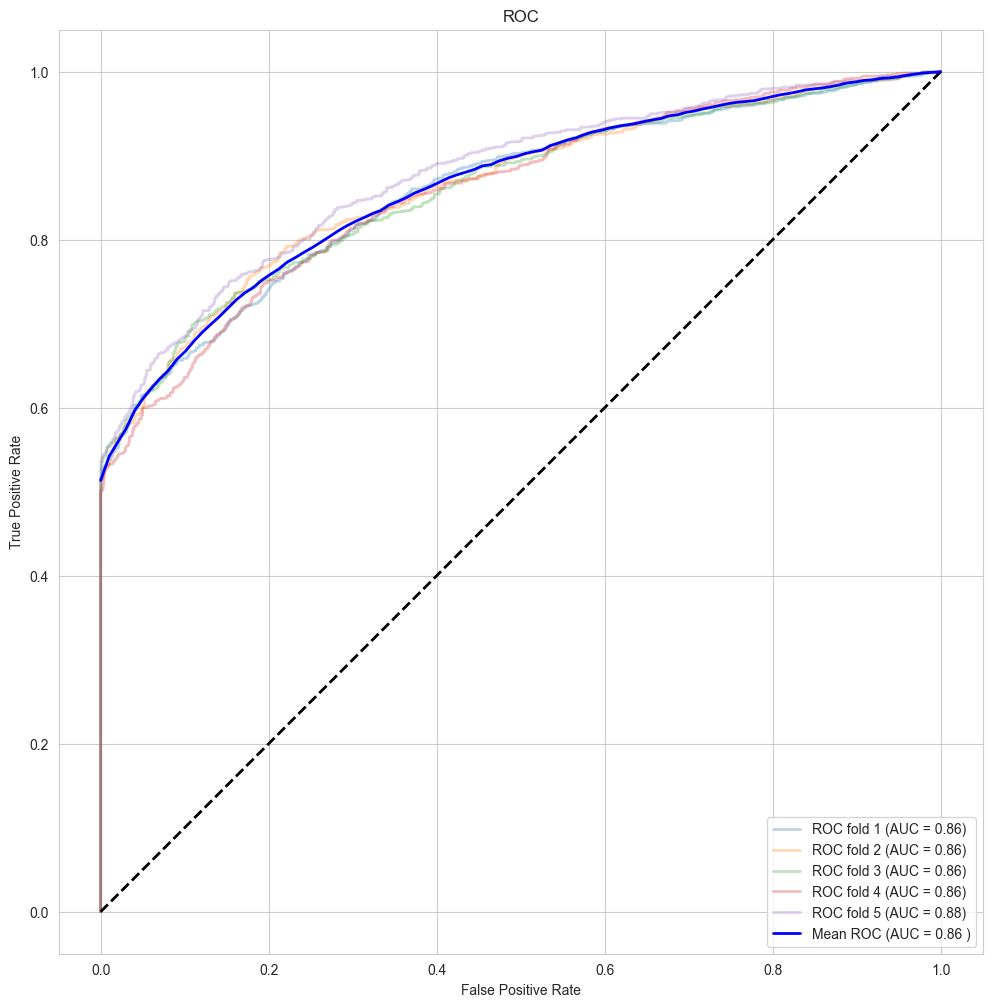

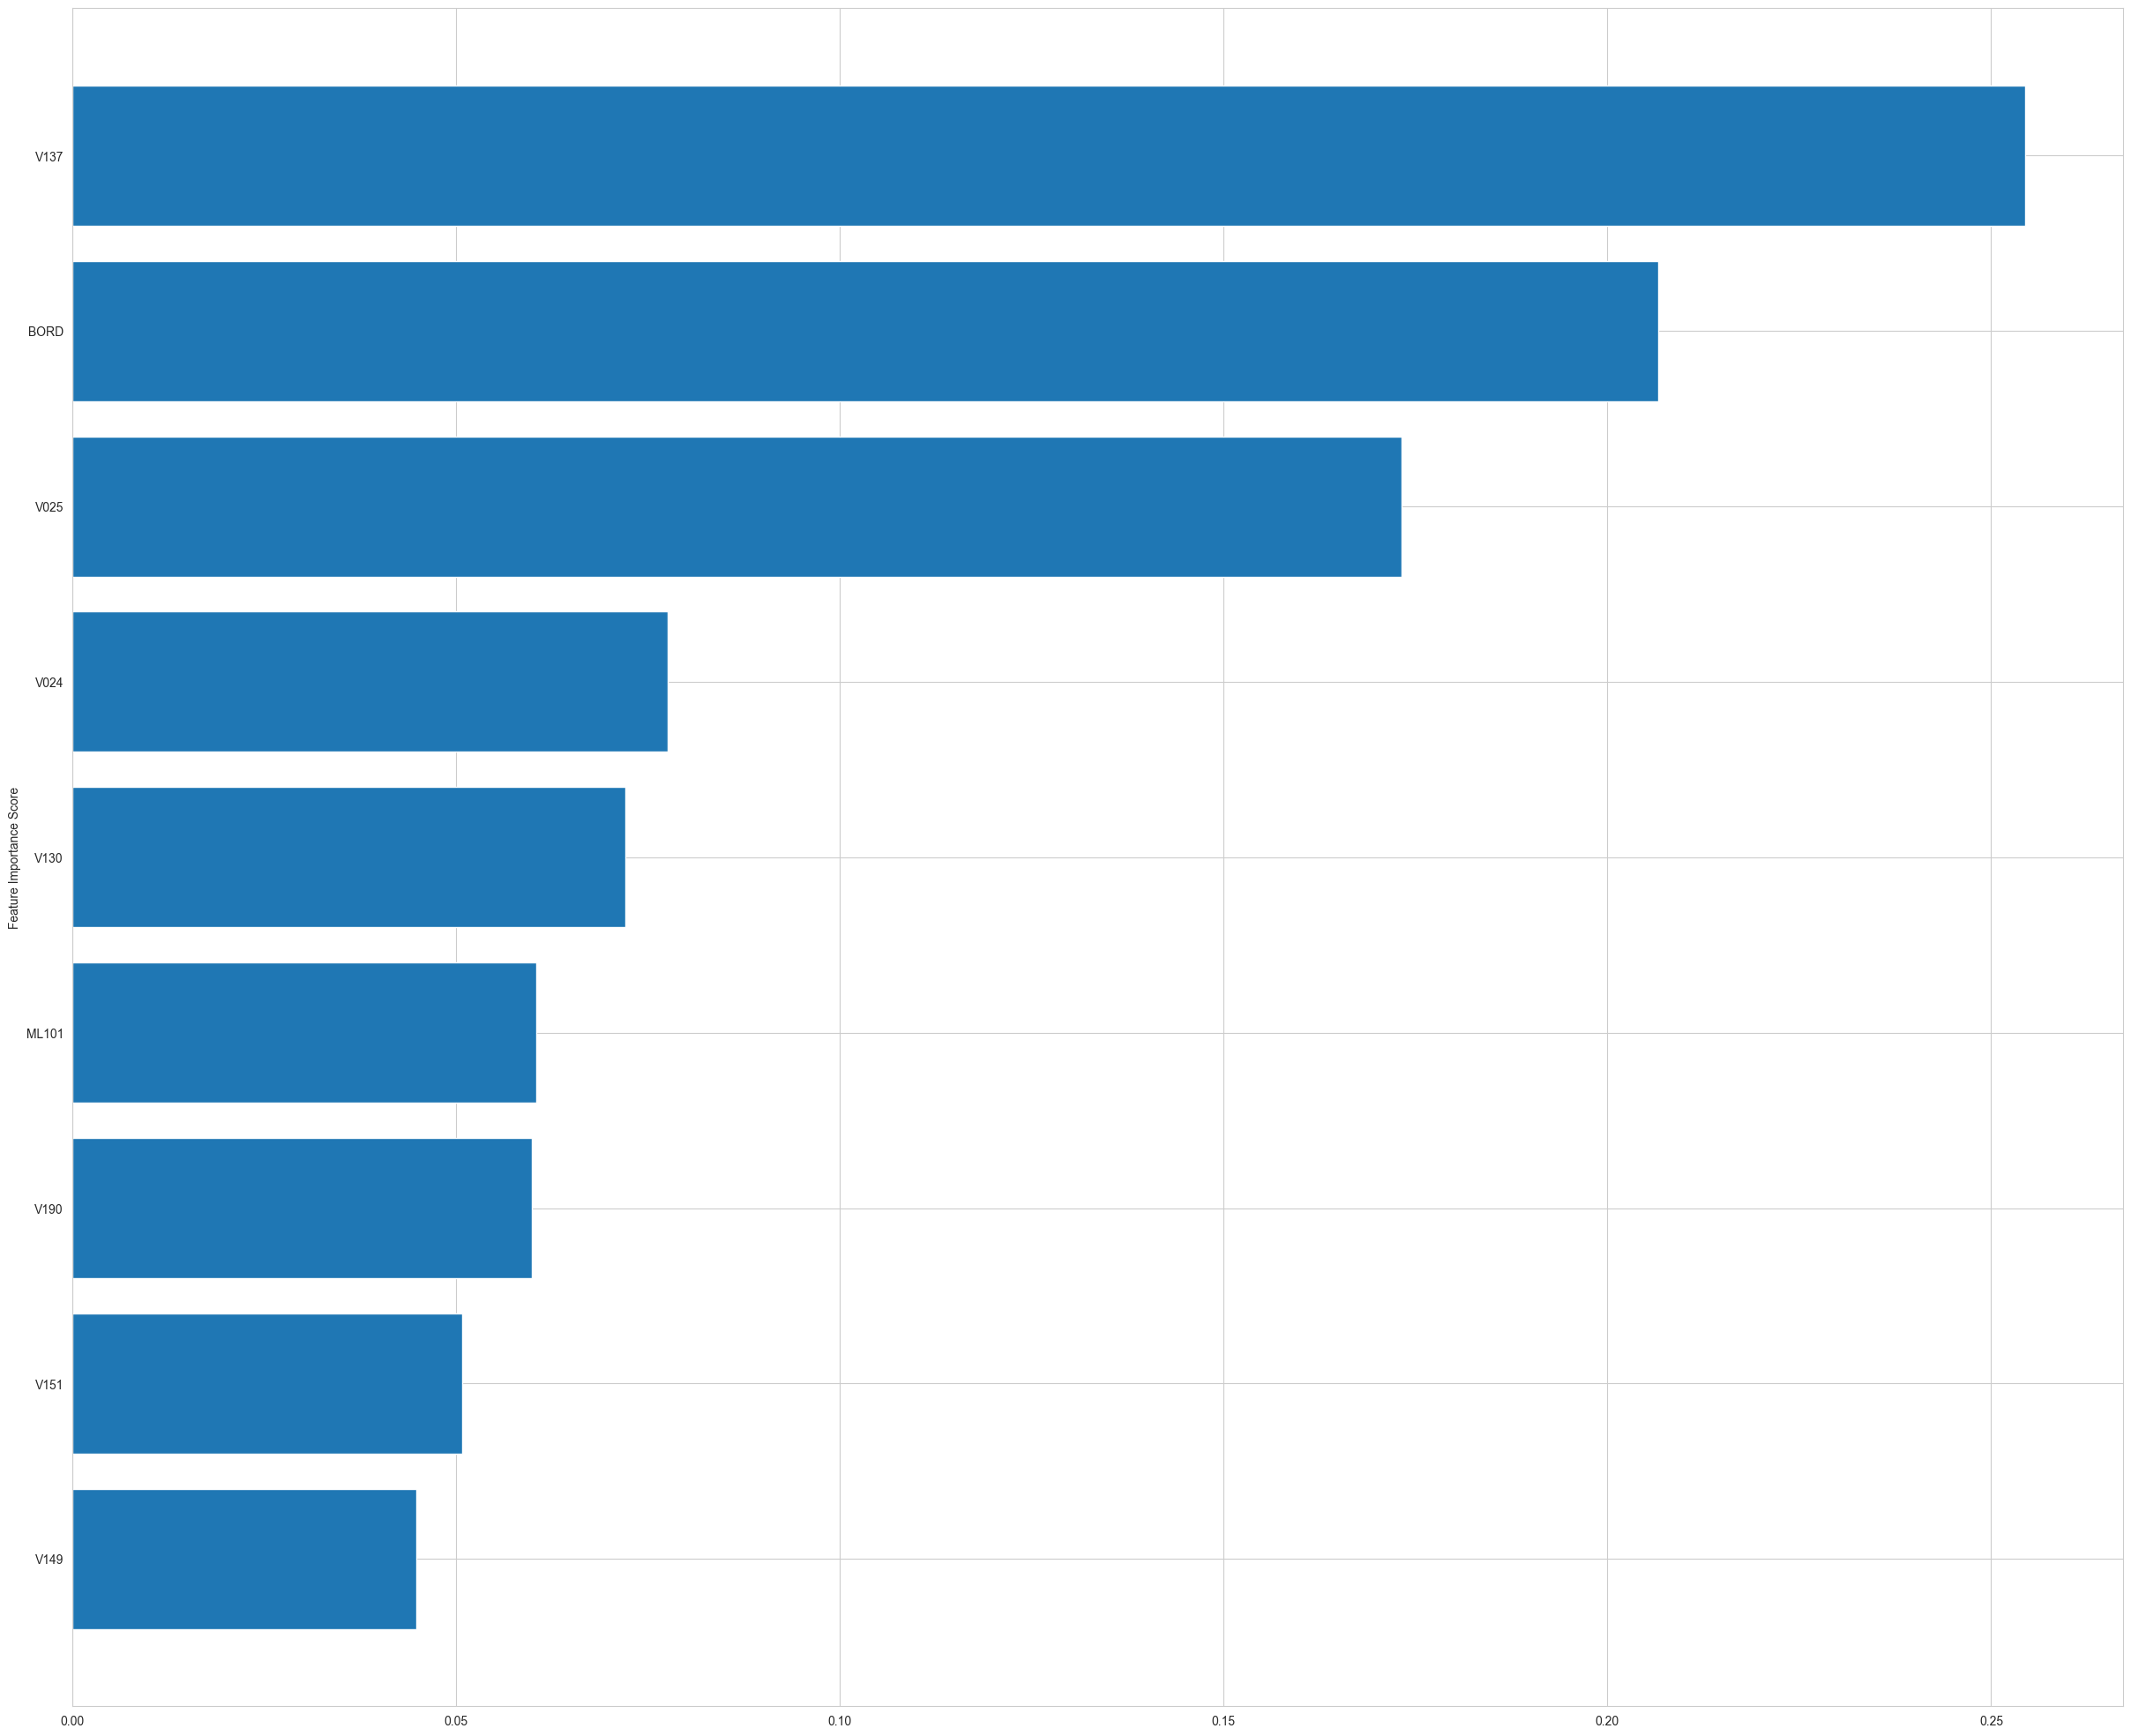

0.926061552877956 0.926061552877956 0.007520769423861119
================================Fold1====================================

Validation scores 0.863537290466909 0.570429424922288
Training scores 0.9941680280801644 0.15891746071499008
================================Fold2====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.8600319239251827 0.5311368280555792
Training scores 0.9943281087405442 0.15827718947207592
================================Fold3====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.86570906593375 0.5176862119120792
Training scores 0.9941473190322704 0.15922079841101097
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.8586446945023187 0.5962727229710303
Training scores 0.9944874194200489 0.15860715409608528
================================Fold5====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.8769237052487228 0.49518123797952973
Training scores 0.9941109139507199 0.16071227798337182


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


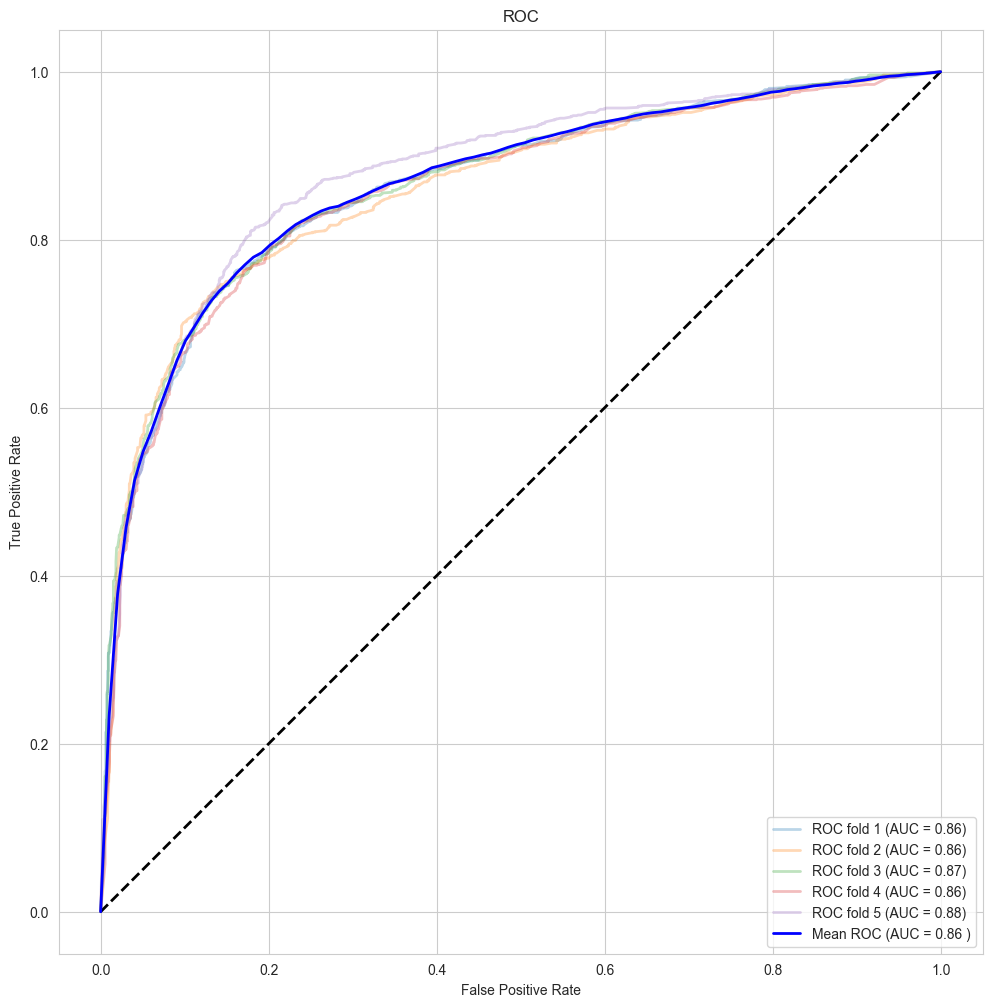

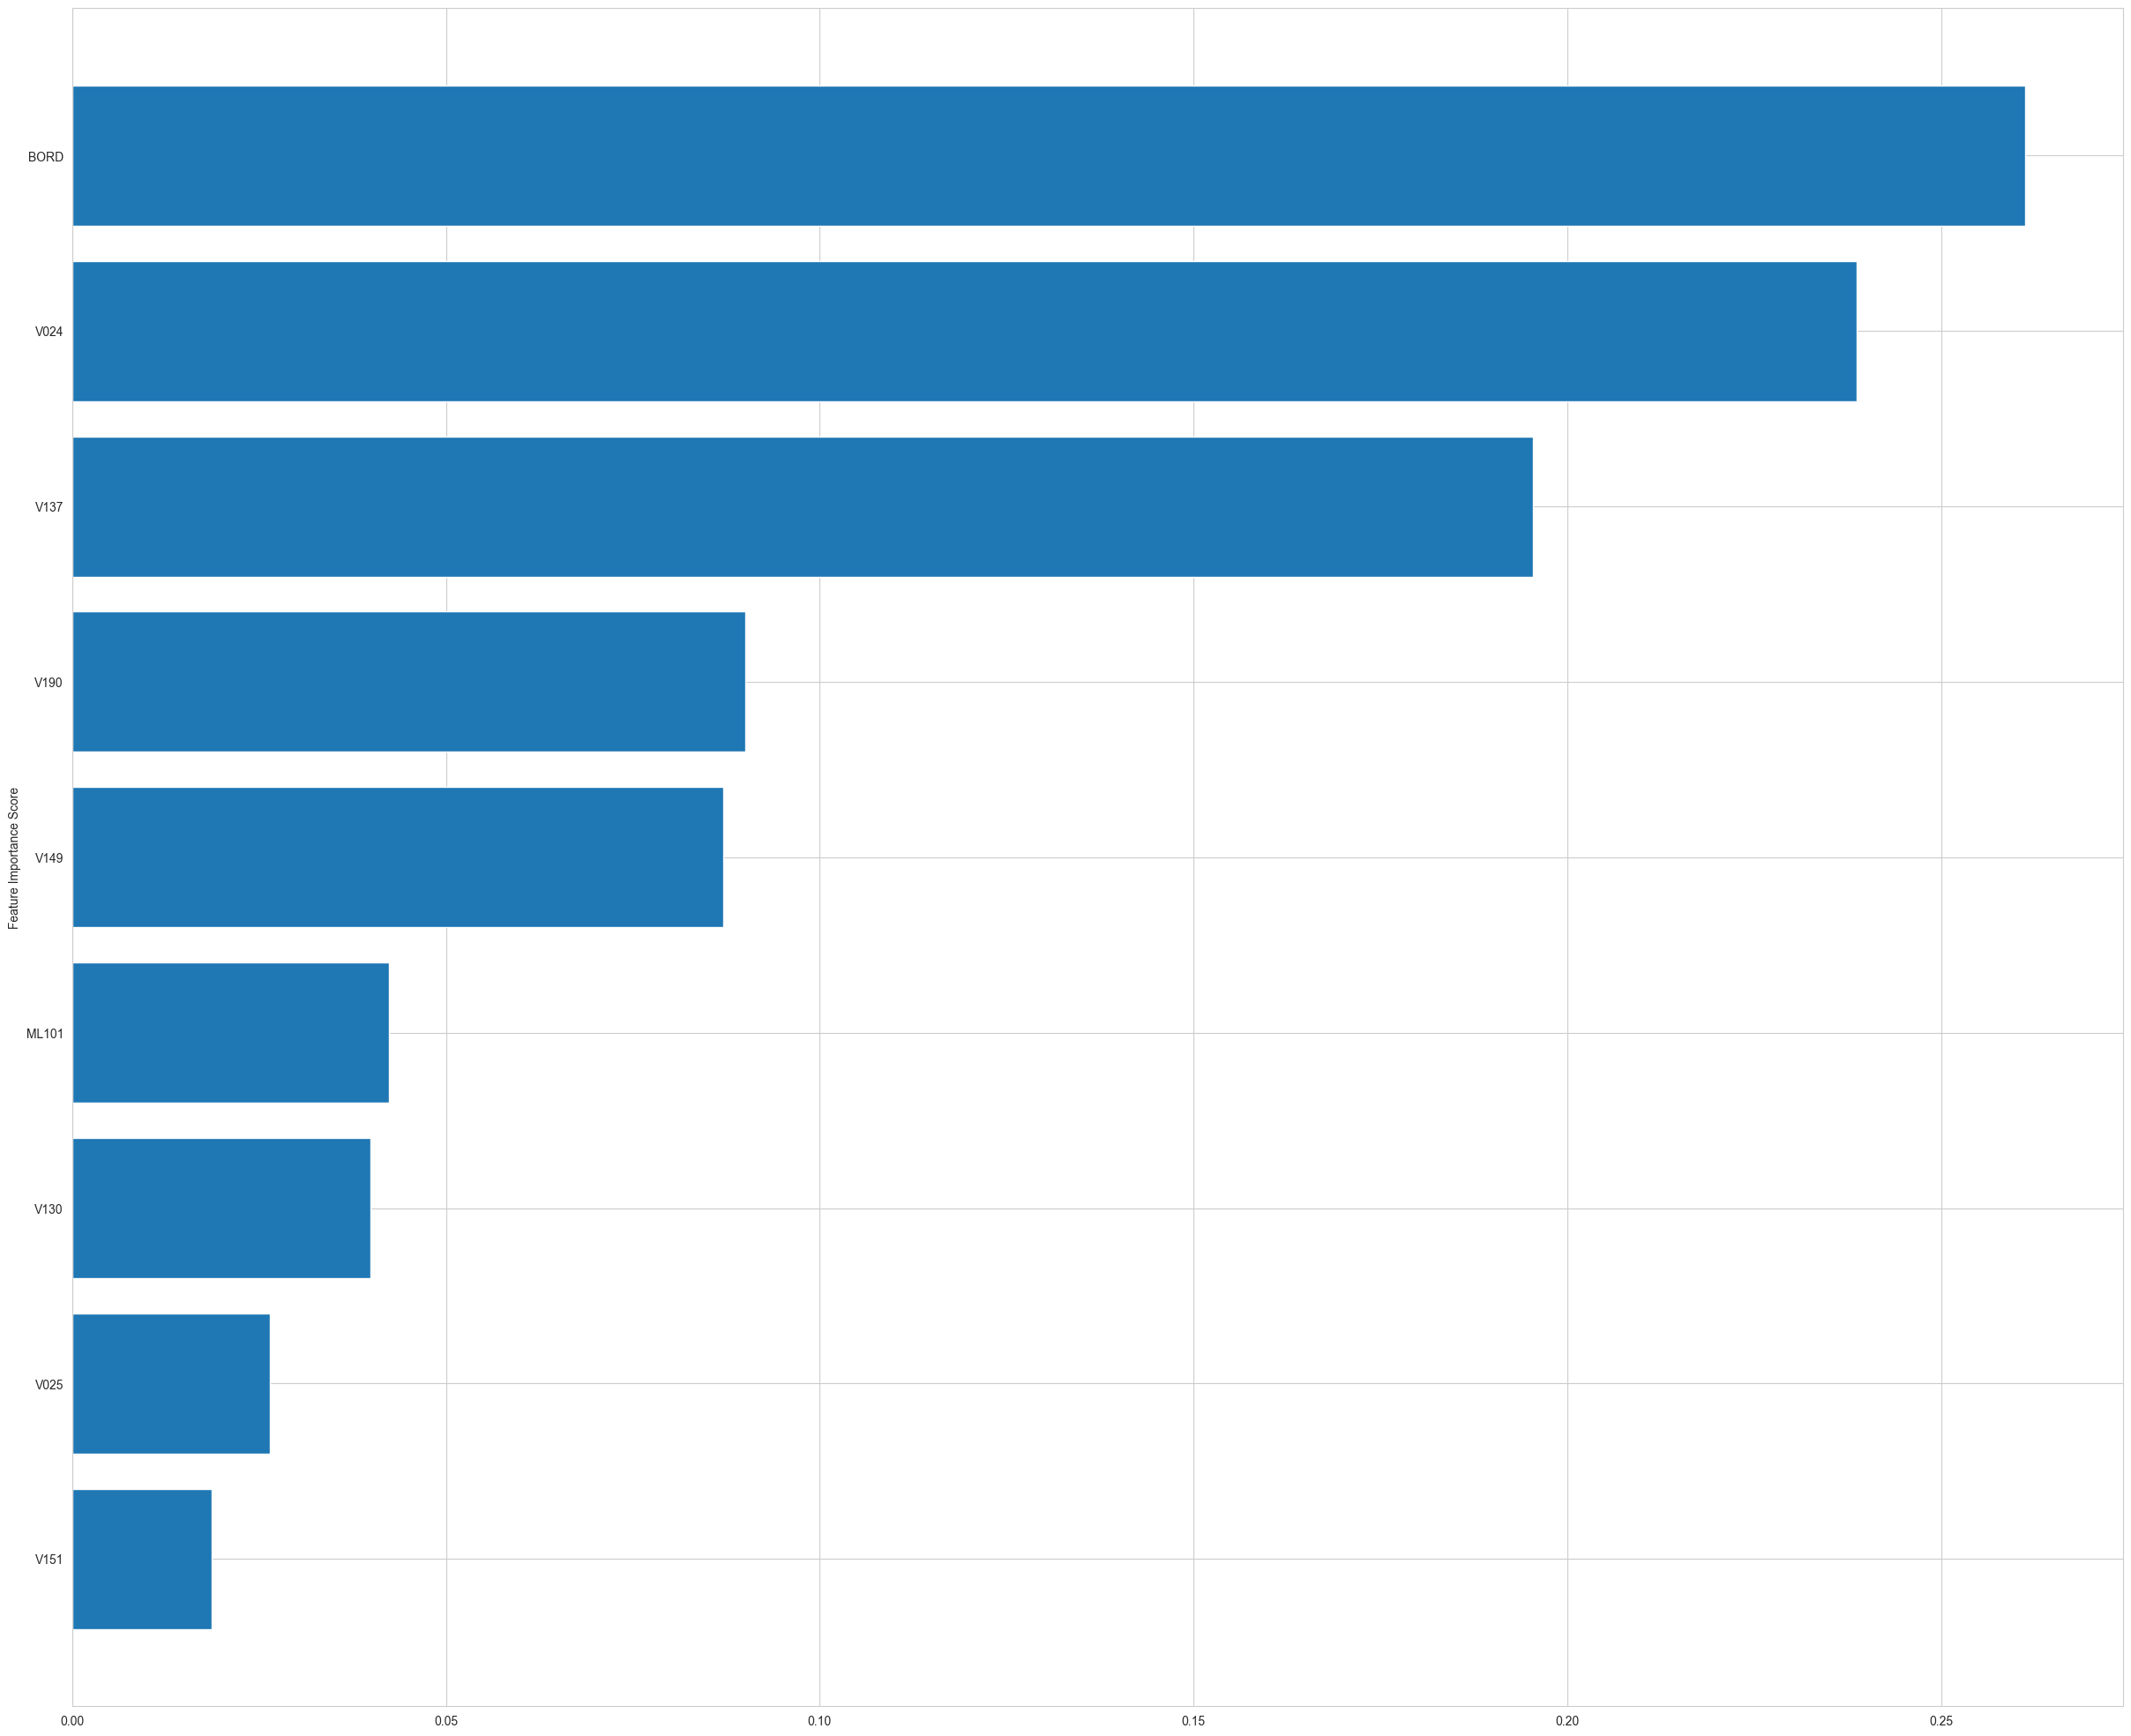

0.9942483578447495 0.9942483578447495 0.0001407573649058614
104/104 [==============================] - 0s 342us/step
7076     1
10080    1
12566    1
10222    0
13710    1
        ..
14856    1
9366     1
5048     1
11907    1
10408    0
Name: HML32$01, Length: 3297, dtype: int64
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1007, 2290]))
{'0': {'precision': 0.6067527308838133, 'recall': 0.3705275924802911, 'f1-score': 0.46009036144578314, 'support': 1649}, '1': {'precision': 0.5467248908296943, 'recall': 0.7597087378640777, 'f1-score': 0.6358557643473846, 'support': 1648}, 'accuracy': 0.565059144676979, 'macro avg': {'precision': 0.5767388108567538, 'recall': 0.5651181651721844, 'f1-score': 0.5479730628965839, 'support': 3297}, 'weighted avg': {'precision': 0.5767479142598558, 'recall': 0.565059144676979, 'f1-score': 0.5479464075427922, 'support': 3297}}
Accuracy 0.565059144676979
Precision 0.5467248908296943
Recall 0.7597087378640777
F1 Score 0.63585576

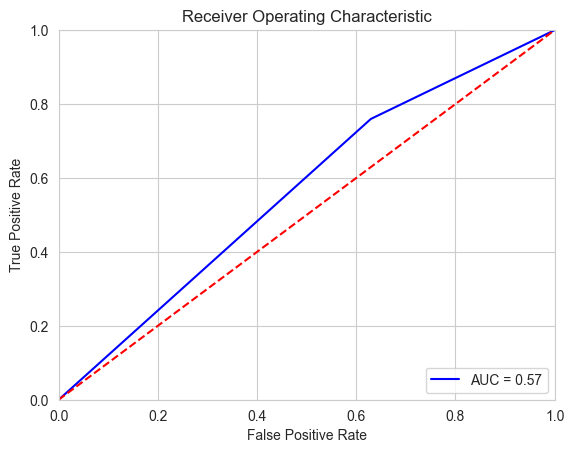

Normalized confusion matrix


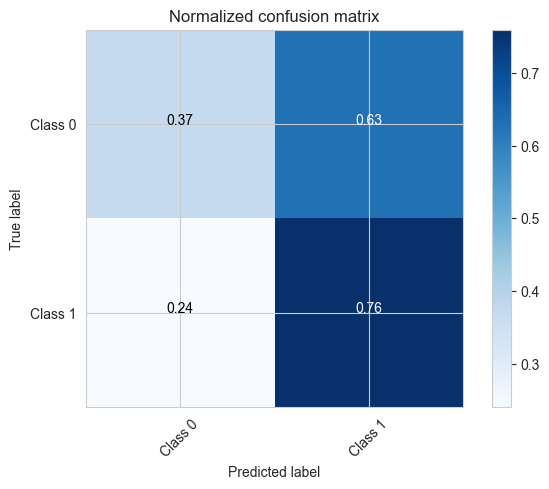

Metrics for the  Evaluation is {'accuracy': 0.565059144676979, 'precision': 0.5467248908296943, 'recall': 0.7597087378640777, 'f1': 0.6358557643473846}
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([2023, 1274]))
{'0': {'precision': 0.7162629757785467, 'recall': 0.8787143723468769, 'f1-score': 0.7892156862745098, 'support': 1649}, '1': {'precision': 0.8430141287284144, 'recall': 0.6516990291262136, 'f1-score': 0.7351129363449692, 'support': 1648}, 'accuracy': 0.7652411282984531, 'macro avg': {'precision': 0.7796385522534806, 'recall': 0.7652067007365453, 'f1-score': 0.7621643113097395, 'support': 3297}, 'weighted avg': {'precision': 0.779619330058614, 'recall': 0.7652411282984531, 'f1-score': 0.7621725161550428, 'support': 3297}}
Accuracy 0.7652411282984531
Precision 0.8430141287284144
Recall 0.6516990291262136
F1 Score 0.7351129363449692
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.88      0.7

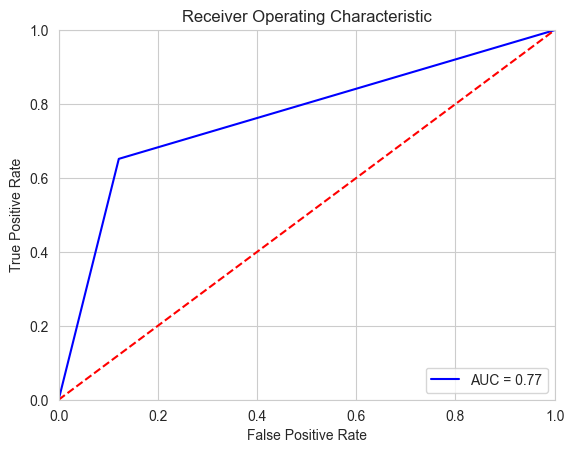

Normalized confusion matrix


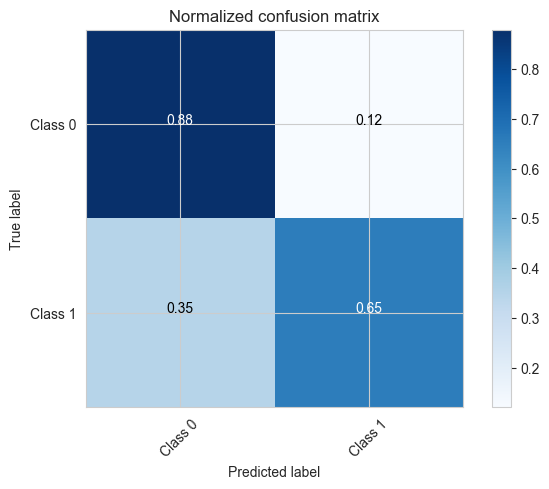

Metrics for the  Evaluation is {'accuracy': 0.7652411282984531, 'precision': 0.8430141287284144, 'recall': 0.6516990291262136, 'f1': 0.7351129363449692}
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1901, 1396]))
{'0': {'precision': 0.7448711204629143, 'recall': 0.8587022437841115, 'f1-score': 0.7977464788732394, 'support': 1649}, '1': {'precision': 0.8330945558739254, 'recall': 0.7057038834951457, 'f1-score': 0.764126149802891, 'support': 1648}, 'accuracy': 0.7822262663026994, 'macro avg': {'precision': 0.7889828381684199, 'recall': 0.7822030636396287, 'f1-score': 0.7809363143380652, 'support': 3297}, 'weighted avg': {'precision': 0.7889694588181906, 'recall': 0.7822262663026994, 'f1-score': 0.7809414129624311, 'support': 3297}}
Accuracy 0.7822262663026994
Precision 0.8330945558739254
Recall 0.7057038834951457
F1 Score 0.764126149802891
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.86      0.8

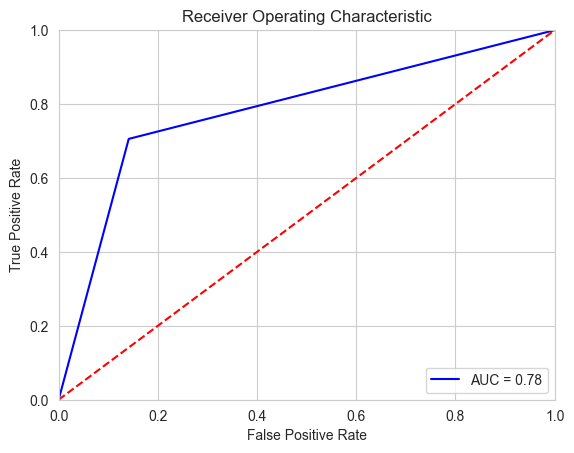

Normalized confusion matrix


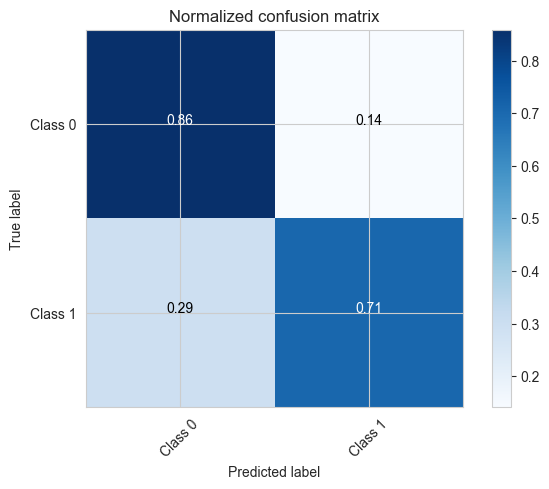

Metrics for the  Evaluation is {'accuracy': 0.7822262663026994, 'precision': 0.8330945558739254, 'recall': 0.7057038834951457, 'f1': 0.764126149802891}
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1289, 2008]))
{'0': {'precision': 0.5880527540729248, 'recall': 0.45967252880533654, 'f1-score': 0.515997277059224, 'support': 1649}, '1': {'precision': 0.5562749003984063, 'recall': 0.6777912621359223, 'f1-score': 0.6110503282275711, 'support': 1648}, 'accuracy': 0.5686988171064604, 'macro avg': {'precision': 0.5721638272356655, 'recall': 0.5687318954706294, 'f1-score': 0.5635238026433975, 'support': 3297}, 'weighted avg': {'precision': 0.5721686464430775, 'recall': 0.5686988171064604, 'f1-score': 0.5635093875613277, 'support': 3297}}
Accuracy 0.5686988171064604
Precision 0.5562749003984063
Recall 0.6777912621359223
F1 Score 0.6110503282275711
Classification Report
              precision    recall  f1-score   support

           0       0.59      0.46      0.

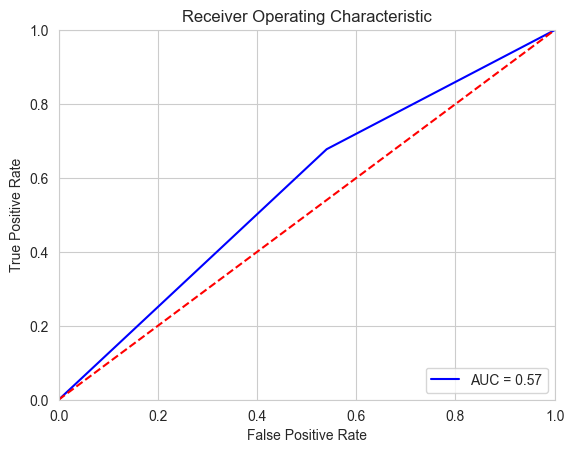

Normalized confusion matrix


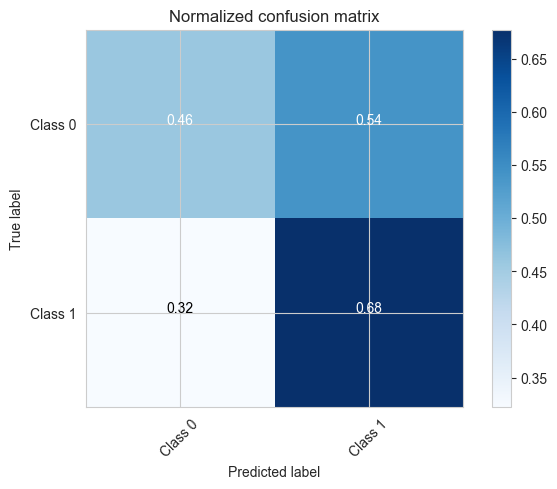

Metrics for the  Evaluation is {'accuracy': 0.5686988171064604, 'precision': 0.5562749003984063, 'recall': 0.6777912621359223, 'f1': 0.6110503282275711}
Unique instance  (array([0, 1]), array([1649, 1648])) (array([0, 1]), array([1672, 1625]))
{'0': {'precision': 0.7858851674641149, 'recall': 0.7968465736810187, 'f1-score': 0.7913279132791328, 'support': 1649}, '1': {'precision': 0.7938461538461539, 'recall': 0.7827669902912622, 'f1-score': 0.7882676443629697, 'support': 1648}, 'accuracy': 0.7898089171974523, 'macro avg': {'precision': 0.7898656606551344, 'recall': 0.7898067819861405, 'f1-score': 0.7897977788210513, 'support': 3297}, 'weighted avg': {'precision': 0.7898644533475242, 'recall': 0.7898089171974523, 'f1-score': 0.7897982429200678, 'support': 3297}}
Accuracy 0.7898089171974523
Precision 0.7938461538461539
Recall 0.7827669902912622
F1 Score 0.7882676443629697
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.80      0

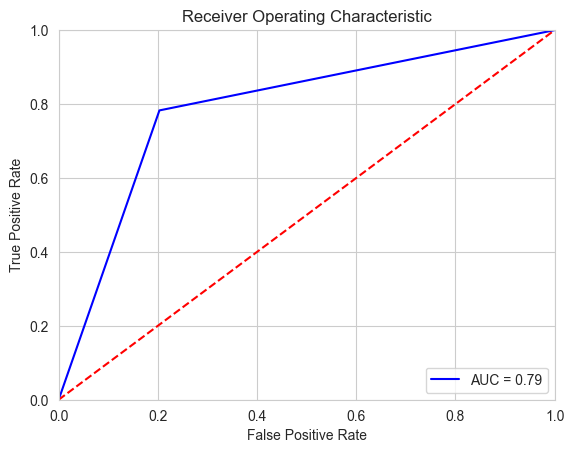

Normalized confusion matrix


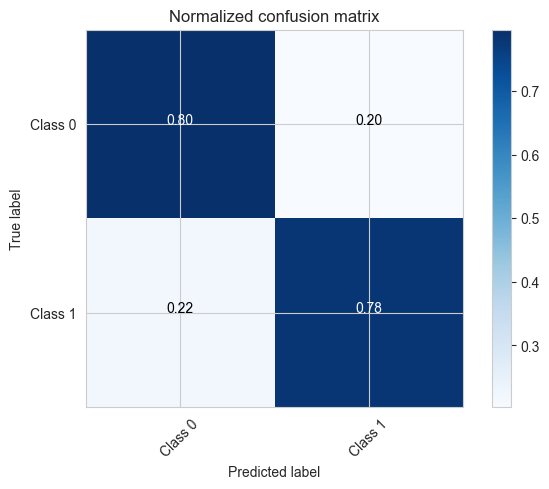

Metrics for the  Evaluation is {'accuracy': 0.7898089171974523, 'precision': 0.7938461538461539, 'recall': 0.7827669902912622, 'f1': 0.7882676443629697}
{'catboost_result': {'accuracy': 0.7652411282984531, 'precision': 0.8430141287284144, 'recall': 0.6516990291262136, 'f1': 0.7351129363449692}, 'xgb': {'accuracy': 0.7822262663026994, 'precision': 0.8330945558739254, 'recall': 0.7057038834951457, 'f1': 0.764126149802891}, 'log': {'accuracy': 0.5686988171064604, 'precision': 0.5562749003984063, 'recall': 0.6777912621359223, 'f1': 0.6110503282275711}, 'neural': {'accuracy': 0.565059144676979, 'precision': 0.5467248908296943, 'recall': 0.7597087378640777, 'f1': 0.6358557643473846}, 'radom_forest': {'accuracy': 0.7898089171974523, 'precision': 0.7938461538461539, 'recall': 0.7827669902912622, 'f1': 0.7882676443629697}}


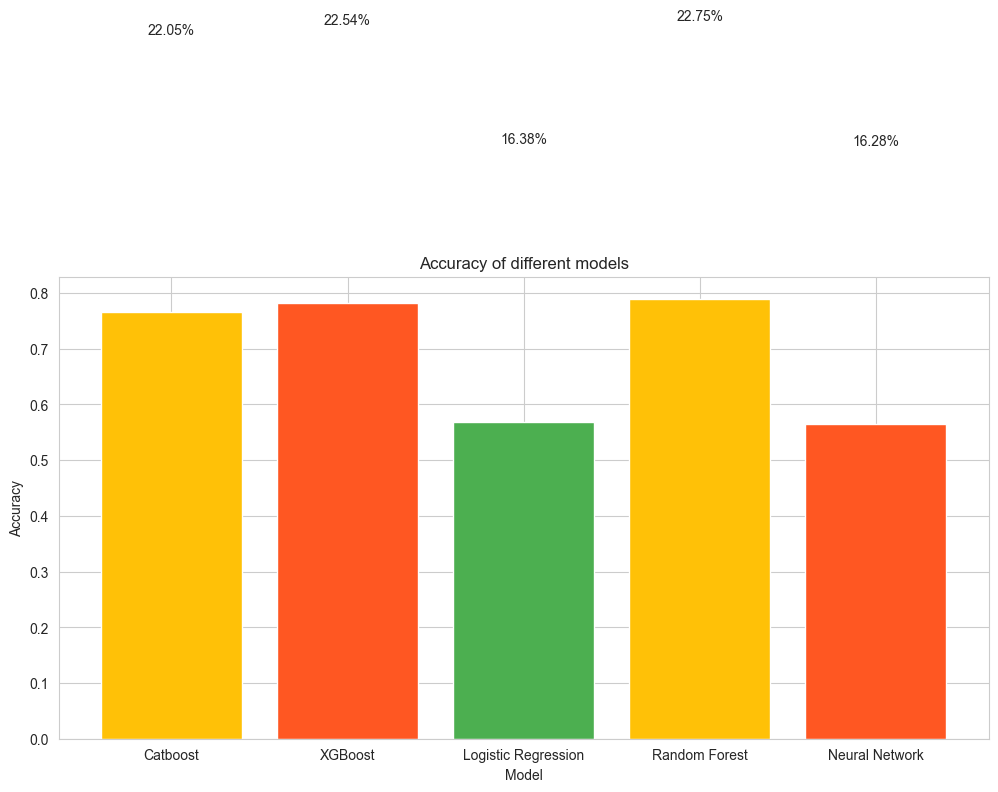

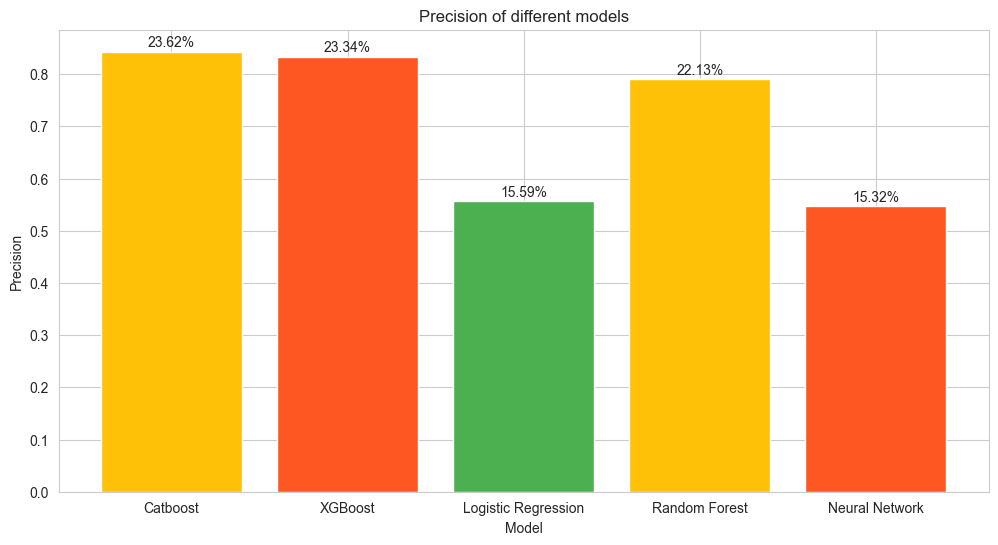

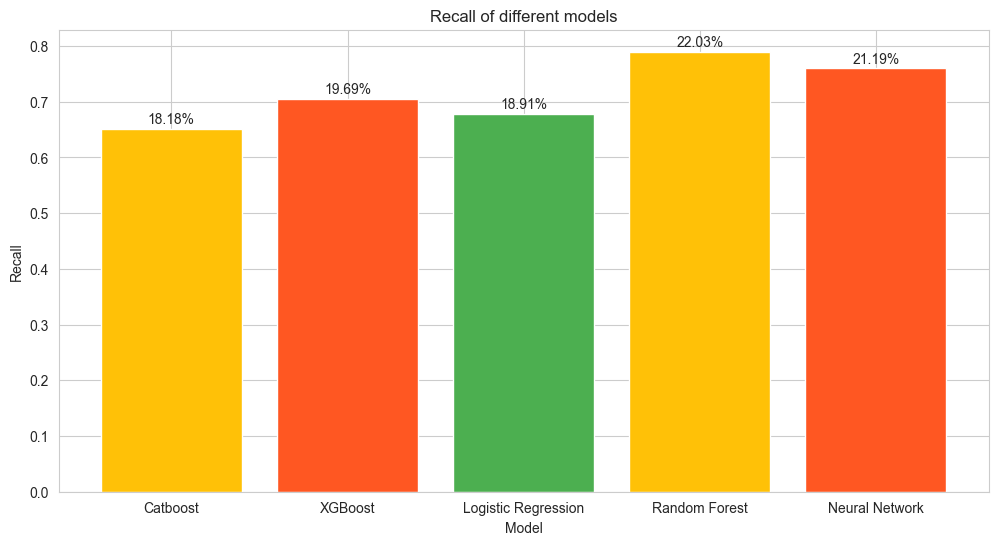

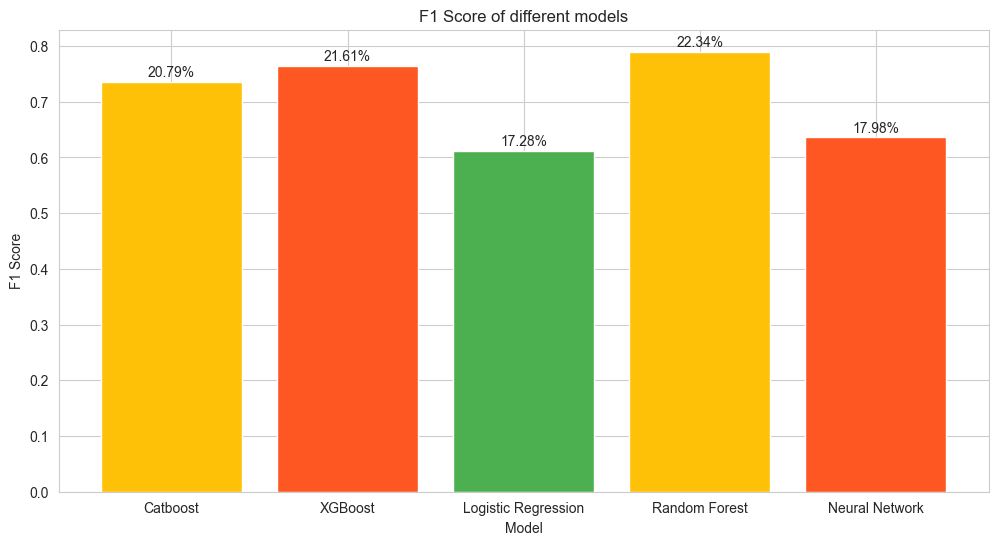

In [36]:
_X, _Y = smote()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad, with_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.5475082060345916 0.6910757585756313
Training scores 0.5736915479277814 0.6845911456811166
================================Fold2====================================

Validation scores 0.5543519544231682 0.6881575958656551
Training scores 0.5703948987549333 0.6854767553686881
================================Fold3====================================

Validation scores 0.5550917866751068 0.6881833179200307
Training scores 0.5705661362012271 0.6852145644306284
================================Fold4====================================

Validation scores 0.5601281848393733 0.6855069741468482
Training scores 0.5680875174079049 0.6859327672459573
================================Fold5====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5795695521443267 0.684801610121422
Training scores 0.5639590394098164 0.6861417653002955


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


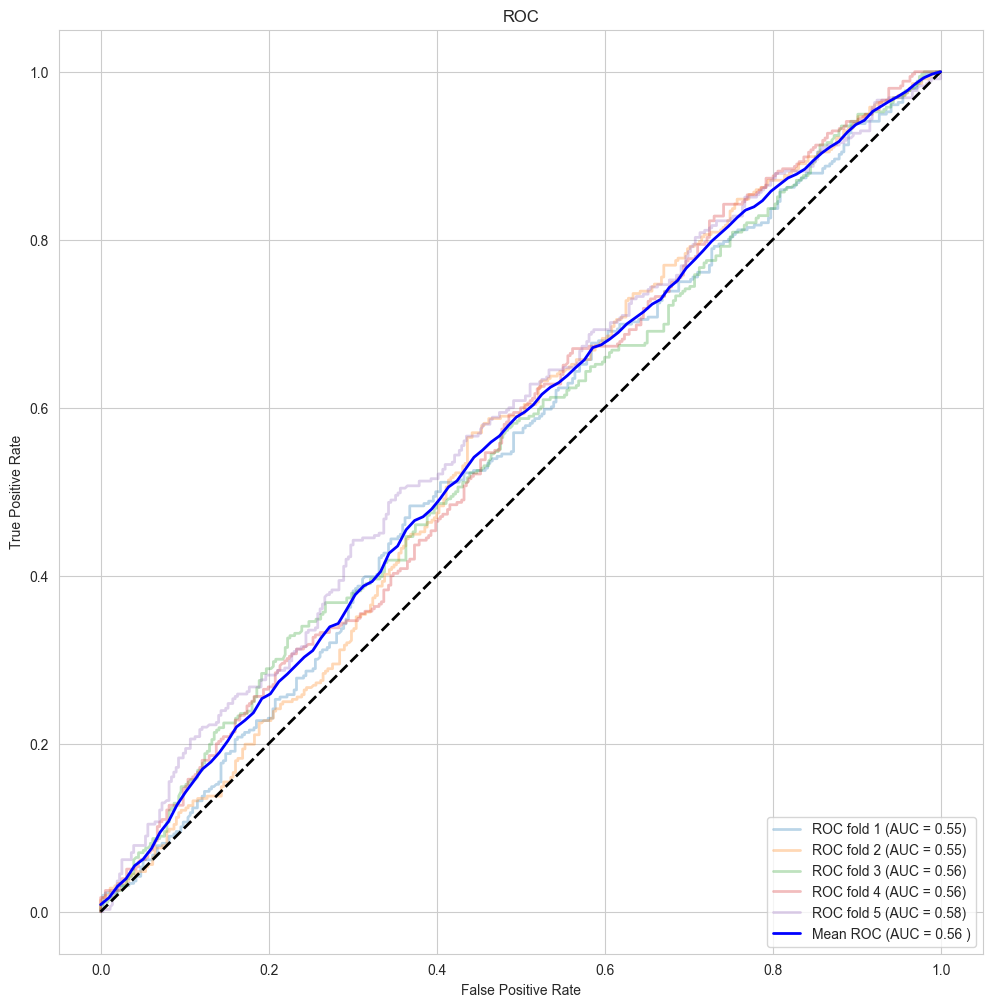

0.5693398279403327 0.5693398279403327 0.0032272477470279876
================================Fold1====================================
0:	learn: 0.5797479	test: 0.5553904	best: 0.5553904 (0)	total: 10.1ms	remaining: 1m 40s
50:	learn: 0.5822766	test: 0.5519442	best: 0.5617978 (6)	total: 71.9ms	remaining: 14s
100:	learn: 0.5987040	test: 0.5393113	best: 0.5617978 (6)	total: 113ms	remaining: 11.1s
150:	learn: 0.6036965	test: 0.5476243	best: 0.5617978 (6)	total: 154ms	remaining: 10s
200:	learn: 0.6117711	test: 0.5433871	best: 0.5617978 (6)	total: 199ms	remaining: 9.7s
250:	learn: 0.6169453	test: 0.5377673	best: 0.5617978 (6)	total: 242ms	remaining: 9.38s
300:	learn: 0.6207876	test: 0.5448145	best: 0.5617978 (6)	total: 284ms	remaining: 9.14s
350:	learn: 0.6295764	test: 0.5377673	best: 0.5617978 (6)	total: 327ms	remaining: 8.98s
400:	learn: 0.6390091	test: 0.5363376	best: 0.5617978 (6)	total: 369ms	remaining: 8.83s
450:	learn: 0.6443512	test: 0.5280303	best: 0.5617978 (6)	total: 412ms	remainin

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


150:	learn: 0.6042178	test: 0.5484732	best: 0.5653751 (16)	total: 133ms	remaining: 8.7s
200:	learn: 0.6098415	test: 0.5527249	best: 0.5653751 (16)	total: 174ms	remaining: 8.5s
250:	learn: 0.6203833	test: 0.5541491	best: 0.5653751 (16)	total: 217ms	remaining: 8.43s
300:	learn: 0.6270249	test: 0.5484964	best: 0.5653751 (16)	total: 272ms	remaining: 8.76s
350:	learn: 0.6344341	test: 0.5513308	best: 0.5653751 (16)	total: 329ms	remaining: 9.03s
400:	learn: 0.6365284	test: 0.5471060	best: 0.5653751 (16)	total: 372ms	remaining: 8.91s
450:	learn: 0.6421381	test: 0.5569568	best: 0.5653751 (16)	total: 418ms	remaining: 8.84s
500:	learn: 0.6505933	test: 0.5668073	best: 0.5682087 (492)	total: 461ms	remaining: 8.75s
550:	learn: 0.6544685	test: 0.5639944	best: 0.5682138 (503)	total: 504ms	remaining: 8.65s
600:	learn: 0.6586957	test: 0.5653905	best: 0.5682138 (503)	total: 547ms	remaining: 8.56s
650:	learn: 0.6653778	test: 0.5611814	best: 0.5682138 (503)	total: 590ms	remaining: 8.48s
700:	learn: 0.67100

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


200:	learn: 0.6143640	test: 0.5321914	best: 0.5527426 (2)	total: 173ms	remaining: 8.45s
250:	learn: 0.6228359	test: 0.5222692	best: 0.5527426 (2)	total: 219ms	remaining: 8.49s
300:	learn: 0.6344369	test: 0.5297684	best: 0.5527426 (2)	total: 263ms	remaining: 8.47s
350:	learn: 0.6383021	test: 0.5270332	best: 0.5527426 (2)	total: 305ms	remaining: 8.39s
400:	learn: 0.6513064	test: 0.5325842	best: 0.5527426 (2)	total: 347ms	remaining: 8.3s
450:	learn: 0.6541254	test: 0.5340326	best: 0.5527426 (2)	total: 389ms	remaining: 8.24s
500:	learn: 0.6608084	test: 0.5337612	best: 0.5527426 (2)	total: 433ms	remaining: 8.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.552742616
bestIteration = 2

Shrink model to first 3 iterations.

Validation scores 0.5677520177243235 0.6921849698778103
Training scores 0.6010380003815161 0.6917055438188001
================================Fold4====================================
0:	learn: 0.5536803	test: 0.5511746	best: 0.5511746 (0)	total: 880u

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


200:	learn: 0.6041029	test: 0.5723858	best: 0.5780340 (194)	total: 177ms	remaining: 8.61s
250:	learn: 0.6115244	test: 0.5738397	best: 0.5794606 (215)	total: 221ms	remaining: 8.57s
300:	learn: 0.6157189	test: 0.5779839	best: 0.5836108 (285)	total: 265ms	remaining: 8.55s
350:	learn: 0.6234169	test: 0.5806729	best: 0.5836108 (285)	total: 310ms	remaining: 8.53s
400:	learn: 0.6350155	test: 0.5821049	best: 0.5836108 (285)	total: 352ms	remaining: 8.44s
450:	learn: 0.6367259	test: 0.5835350	best: 0.5877772 (415)	total: 396ms	remaining: 8.39s
500:	learn: 0.6437117	test: 0.5793740	best: 0.5877772 (415)	total: 438ms	remaining: 8.31s
550:	learn: 0.6471899	test: 0.5792908	best: 0.5877772 (415)	total: 478ms	remaining: 8.2s
600:	learn: 0.6563222	test: 0.5777417	best: 0.5877772 (415)	total: 519ms	remaining: 8.12s
650:	learn: 0.6615783	test: 0.5834328	best: 0.5877772 (415)	total: 562ms	remaining: 8.07s
700:	learn: 0.6637026	test: 0.5778035	best: 0.5877772 (415)	total: 605ms	remaining: 8.02s
750:	learn:

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


250:	learn: 0.6196140	test: 0.5848401	best: 0.6005531 (116)	total: 212ms	remaining: 8.23s
300:	learn: 0.6221225	test: 0.5847793	best: 0.6005531 (116)	total: 255ms	remaining: 8.21s
350:	learn: 0.6316342	test: 0.5828134	best: 0.6005531 (116)	total: 299ms	remaining: 8.21s
400:	learn: 0.6372581	test: 0.5780280	best: 0.6005531 (116)	total: 343ms	remaining: 8.22s
450:	learn: 0.6432337	test: 0.5765461	best: 0.6005531 (116)	total: 393ms	remaining: 8.33s
500:	learn: 0.6516696	test: 0.5711759	best: 0.6005531 (116)	total: 438ms	remaining: 8.3s
550:	learn: 0.6544798	test: 0.5780280	best: 0.6005531 (116)	total: 482ms	remaining: 8.27s
600:	learn: 0.6615112	test: 0.5682194	best: 0.6005531 (116)	total: 526ms	remaining: 8.23s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6005531059
bestIteration = 116

Shrink model to first 117 iterations.

Validation scores 0.6024133565437569 0.6820848613570193
Training scores 0.6381384586949582 0.6738429924542718


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


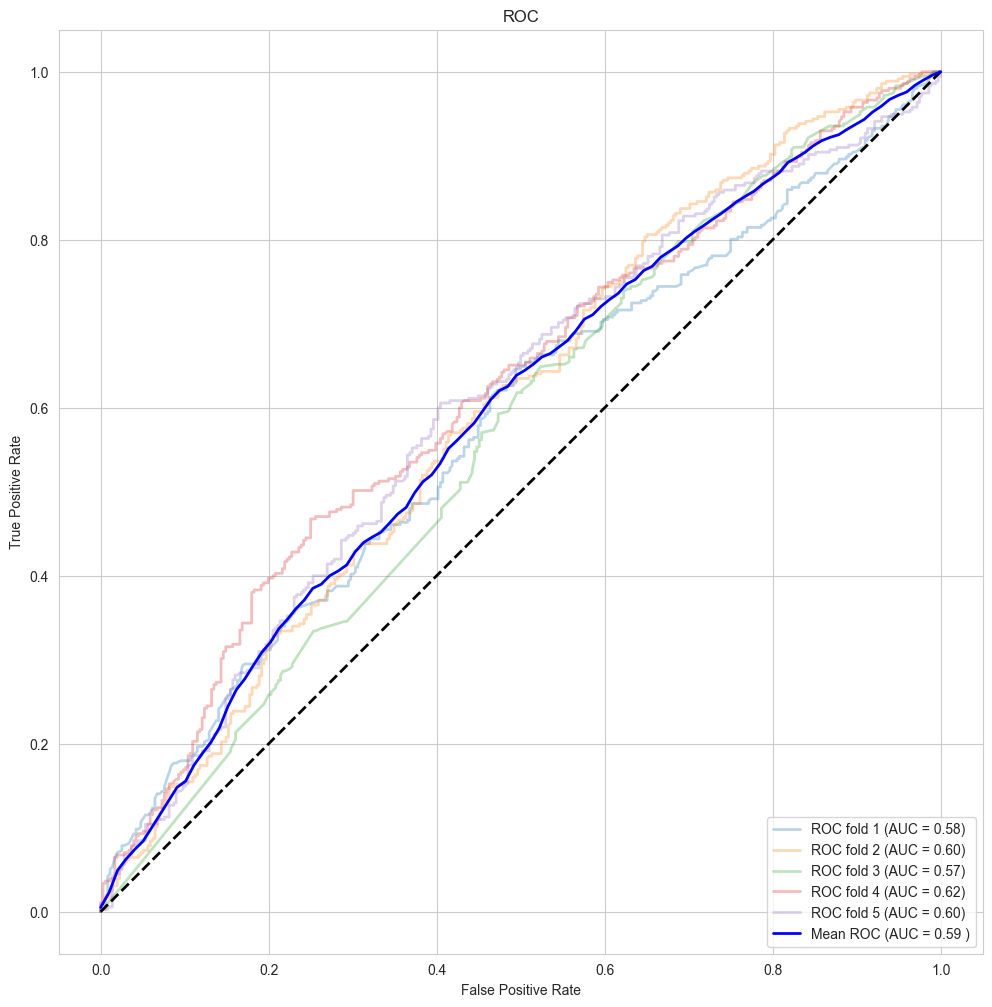

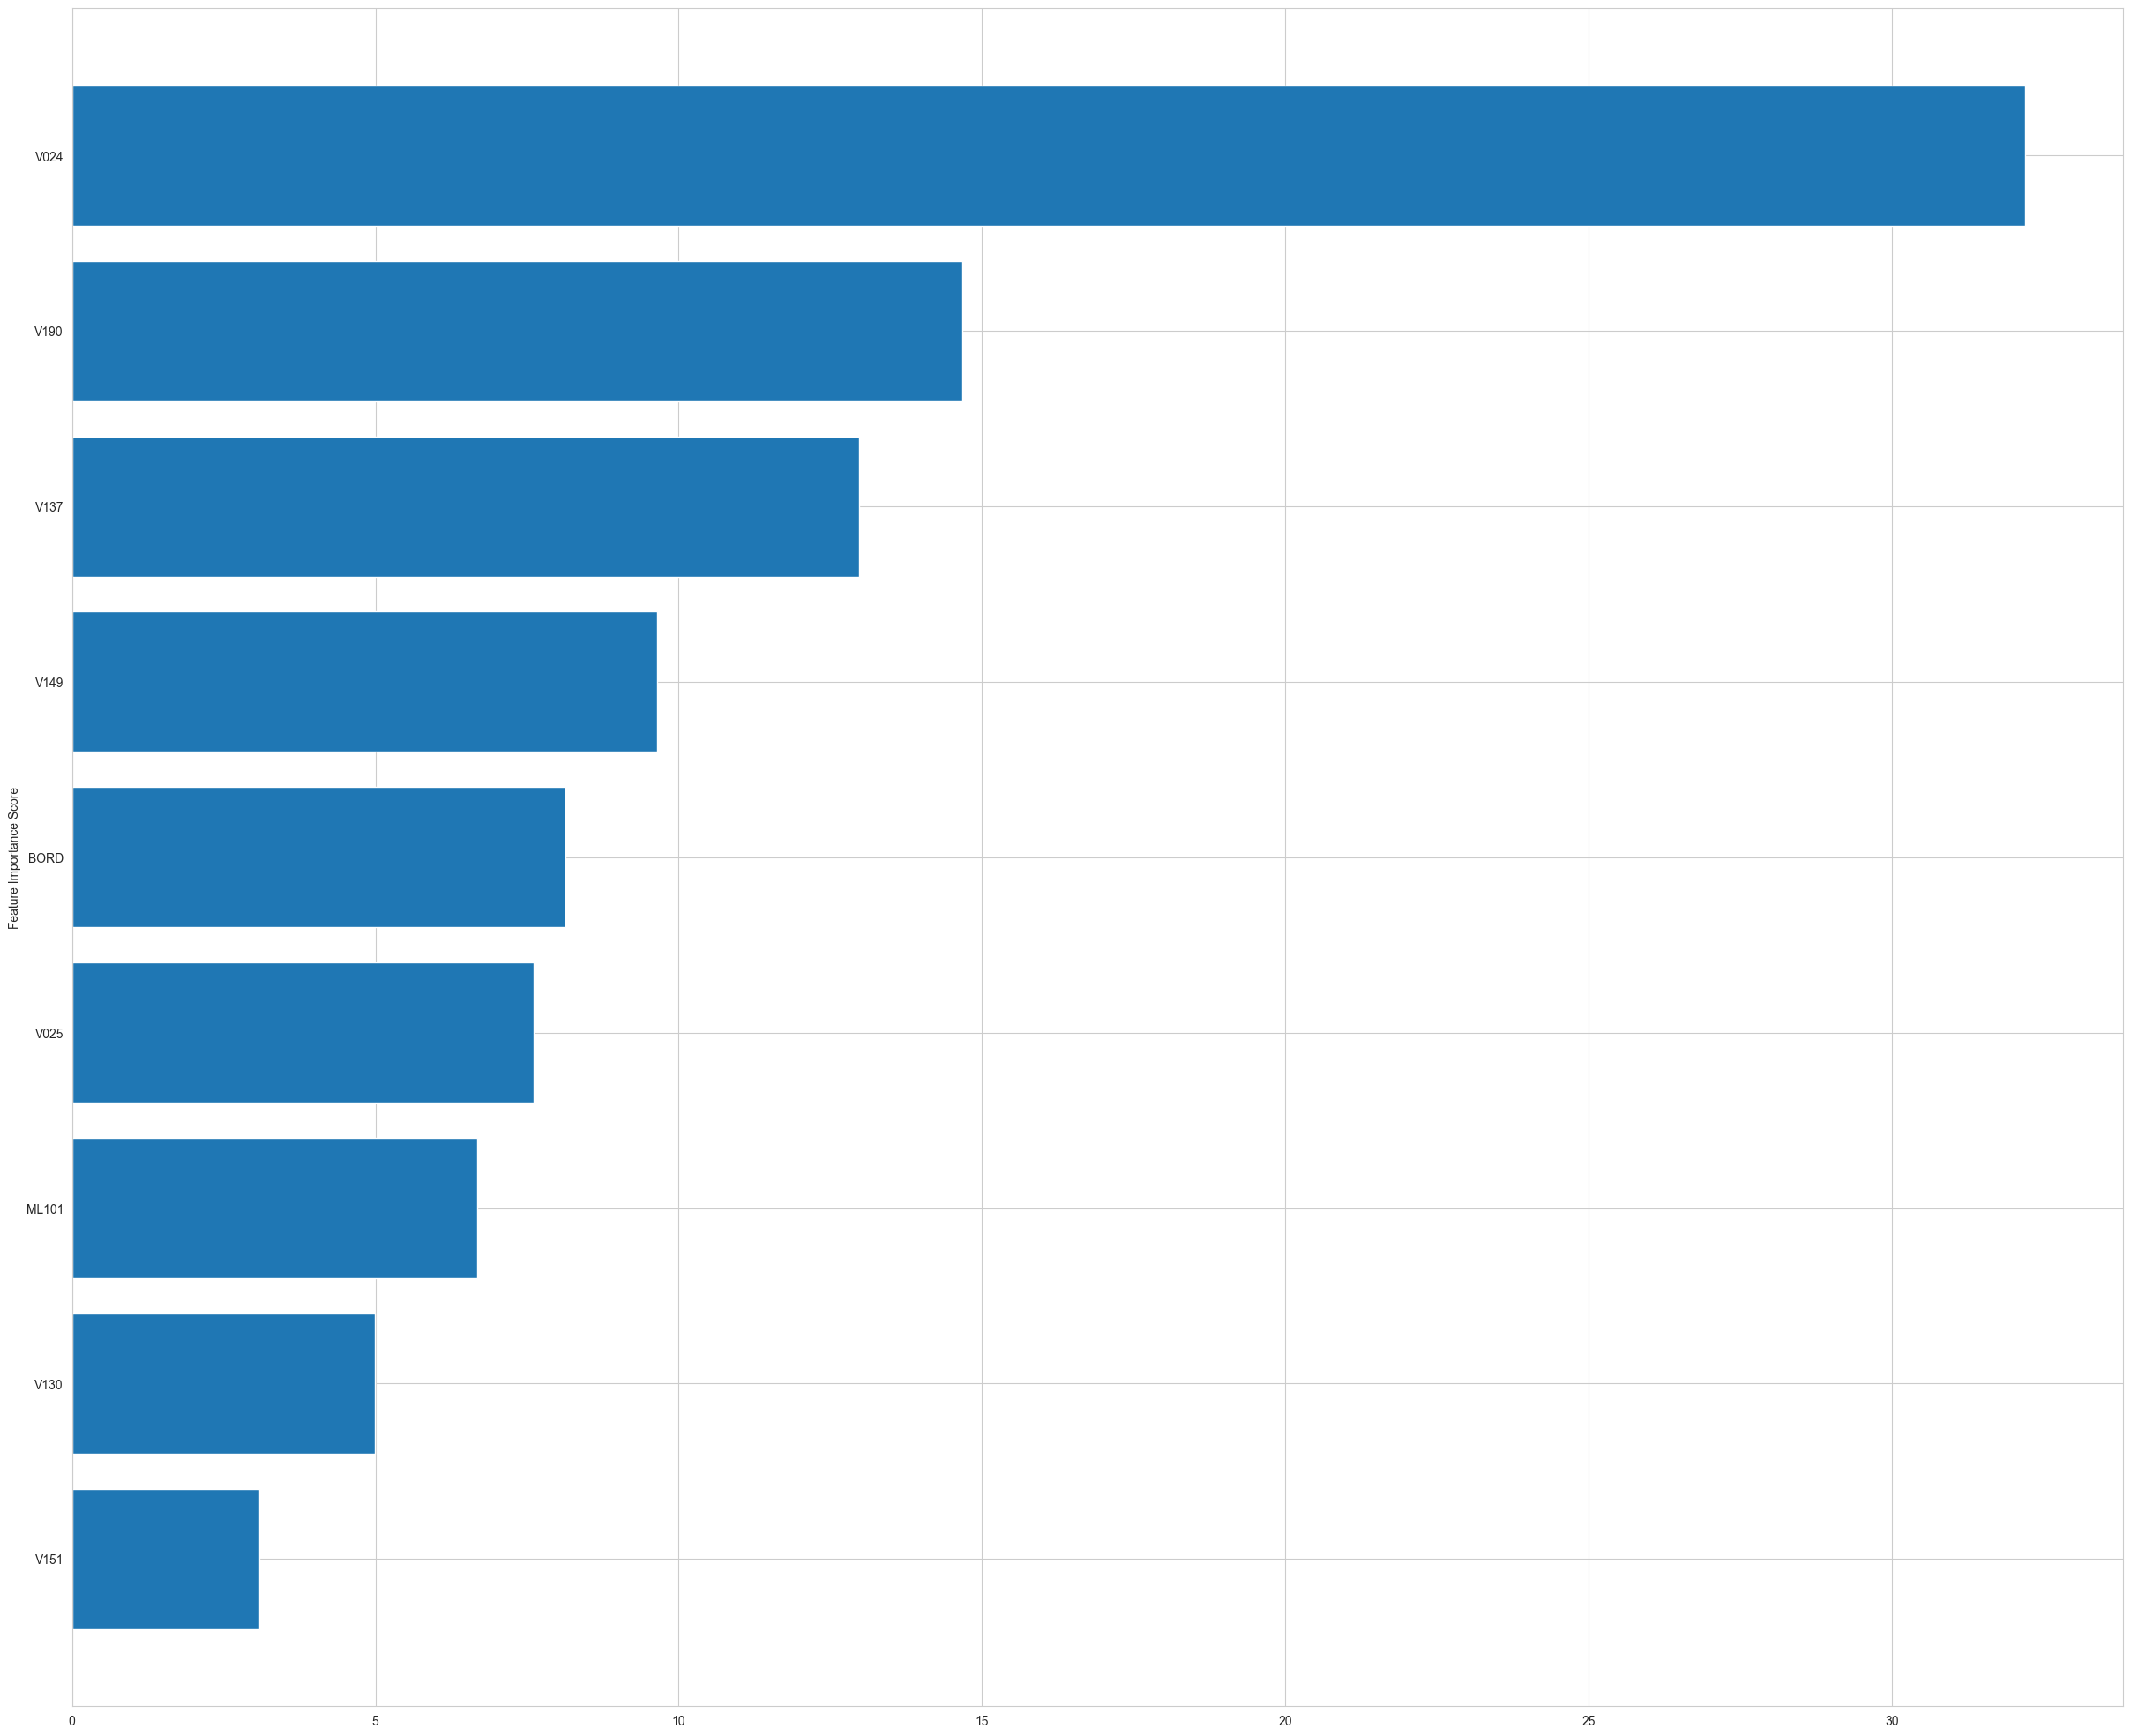

0.6643154264608784 0.6643154264608784 0.06878426315632716
================================Fold1====================================
[09:58:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.56269
[1]	validation_0-auc:0.55767
[2]	validation_0-auc:0.56695
[3]	validation_0-auc:0.56584
[4]	validation_0-auc:0.56829
[5]	validation_0-auc:0.56259
[6]	validation_0-auc:0.56378
[7]	validation_0-auc:0.56354
[8]	validation_0-auc:0.56027
[9]	validation_0-auc:0.55637
[10]	validation_0-auc:0.55875
[11]	validation_0-auc:0.55862
[12]	validation_0-auc:0.56055
[13]	validation_0-auc:0.56200
[14]	validation_0-auc:0.55873
[15]	validation_0-auc:0.55643
[16]	validation_0-auc:0.55662
[17]	validation_0-auc:0.55748
[18]	validation_0-auc:0.55732
[19]	validation_0-auc:0.55483
[20]	validation_0-auc:0.55468
[21]	validation_0-auc:0.55286
[22]	valida

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf

[11]	validation_0-auc:0.55988
[12]	validation_0-auc:0.55799
[13]	validation_0-auc:0.55600
[14]	validation_0-auc:0.55454
[15]	validation_0-auc:0.55415
[16]	validation_0-auc:0.55319
[17]	validation_0-auc:0.55355
[18]	validation_0-auc:0.55423
[19]	validation_0-auc:0.55378
[20]	validation_0-auc:0.55133
[21]	validation_0-auc:0.55154
[22]	validation_0-auc:0.55056
[23]	validation_0-auc:0.54996
[24]	validation_0-auc:0.55021
[25]	validation_0-auc:0.54991
[26]	validation_0-auc:0.55138
[27]	validation_0-auc:0.55096
[28]	validation_0-auc:0.55137
[29]	validation_0-auc:0.55121
[30]	validation_0-auc:0.55118
[31]	validation_0-auc:0.55037
[32]	validation_0-auc:0.54988
[33]	validation_0-auc:0.54900
[34]	validation_0-auc:0.54956
[35]	validation_0-auc:0.54965

Validation scores 0.5661220129767368 0.6863882534149004
Training scores 0.642386778195864 0.6690577495429582
================================Fold4====================================
[09:58:07] WARNING: /Users/runner/work/xgboost/xgboost/python-pack

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:

[54]	validation_0-auc:0.61948

Validation scores 0.6234965975629054 0.6721039617339208
Training scores 0.6765361703894133 0.6533902254339355


/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


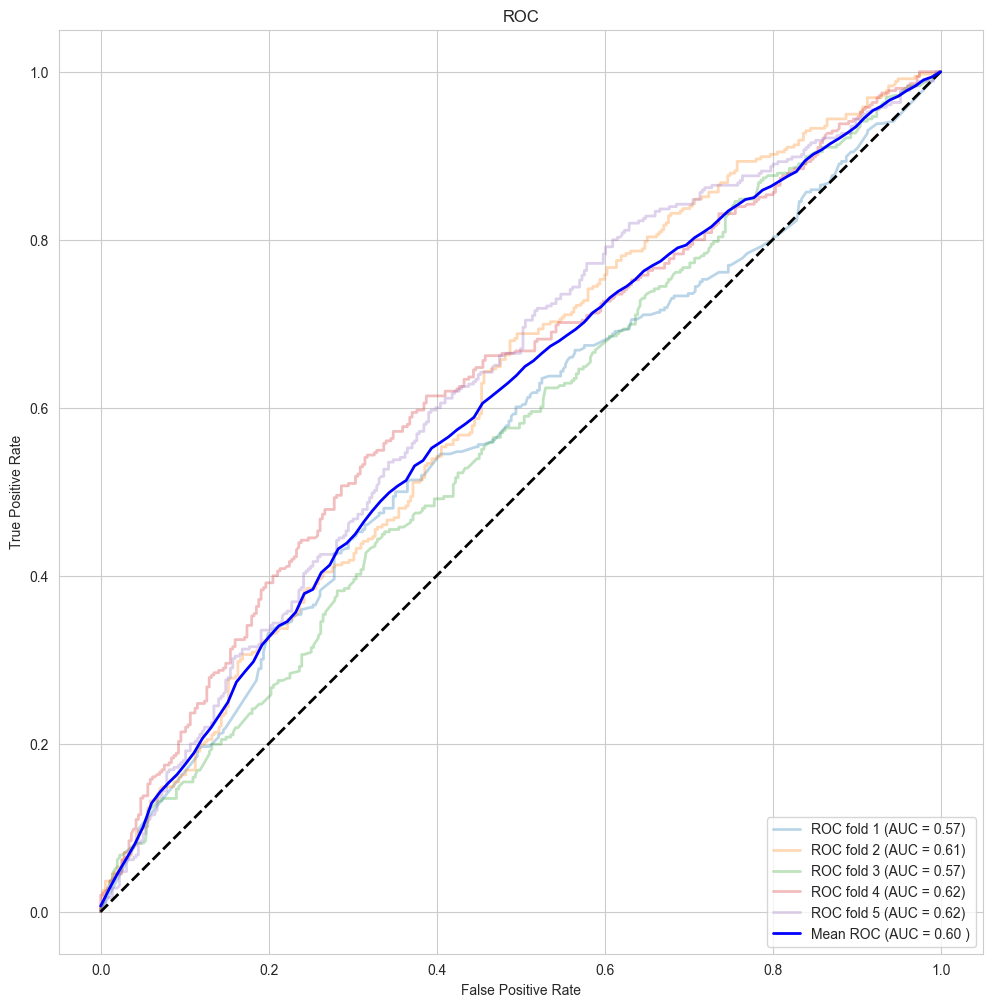

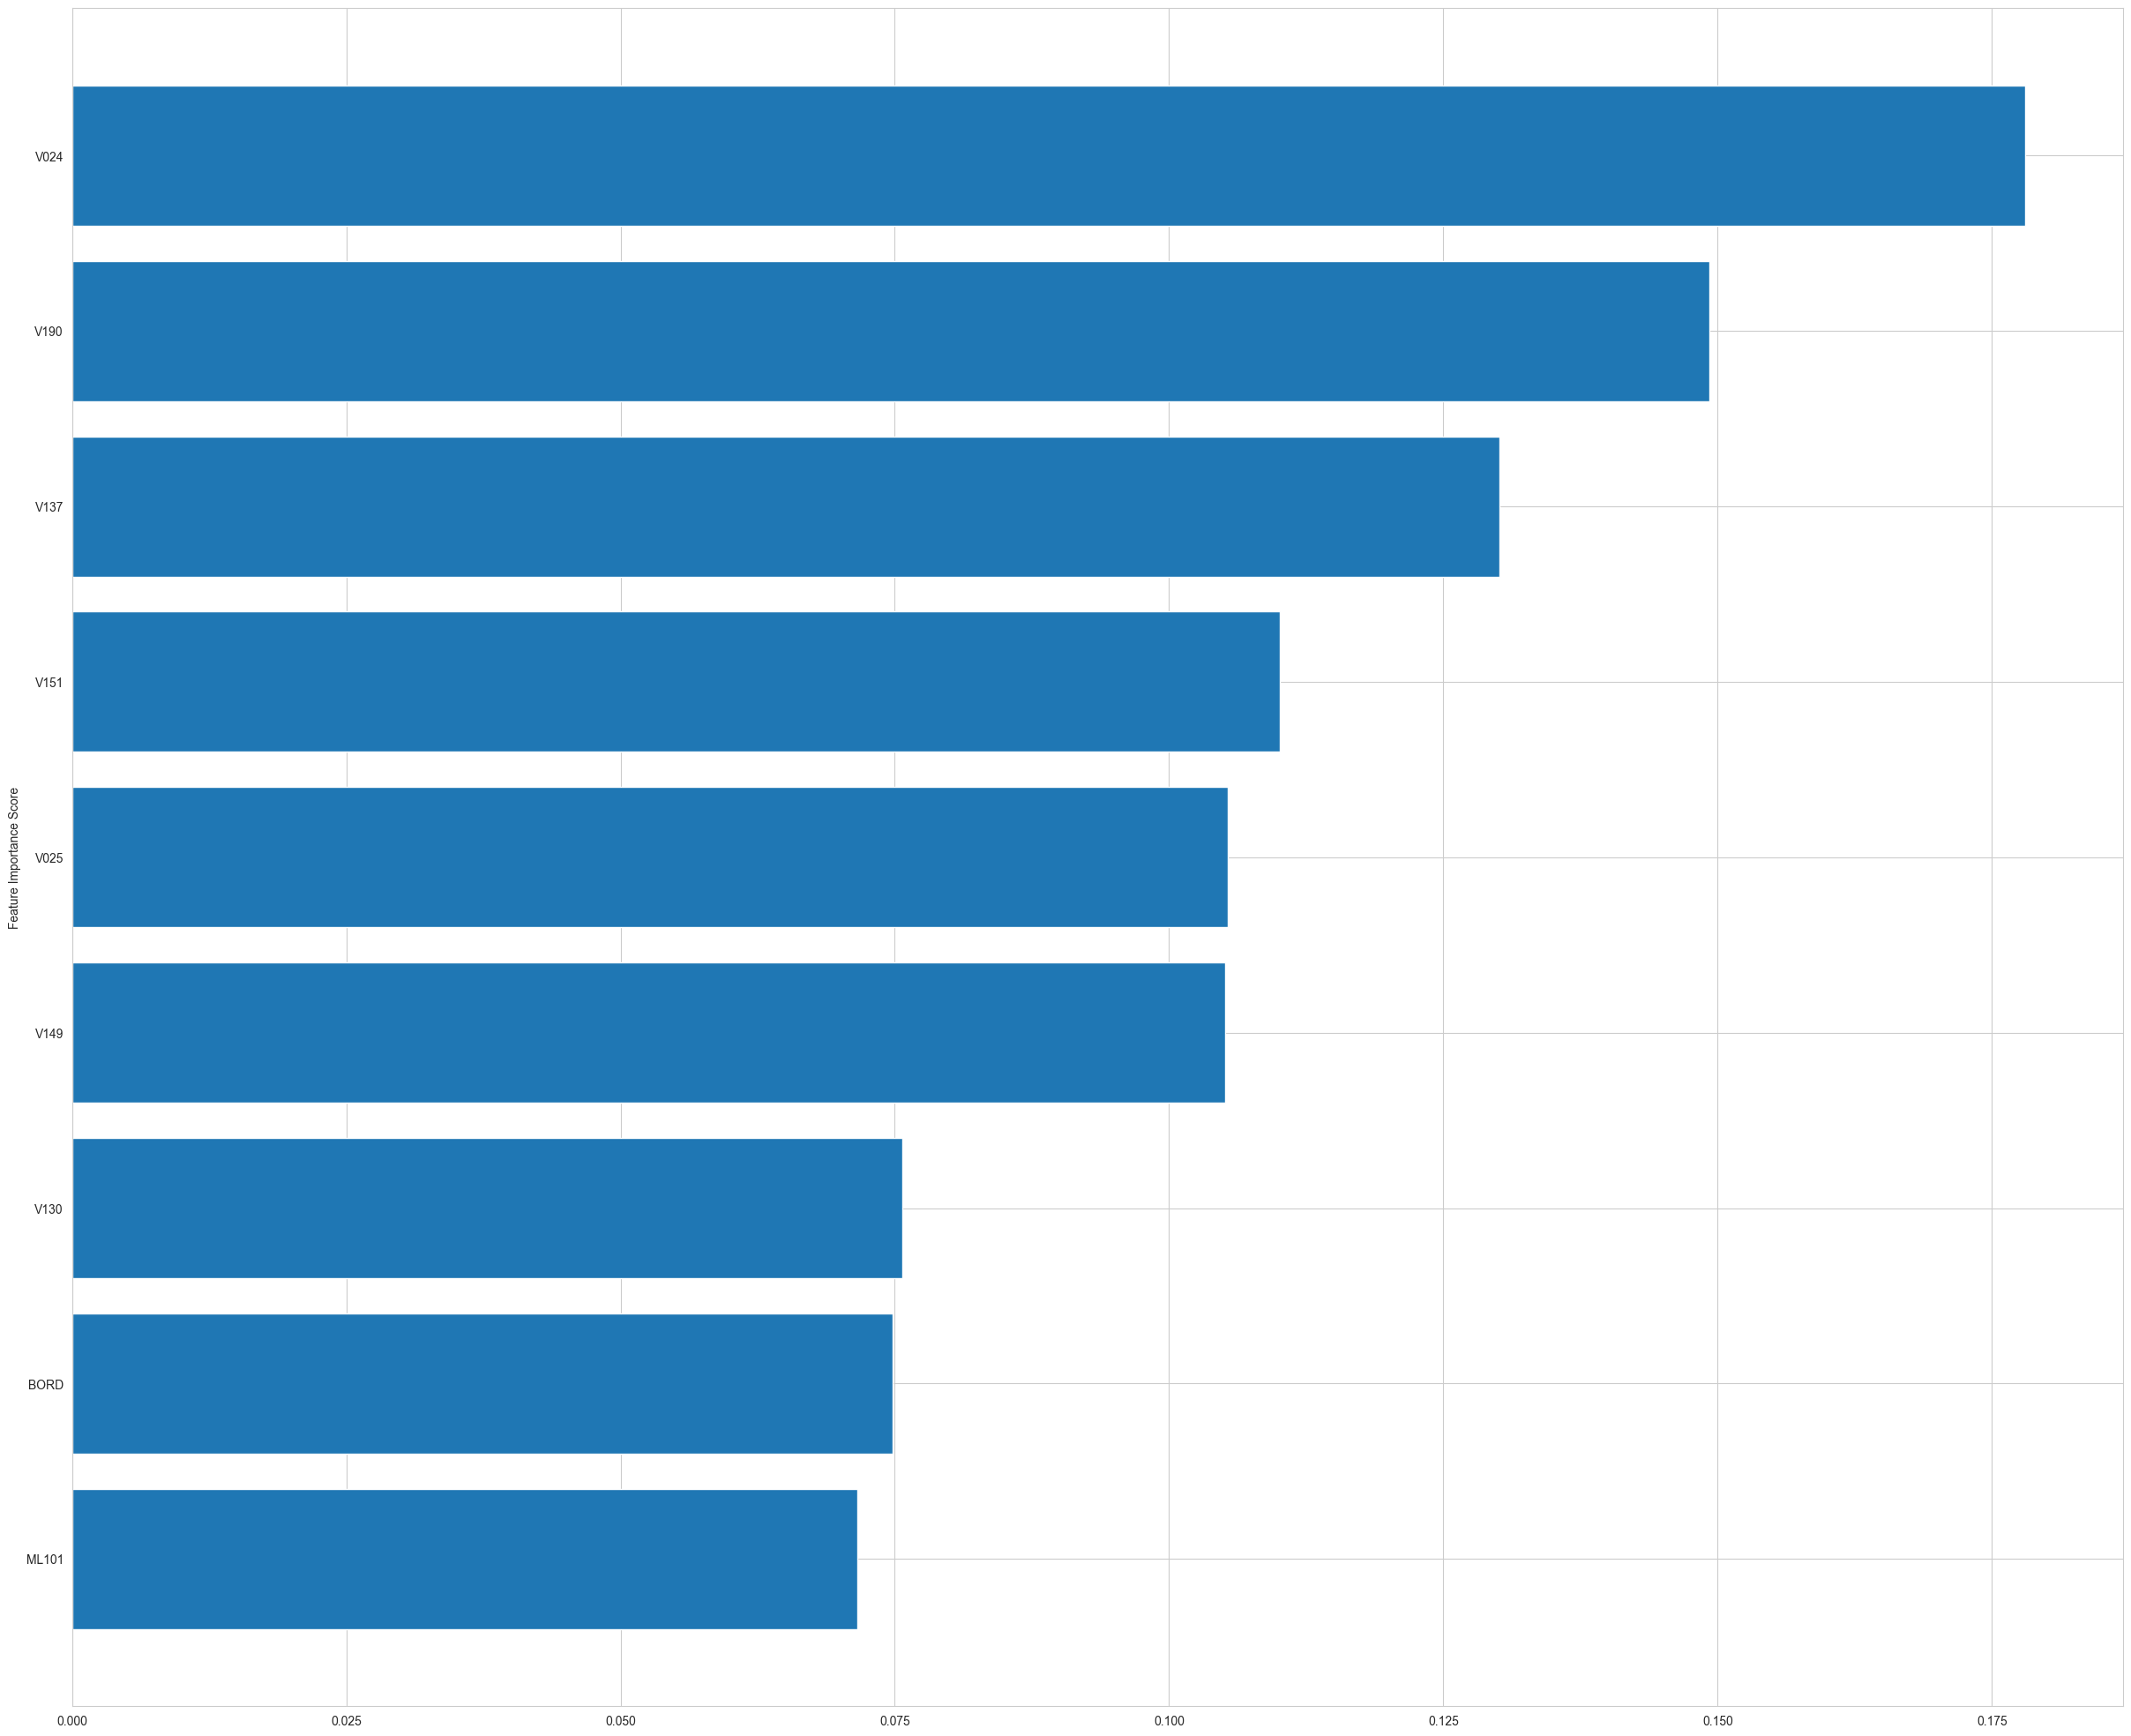

0.6643955428696042 0.6643955428696042 0.02339747103922764
================================Fold1====================================

Validation scores 0.5158163426335058 0.8193026748519918
Training scores 0.995883702160741 0.2340411413839786
================================Fold2====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.537319987339769 0.7848046079319357
Training scores 0.9951616155326448 0.2385923796286127
================================Fold3====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5161892704541857 0.8207246579066826
Training scores 0.9960993444052056 0.2302576311331774
================================Fold4====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.5709131191644248 0.7555253060995496
Training scores 0.9947598376283541 0.24268562829969392
================================Fold5====================================


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))



Validation scores 0.526784301313499 0.7850465783977861
Training scores 0.9954690028099744 0.23500535342415538


/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_18493/4049211938.py:103: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


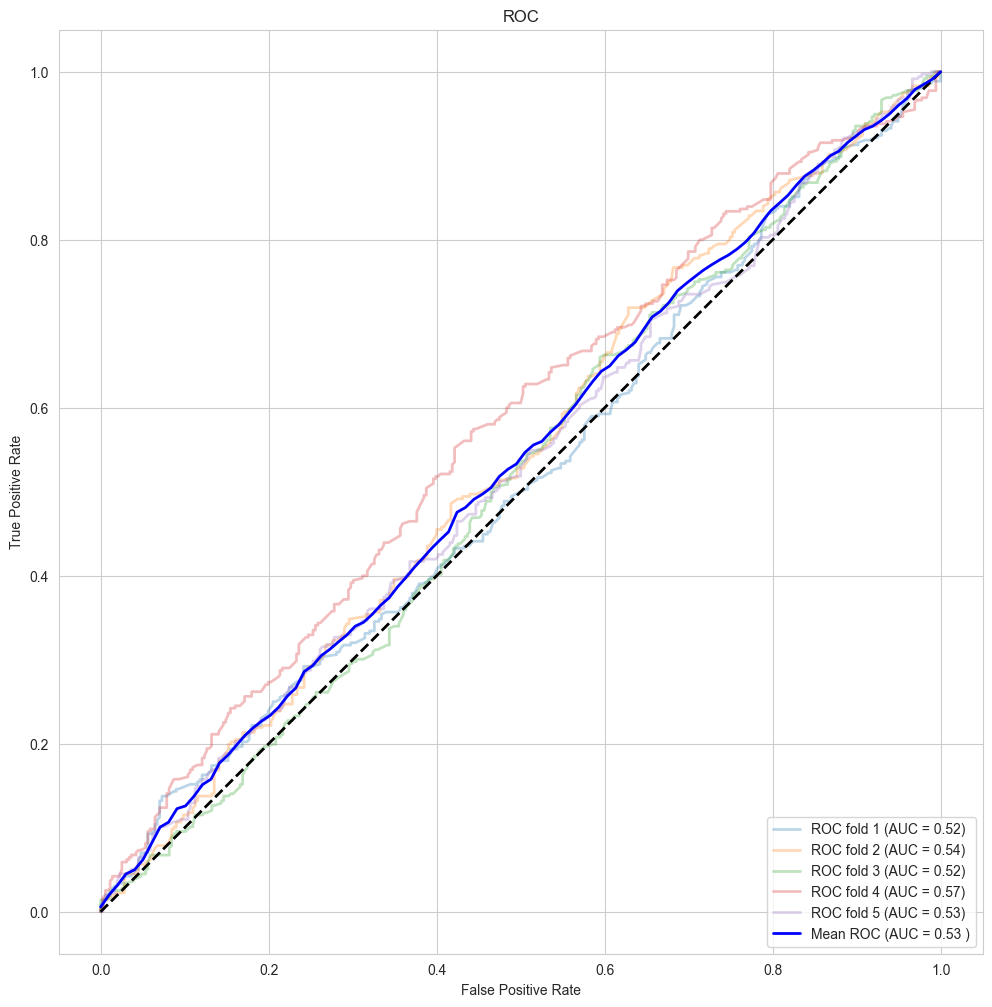

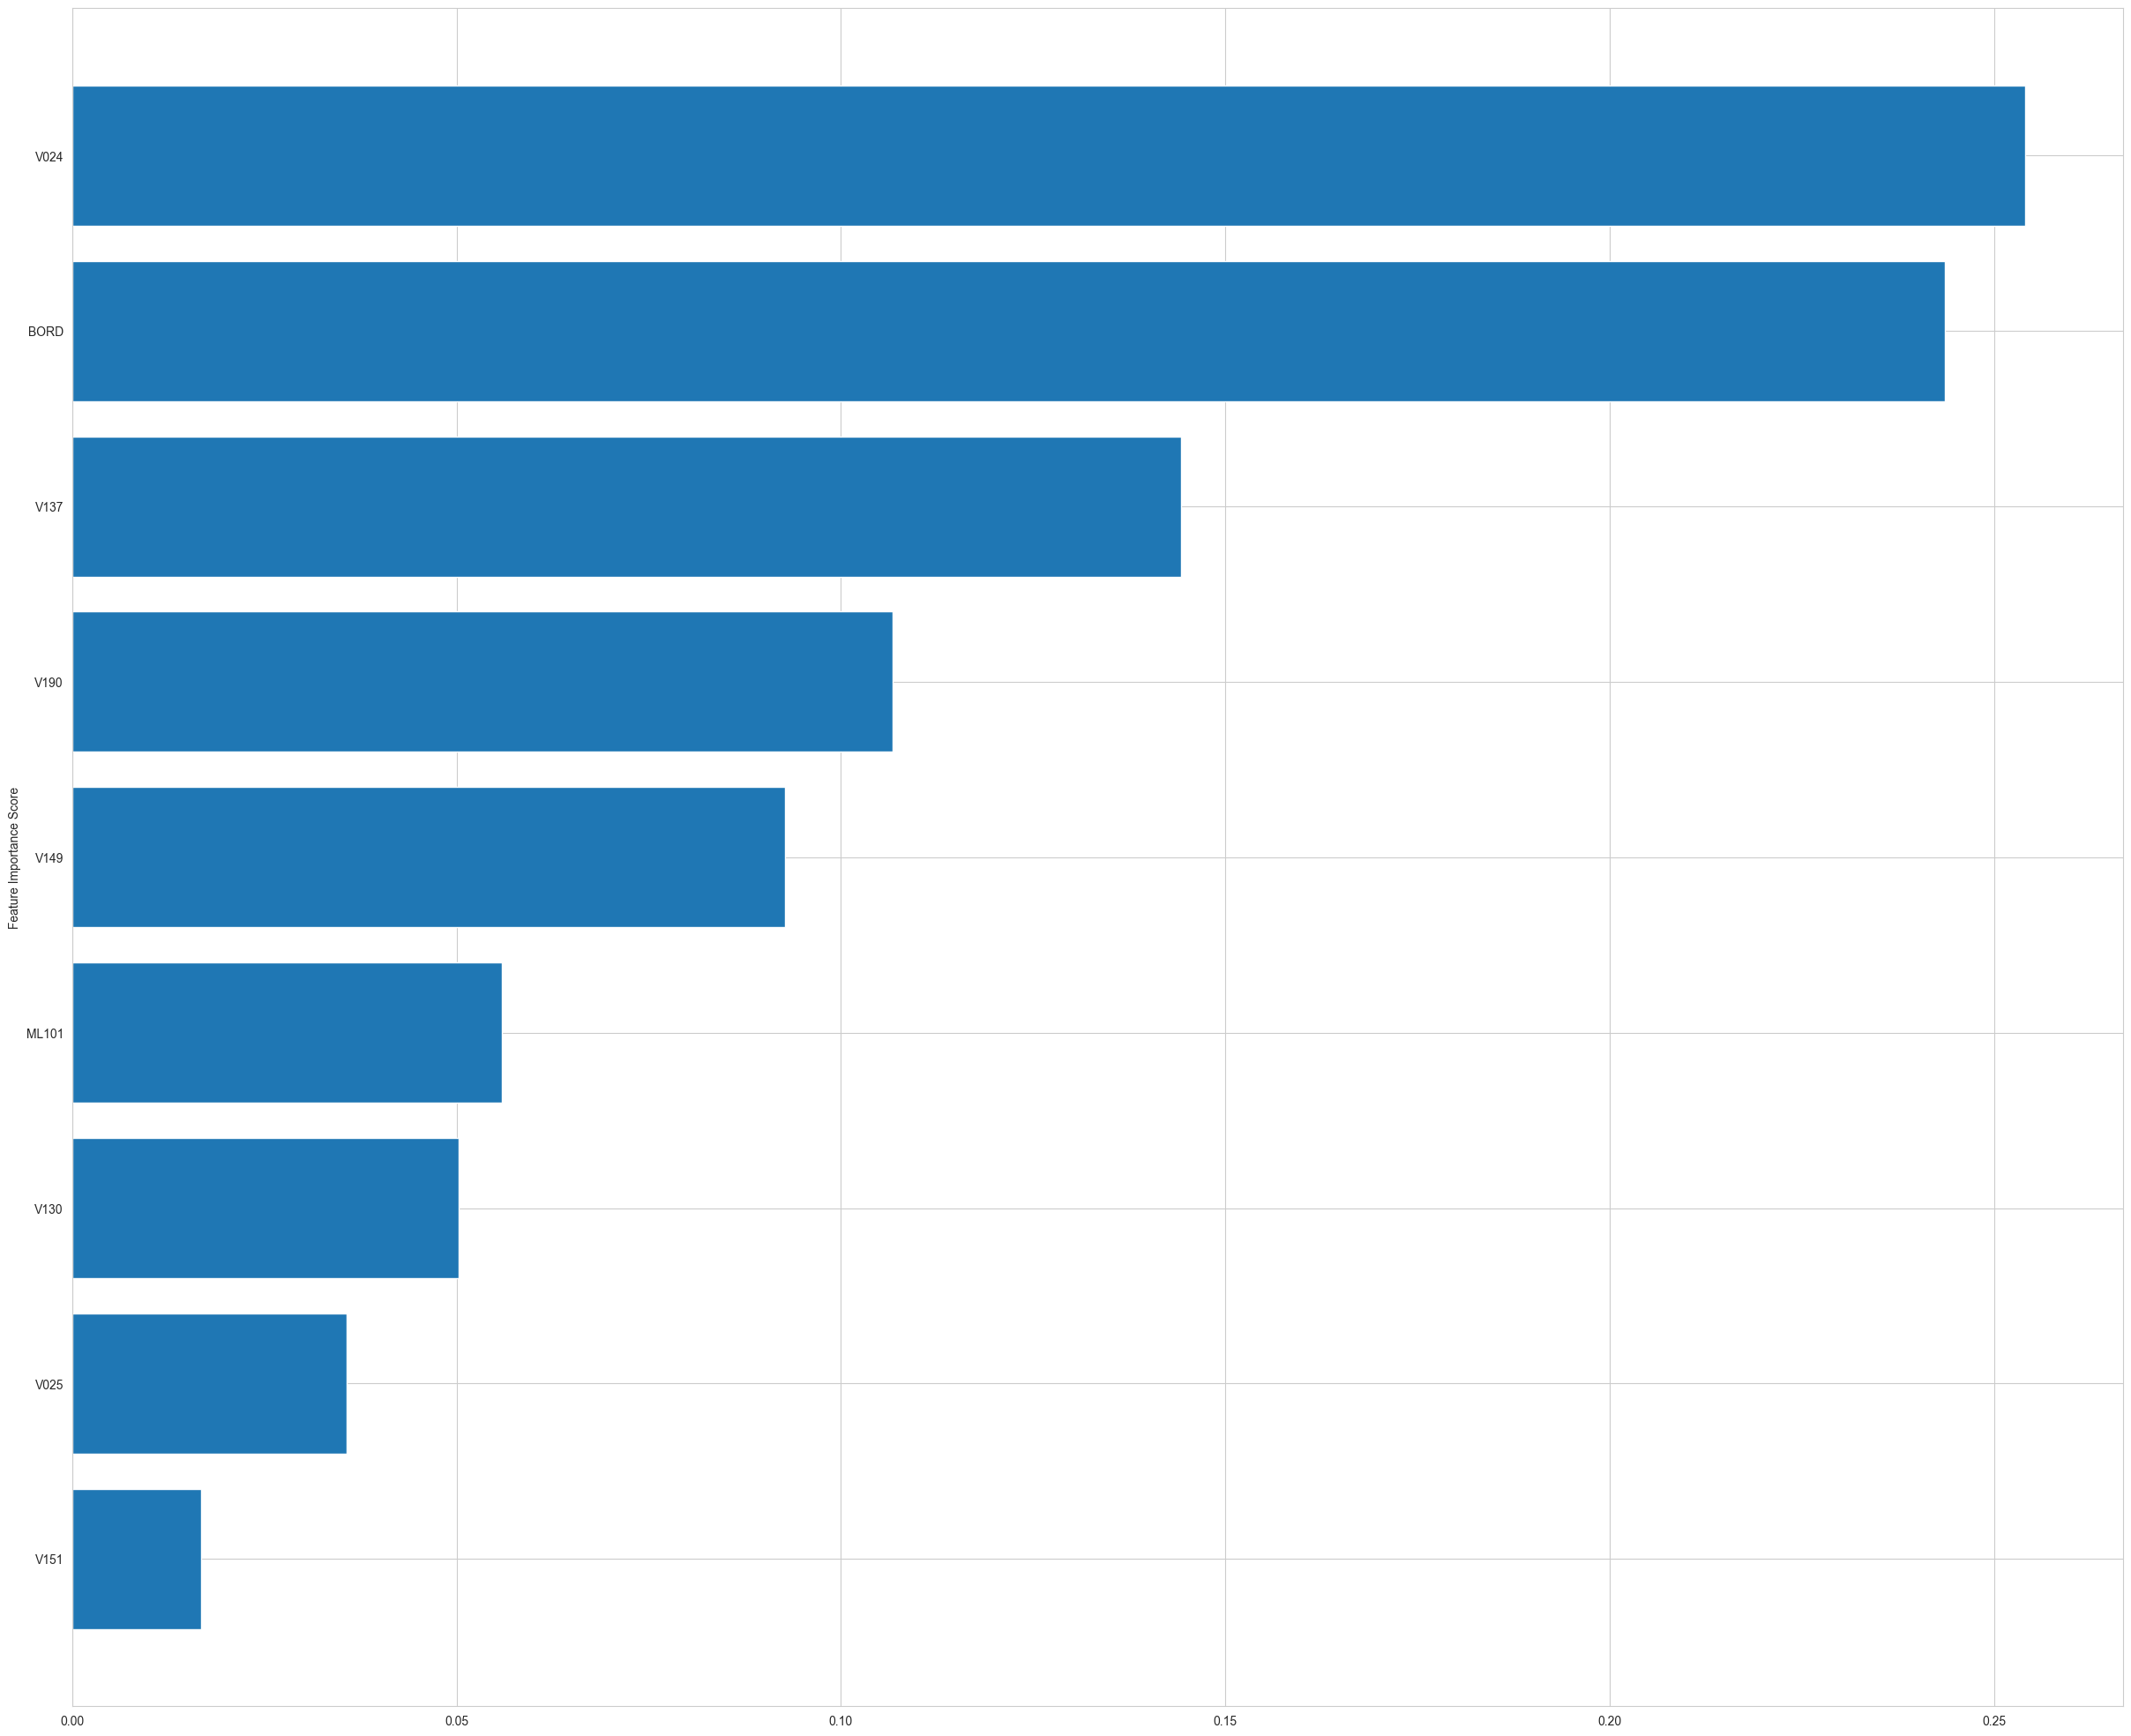

0.995474700507384 0.995474700507384 0.00048302090068913316
28/28 [==============================] - 0s 330us/step
1354    0
935     0
2742    1
975     0
2197    0
       ..
2564    1
698     0
2588    1
1279    0
3345    1
Name: HML32$01, Length: 890, dtype: int64
Unique instance  (array([0, 1]), array([445, 445])) (array([0, 1]), array([333, 557]))
{'0': {'precision': 0.5045045045045045, 'recall': 0.3775280898876405, 'f1-score': 0.4318766066838046, 'support': 445}, '1': {'precision': 0.5026929982046678, 'recall': 0.6292134831460674, 'f1-score': 0.5588822355289421, 'support': 445}, 'accuracy': 0.503370786516854, 'macro avg': {'precision': 0.5035987513545861, 'recall': 0.503370786516854, 'f1-score': 0.49537942110637334, 'support': 890}, 'weighted avg': {'precision': 0.5035987513545862, 'recall': 0.503370786516854, 'f1-score': 0.49537942110637334, 'support': 890}}
Accuracy 0.503370786516854
Precision 0.5026929982046678
Recall 0.6292134831460674
F1 Score 0.5588822355289421
Classification

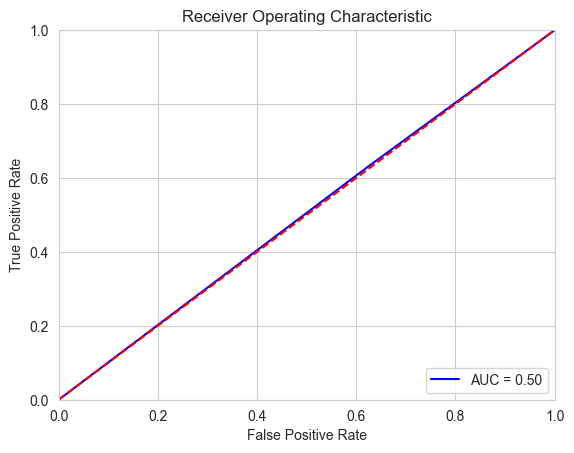

Normalized confusion matrix


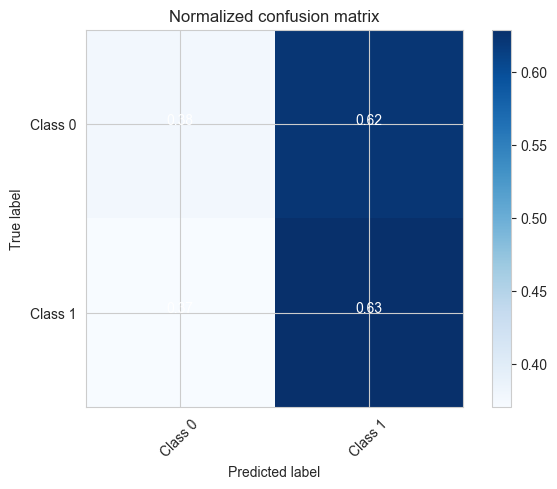

Metrics for the  Evaluation is {'accuracy': 0.503370786516854, 'precision': 0.5026929982046678, 'recall': 0.6292134831460674, 'f1': 0.5588822355289421}
Unique instance  (array([0, 1]), array([445, 445])) (array([0, 1]), array([421, 469]))
{'0': {'precision': 0.505938242280285, 'recall': 0.4786516853932584, 'f1-score': 0.49191685912240185, 'support': 445}, '1': {'precision': 0.5053304904051172, 'recall': 0.5325842696629214, 'f1-score': 0.5185995623632386, 'support': 445}, 'accuracy': 0.5056179775280899, 'macro avg': {'precision': 0.5056343663427012, 'recall': 0.5056179775280899, 'f1-score': 0.5052582107428202, 'support': 890}, 'weighted avg': {'precision': 0.5056343663427012, 'recall': 0.5056179775280899, 'f1-score': 0.5052582107428203, 'support': 890}}
Accuracy 0.5056179775280899
Precision 0.5053304904051172
Recall 0.5325842696629214
F1 Score 0.5185995623632386
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.48      0.49      

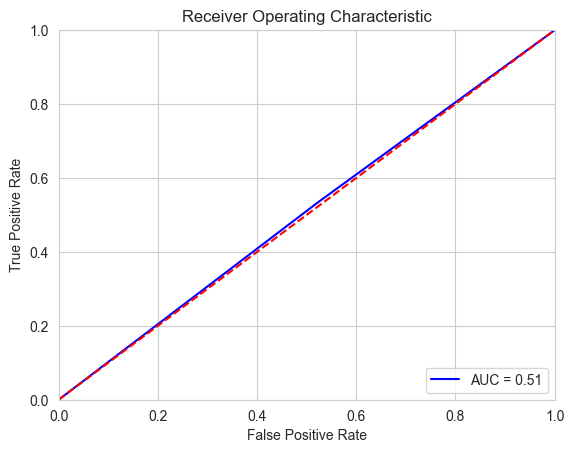

Normalized confusion matrix


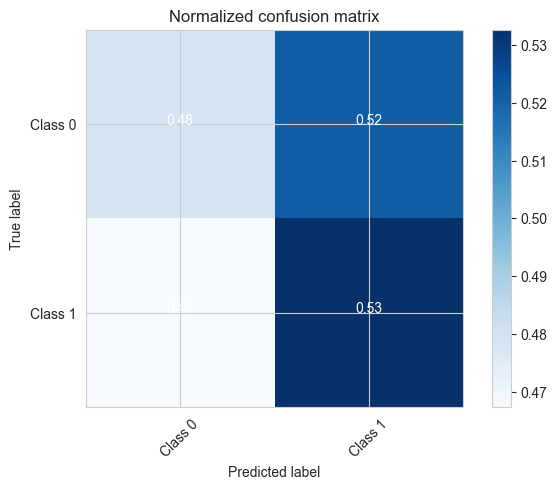

Metrics for the  Evaluation is {'accuracy': 0.5056179775280899, 'precision': 0.5053304904051172, 'recall': 0.5325842696629214, 'f1': 0.5185995623632386}
Unique instance  (array([0, 1]), array([445, 445])) (array([0, 1]), array([493, 397]))
{'0': {'precision': 0.5091277890466531, 'recall': 0.5640449438202247, 'f1-score': 0.5351812366737739, 'support': 445}, '1': {'precision': 0.5113350125944585, 'recall': 0.45617977528089887, 'f1-score': 0.4821852731591449, 'support': 445}, 'accuracy': 0.5101123595505618, 'macro avg': {'precision': 0.5102314008205557, 'recall': 0.5101123595505618, 'f1-score': 0.5086832549164594, 'support': 890}, 'weighted avg': {'precision': 0.5102314008205557, 'recall': 0.5101123595505618, 'f1-score': 0.5086832549164594, 'support': 890}}
Accuracy 0.5101123595505618
Precision 0.5113350125944585
Recall 0.45617977528089887
F1 Score 0.4821852731591449
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.56      0.54   

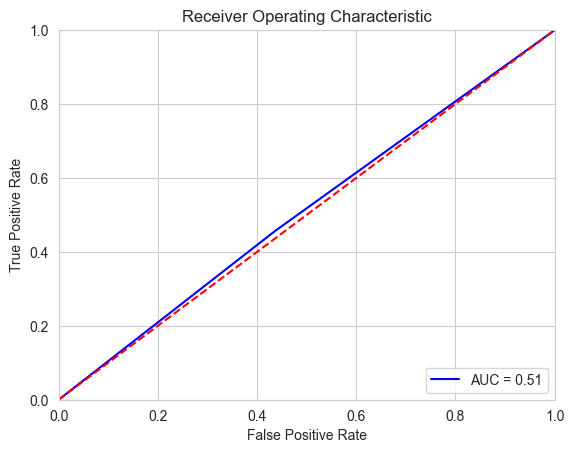

Normalized confusion matrix


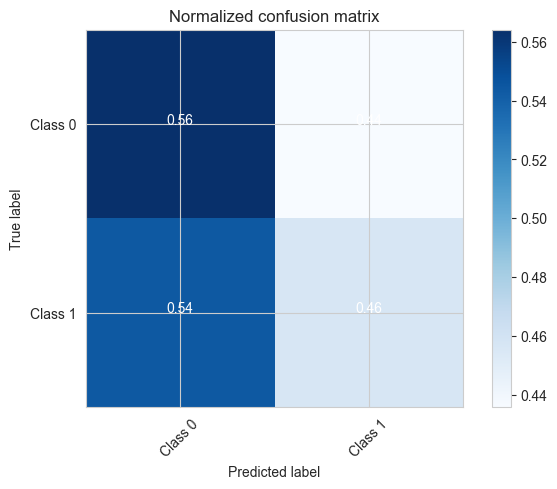

Metrics for the  Evaluation is {'accuracy': 0.5101123595505618, 'precision': 0.5113350125944585, 'recall': 0.45617977528089887, 'f1': 0.4821852731591449}
Unique instance  (array([0, 1]), array([445, 445])) (array([0, 1]), array([421, 469]))
{'0': {'precision': 0.501187648456057, 'recall': 0.47415730337078654, 'f1-score': 0.48729792147806006, 'support': 445}, '1': {'precision': 0.5010660980810234, 'recall': 0.5280898876404494, 'f1-score': 0.5142231947483589, 'support': 445}, 'accuracy': 0.501123595505618, 'macro avg': {'precision': 0.5011268732685402, 'recall': 0.5011235955056179, 'f1-score': 0.5007605581132095, 'support': 890}, 'weighted avg': {'precision': 0.5011268732685402, 'recall': 0.501123595505618, 'f1-score': 0.5007605581132094, 'support': 890}}
Accuracy 0.501123595505618
Precision 0.5010660980810234
Recall 0.5280898876404494
F1 Score 0.5142231947483589
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.47      0.49      

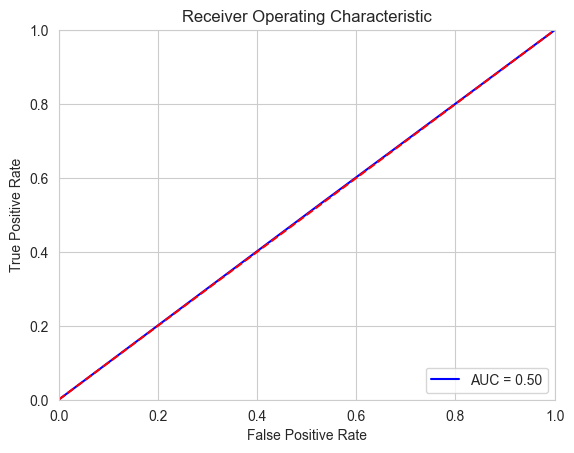

Normalized confusion matrix


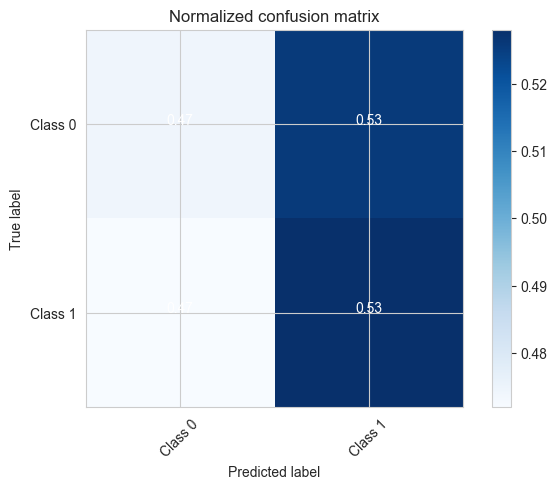

Metrics for the  Evaluation is {'accuracy': 0.501123595505618, 'precision': 0.5010660980810234, 'recall': 0.5280898876404494, 'f1': 0.5142231947483589}
Unique instance  (array([0, 1]), array([445, 445])) (array([0, 1]), array([435, 455]))
{'0': {'precision': 0.5195402298850574, 'recall': 0.5078651685393258, 'f1-score': 0.5136363636363637, 'support': 445}, '1': {'precision': 0.5186813186813187, 'recall': 0.5303370786516854, 'f1-score': 0.5244444444444445, 'support': 445}, 'accuracy': 0.5191011235955056, 'macro avg': {'precision': 0.5191107742831881, 'recall': 0.5191011235955056, 'f1-score': 0.5190404040404041, 'support': 890}, 'weighted avg': {'precision': 0.5191107742831881, 'recall': 0.5191011235955056, 'f1-score': 0.5190404040404041, 'support': 890}}
Accuracy 0.5191011235955056
Precision 0.5186813186813187
Recall 0.5303370786516854
F1 Score 0.5244444444444445
Classification Report
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      

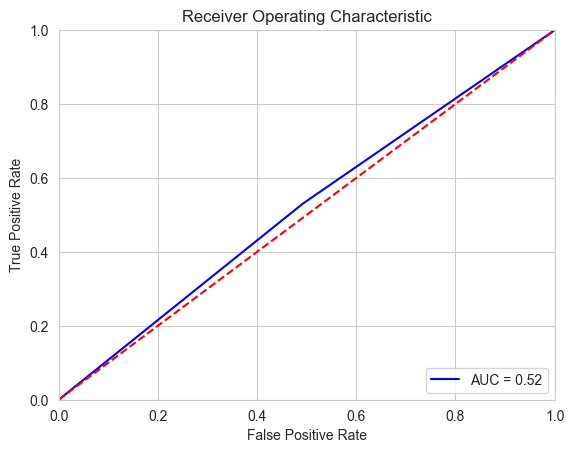

Normalized confusion matrix


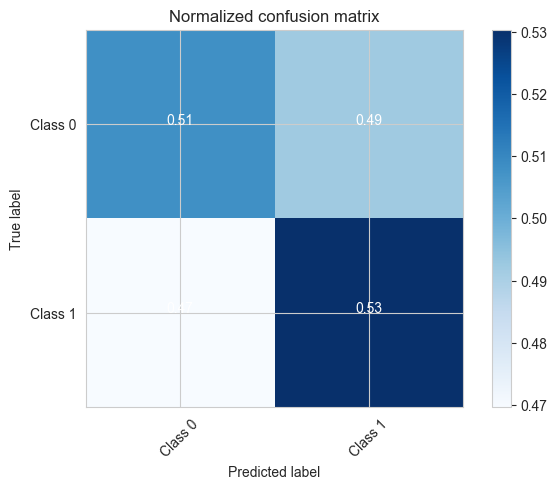

Metrics for the  Evaluation is {'accuracy': 0.5191011235955056, 'precision': 0.5186813186813187, 'recall': 0.5303370786516854, 'f1': 0.5244444444444445}
{'catboost_result': {'accuracy': 0.5056179775280899, 'precision': 0.5053304904051172, 'recall': 0.5325842696629214, 'f1': 0.5185995623632386}, 'xgb': {'accuracy': 0.5101123595505618, 'precision': 0.5113350125944585, 'recall': 0.45617977528089887, 'f1': 0.4821852731591449}, 'log': {'accuracy': 0.501123595505618, 'precision': 0.5010660980810234, 'recall': 0.5280898876404494, 'f1': 0.5142231947483589}, 'neural': {'accuracy': 0.503370786516854, 'precision': 0.5026929982046678, 'recall': 0.6292134831460674, 'f1': 0.5588822355289421}, 'radom_forest': {'accuracy': 0.5191011235955056, 'precision': 0.5186813186813187, 'recall': 0.5303370786516854, 'f1': 0.5244444444444445}}


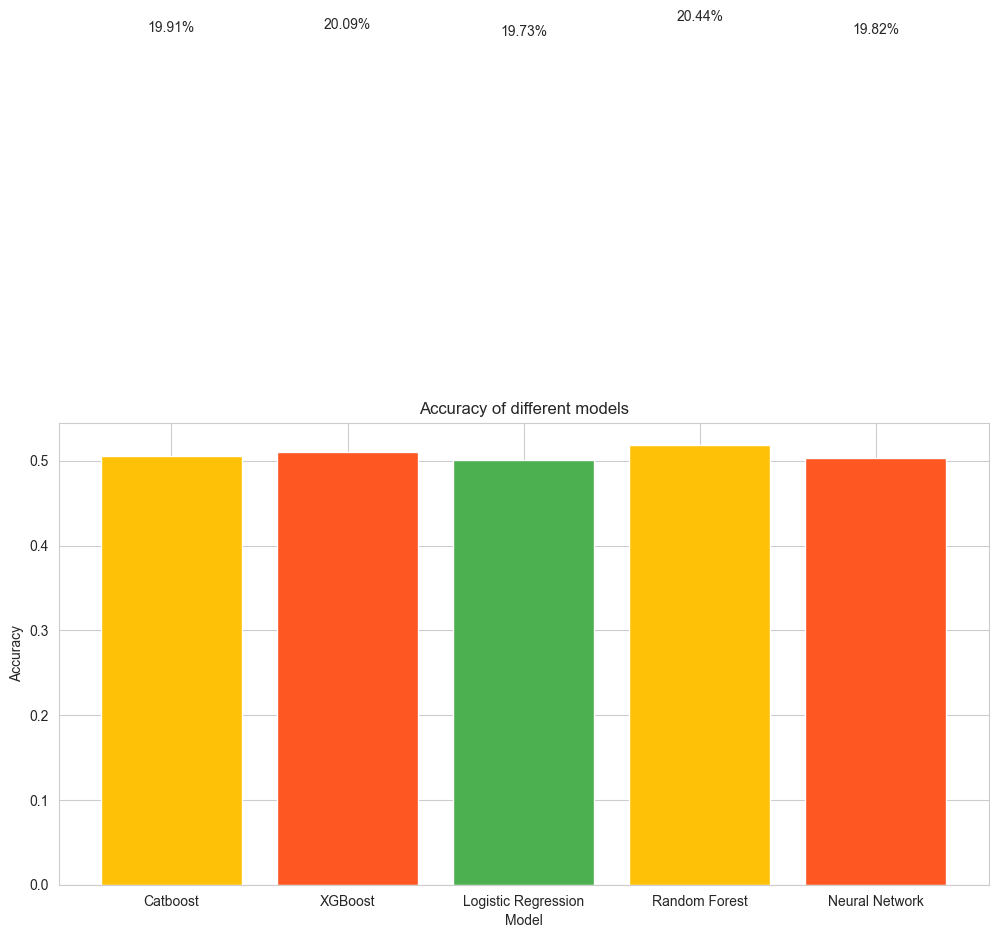

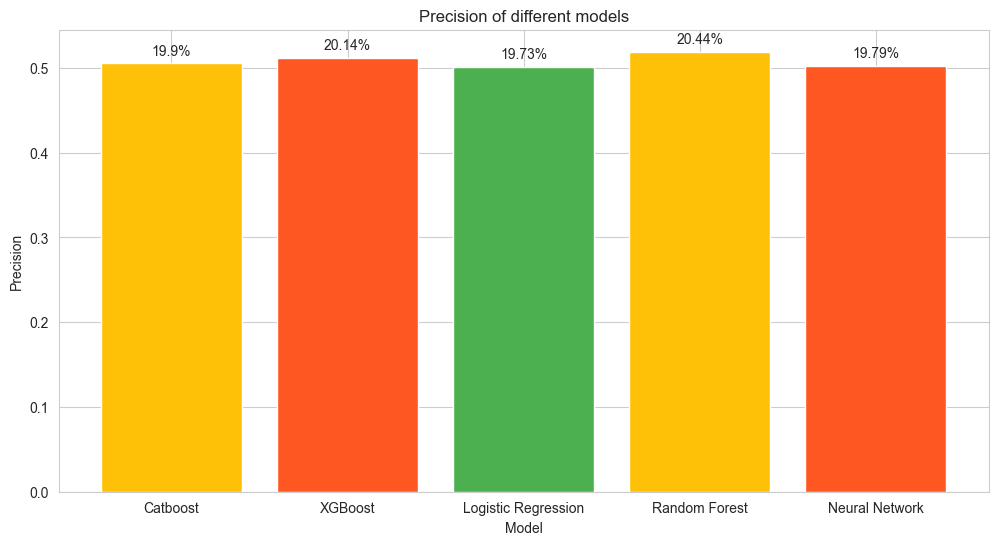

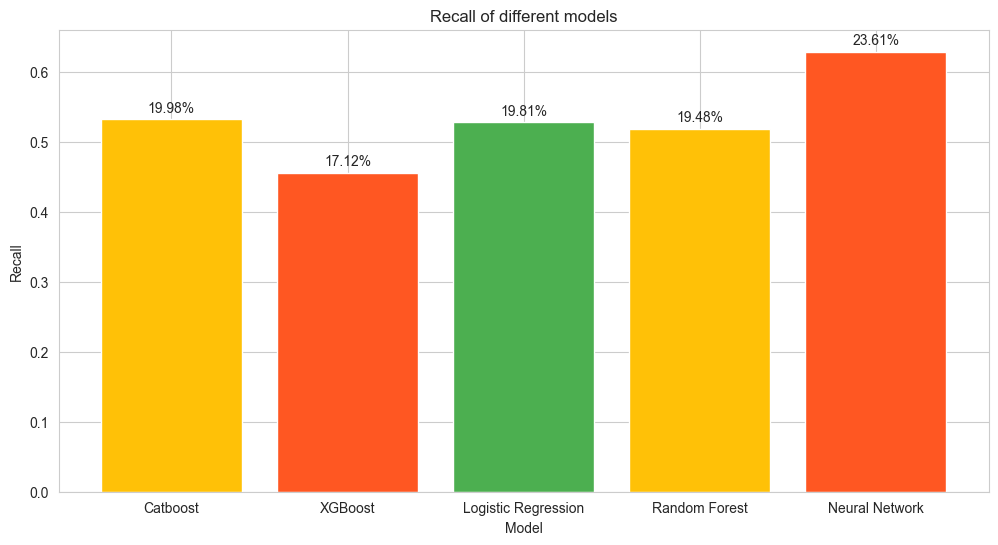

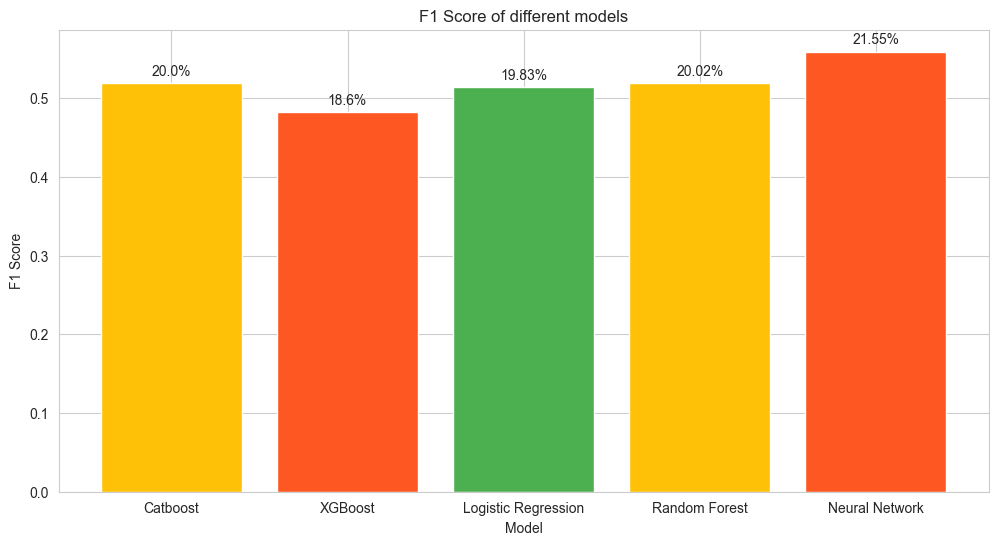

In [37]:
_X, _Y = undersampling()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad, with_cross_neural_result, y_test, X_test)